# Parte 1: Preprocesamiento y Modelos LightGBM

---

# Librerías necesarias para trabajar

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.9/413.9 kB 34.2 MB/s eta 0:00:00


In [ ]:
# Librerías básicas
import pandas as pd
import numpy as np
import json
import os
import pickle
from functools import partial

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
import lightgbm as lgb
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import cohen_kappa_score, classification_report, confusion_matrix, mean_squared_error
from sklearn.base import BaseEstimator, ClassifierMixin, clone
import scipy.optimize as sp

# Optimización de hiperparámetros
import optuna

# Utilidades
from tqdm import tqdm
from tqdm.notebook import tqdm as tqdm_notebook
import joblib
import warnings

# Google Colab
from google.colab import drive

# Configuración
warnings.filterwarnings("ignore")
optuna.logging.set_verbosity(optuna.logging.WARNING)
pd.set_option('display.max_columns', None)

# Carga de datos

In [ ]:
from google.colab import drive

# 1. Montar Google Drive
drive.mount('/content/drive')

# 2. Definir rutas
ruta_zip_en_drive = "/content/drive/MyDrive/data_pet_adoption.zip"
ruta_destino_local = "/content/dataset_local"

# 3. Copiar y Descomprimir (Solo si no lo has hecho ya)
if not os.path.exists(ruta_destino_local):
    print("Copiando y descomprimiendo datos... (esto puede tardar un poco)")

    # Creamos la carpeta local
    os.makedirs(ruta_destino_local, exist_ok=True)

    # Comando de sistema para descomprimir rápido
    # -q es para que no imprima miles de líneas (quiet)
    # -d es el destino
    !unzip -q "{ruta_zip_en_drive}" -d "{ruta_destino_local}"

    print("¡Datos listos en el entorno local!")
else:
    print("Los datos ya estaban descomprimidos.")

Mounted at /content/drive
Copiando y descomprimiendo datos... (esto puede tardar un poco)
¡Datos listos en el entorno local!


# EDA

## train.csv

In [ ]:
# 1. Cargar el archivo
df = pd.read_csv('/content/dataset_local/petfinder-adoption-prediction/train.csv')

print(f"✅ Dataset cargado. Dimensiones: {df.shape[0]} filas x {df.shape[1]} columnas")
print("-" * 50)

# 2. Ver las primeras 5 filas (Para entender qué hay dentro)
print("\n--- 1. HEAD (Primeras filas) ---")
display(df.head())

# 3. Ver información técnica (Tipos de datos y Nulos)
print("\n--- 2. INFO (Tipos y Nulos) ---")
df.info()

# 4. Ver estadística básica (Solo numéricos)
print("\n--- 3. DESCRIBE (Estadísticas) ---")
display(df.describe())

✅ Dataset cargado. Dimensiones: 14993 filas x 24 columnas
--------------------------------------------------

--- 1. HEAD (Primeras filas) ---


Type         Name  Age  Breed1  Breed2  Gender  Color1  Color2  Color3  \
0     2       Nibble    3     299       0       1       1       7       0   
1     2  No Name Yet    1     265       0       1       1       2       0   
2     1       Brisco    1     307       0       1       2       7       0   
3     1         Miko    4     307       0       2       1       2       0   
4     1       Hunter    1     307       0       1       1       0       0   

   MaturitySize  FurLength  Vaccinated  Dewormed  Sterilized  Health  \
0             1          1           2         2           2       1   
1             2          2           3         3           3       1   
2             2          2           1         1           2       1   
3             2          1           1         1           2       1   
4             2          1           2         2           2       1   

   Quantity  Fee  State                         RescuerID  VideoAmt  \
0         1  100  41326  8480853f516546f6cf33aa88cd76c379         0   
1         1    0  41401  3082c7125d8fb66f7dd4bff4192c8b14         0   
2         1    0  41326  fa90fa5b1ee11c86938398b60abc32cb         0   
3         1  150  41401  9238e4f44c71a75282e62f7136c6b240         0   
4         1    0  41326  95481e953f8aed9ec3d16fc4509537e8         0   

                                         Description      PetID  PhotoAmt  \
0  Nibble is a 3+ month old ball of cuteness. He ...  86e1089a3       1.0   
1  I just found it alone yesterday near my apartm...  6296e909a       2.0   
2  Their pregnant mother was dumped by her irresp...  3422e4906       7.0   
3  Good guard dog, very alert, active, obedience ...  5842f1ff5       8.0   
4  This handsome yet cute boy is up for adoption....  850a43f90       3.0   

   AdoptionSpeed  
0              2  
1              0  
2              3  
3              2  
4              2


--- 2. INFO (Tipos y Nulos) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14993 entries, 0 to 14992
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Type           14993 non-null  int64  
 1   Name           13728 non-null  object 
 2   Age            14993 non-null  int64  
 3   Breed1         14993 non-null  int64  
 4   Breed2         14993 non-null  int64  
 5   Gender         14993 non-null  int64  
 6   Color1         14993 non-null  int64  
 7   Color2         14993 non-null  int64  
 8   Color3         14993 non-null  int64  
 9   MaturitySize   14993 non-null  int64  
 10  FurLength      14993 non-null  int64  
 11  Vaccinated     14993 non-null  int64  
 12  Dewormed       14993 non-null  int64  
 13  Sterilized     14993 non-null  int64  
 14  Health         14993 non-null  int64  
 15  Quantity       14993 non-null  int64  
 16  Fee            14993 non-null  int64  
 17  State          14

Type           Age        Breed1        Breed2        Gender  \
count  14993.000000  14993.000000  14993.000000  14993.000000  14993.000000   
mean       1.457614     10.452078    265.272594     74.009738      1.776162   
std        0.498217     18.155790     60.056818    123.011575      0.681592   
min        1.000000      0.000000      0.000000      0.000000      1.000000   
25%        1.000000      2.000000    265.000000      0.000000      1.000000   
50%        1.000000      3.000000    266.000000      0.000000      2.000000   
75%        2.000000     12.000000    307.000000    179.000000      2.000000   
max        2.000000    255.000000    307.000000    307.000000      3.000000   

             Color1        Color2        Color3  MaturitySize     FurLength  \
count  14993.000000  14993.000000  14993.000000  14993.000000  14993.000000   
mean       2.234176      3.222837      1.882012      1.862002      1.467485   
std        1.745225      2.742562      2.984086      0.547959      0.599070   
min        1.000000      0.000000      0.000000      1.000000      1.000000   
25%        1.000000      0.000000      0.000000      2.000000      1.000000   
50%        2.000000      2.000000      0.000000      2.000000      1.000000   
75%        3.000000      6.000000      5.000000      2.000000      2.000000   
max        7.000000      7.000000      7.000000      4.000000      3.000000   

         Vaccinated      Dewormed    Sterilized        Health      Quantity  \
count  14993.000000  14993.000000  14993.000000  14993.000000  14993.000000   
mean       1.731208      1.558727      1.914227      1.036617      1.576069   
std        0.667649      0.695817      0.566172      0.199535      1.472477   
min        1.000000      1.000000      1.000000      1.000000      1.000000   
25%        1.000000      1.000000      2.000000      1.000000      1.000000   
50%        2.000000      1.000000      2.000000      1.000000      1.000000   
75%        2.000000      2.000000      2.000000      1.000000      1.000000   
max        3.000000      3.000000      3.000000      3.000000     20.000000   

                Fee         State      VideoAmt      PhotoAmt  AdoptionSpeed  
count  14993.000000  14993.000000  14993.000000  14993.000000   14993.000000  
mean      21.259988  41346.028347      0.056760      3.889215       2.516441  
std       78.414548     32.444153      0.346185      3.487810       1.177265  
min        0.000000  41324.000000      0.000000      0.000000       0.000000  
25%        0.000000  41326.000000      0.000000      2.000000       2.000000  
50%        0.000000  41326.000000      0.000000      3.000000       2.000000  
75%        0.000000  41401.000000      0.000000      5.000000       4.000000  
max     3000.000000  41415.000000      8.000000     30.000000       4.000000

## color_labels.csv

In [ ]:
# 1. Cargar el archivo
df = pd.read_csv('/content/dataset_local/petfinder-adoption-prediction/color_labels.csv')

print(f"✅ Dataset cargado. Dimensiones: {df.shape[0]} filas x {df.shape[1]} columnas")
print("-" * 50)

# 2. Ver las primeras 5 filas (Para entender qué hay dentro)
print("\n--- 1. HEAD (Primeras filas) ---")
display(df.head())

# 3. Ver información técnica (Tipos de datos y Nulos)
print("\n--- 2. INFO (Tipos y Nulos) ---")
df.info()

# 4. Ver estadística básica (Solo numéricos)
print("\n--- 3. DESCRIBE (Estadísticas) ---")
display(df.describe())

✅ Dataset cargado. Dimensiones: 7 filas x 2 columnas
--------------------------------------------------

--- 1. HEAD (Primeras filas) ---


ColorID ColorName
0        1     Black
1        2     Brown
2        3    Golden
3        4    Yellow
4        5     Cream


--- 2. INFO (Tipos y Nulos) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ColorID    7 non-null      int64 
 1   ColorName  7 non-null      object
dtypes: int64(1), object(1)
memory usage: 244.0+ bytes

--- 3. DESCRIBE (Estadísticas) ---


ColorID
count  7.000000
mean   4.000000
std    2.160247
min    1.000000
25%    2.500000
50%    4.000000
75%    5.500000
max    7.000000

## state_labels.csv

In [ ]:
# 1. Cargar el archivo
df = pd.read_csv('/content/dataset_local/petfinder-adoption-prediction/state_labels.csv')

print(f"✅ Dataset cargado. Dimensiones: {df.shape[0]} filas x {df.shape[1]} columnas")
print("-" * 50)

# 2. Ver las primeras 5 filas (Para entender qué hay dentro)
print("\n--- 1. HEAD (Primeras filas) ---")
display(df.head())

# 3. Ver información técnica (Tipos de datos y Nulos)
print("\n--- 2. INFO (Tipos y Nulos) ---")
df.info()

# 4. Ver estadística básica (Solo numéricos)
print("\n--- 3. DESCRIBE (Estadísticas) ---")
display(df.describe())

✅ Dataset cargado. Dimensiones: 15 filas x 2 columnas
--------------------------------------------------

--- 1. HEAD (Primeras filas) ---


StateID     StateName
0    41336         Johor
1    41325         Kedah
2    41367      Kelantan
3    41401  Kuala Lumpur
4    41415        Labuan


--- 2. INFO (Tipos y Nulos) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   StateID    15 non-null     int64 
 1   StateName  15 non-null     object
dtypes: int64(1), object(1)
memory usage: 372.0+ bytes

--- 3. DESCRIBE (Estadísticas) ---


StateID
count     15.000000
mean   41349.733333
std       29.001149
min    41324.000000
25%    41328.500000
50%    41336.000000
75%    41364.000000
max    41415.000000

## breed_labels

In [ ]:
# 1. Cargar el archivo
df = pd.read_csv('/content/dataset_local/petfinder-adoption-prediction/breed_labels.csv')

print(f"✅ Dataset cargado. Dimensiones: {df.shape[0]} filas x {df.shape[1]} columnas")
print("-" * 50)

# 2. Ver las primeras 5 filas (Para entender qué hay dentro)
print("\n--- 1. HEAD (Primeras filas) ---")
display(df.head())

# 3. Ver información técnica (Tipos de datos y Nulos)
print("\n--- 2. INFO (Tipos y Nulos) ---")
df.info()

# 4. Ver estadística básica (Solo numéricos)
print("\n--- 3. DESCRIBE (Estadísticas) ---")
display(df.describe())

✅ Dataset cargado. Dimensiones: 307 filas x 3 columnas
--------------------------------------------------

--- 1. HEAD (Primeras filas) ---


BreedID  Type         BreedName
0        1     1     Affenpinscher
1        2     1      Afghan Hound
2        3     1  Airedale Terrier
3        4     1            Akbash
4        5     1             Akita


--- 2. INFO (Tipos y Nulos) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307 entries, 0 to 306
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   BreedID    307 non-null    int64 
 1   Type       307 non-null    int64 
 2   BreedName  307 non-null    object
dtypes: int64(2), object(1)
memory usage: 7.3+ KB

--- 3. DESCRIBE (Estadísticas) ---


BreedID        Type
count  307.000000  307.000000
mean   154.000000    1.214984
std     88.767487    0.411482
min      1.000000    1.000000
25%     77.500000    1.000000
50%    154.000000    1.000000
75%    230.500000    1.000000
max    307.000000    2.000000

## train_sentiment.csv

In [ ]:
import pandas as pd
import json
import os
from tqdm.notebook import tqdm

# 1. Definir la ruta
sentiment_path = '/content/dataset_local/petfinder-adoption-prediction/train_sentiment'

# 2. Preparamos una lista para guardar los datos
sentiment_data = []

# 3. Obtenemos la lista de archivos (limitamos a .json)
files = [f for f in os.listdir(sentiment_path) if f.endswith('.json')]

print(f"📂 Encontrados {len(files)} archivos de sentimiento. Procesando...")

# 4. Bucle para leer cada archivo
for filename in tqdm(files):
    file_path = os.path.join(sentiment_path, filename)

    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            json_content = json.load(f)

        # Extraemos lo que nos interesa
        # El PetID es el nombre del archivo sin el ".json"
        pet_id = filename.split('.')[0]

        # Datos del JSON
        score = json_content['documentSentiment']['score']
        magnitude = json_content['documentSentiment']['magnitude']
        language = json_content['language']

        # Guardamos en la lista
        sentiment_data.append({
            'PetID': pet_id,
            'SentimentScore': score,
            'SentimentMagnitude': magnitude,
            'Language': language
        })

    except Exception as e:
        print(f"Error leyendo {filename}: {e}")

# 5. Convertimos la lista a DataFrame
df_sentiment = pd.DataFrame(sentiment_data)

print("✅ Tabla de Sentimientos creada exitosamente.")

# --- A. VISTA PREVIA ---
print("\n--- 1. PRIMERAS FILAS ---")
display(df_sentiment.head())

# --- B. ESTADÍSTICAS DEL SENTIMIENTO ---
print("\n--- 2. ESTADÍSTICAS (Score y Magnitud) ---")
# Esto es crucial:
# - Si la media del Score es cercana a 1, todo el mundo habla bien de sus mascotas.
# - Si la Magnitud media es baja, las descripciones son muy cortas o secas.
display(df_sentiment[['SentimentScore', 'SentimentMagnitude']].describe())

# --- C. IDIOMAS ---
print("\n--- 3. IDIOMAS DETECTADOS ---")
# ¿Están todos en inglés ('en')? ¿Hay alguno en malayo ('ms')?
idiomas = df_sentiment['Language'].value_counts()
display(idiomas)

# --- D. TIPOS DE DATOS ---
print("\n--- 4. INFO TÉCNICA ---")
df_sentiment.info()

📂 Encontrados 14442 archivos de sentimiento. Procesando...


  0%|          | 0/14442 [00:00<?, ?it/s]

✅ Tabla de Sentimientos creada exitosamente.

--- 1. PRIMERAS FILAS ---


PetID  SentimentScore  SentimentMagnitude Language
0  40f1ee340             0.0                 1.5       en
1  0adebbf21             0.0                 1.7       en
2  bb4c6519d             0.0                 0.0       en
3  532b5a798             0.3                 1.2       en
4  4194f0f66             0.2                 2.3       en


--- 2. ESTADÍSTICAS (Score y Magnitud) ---


SentimentScore  SentimentMagnitude
count    14442.000000        14442.000000
mean         0.280951            2.127628
std          0.276766            2.036914
min         -0.900000            0.000000
25%          0.100000            0.800000
50%          0.300000            1.600000
75%          0.400000            2.800000
max          0.900000           32.000000


--- 3. IDIOMAS DETECTADOS ---


Language
en         14309
zh            95
zh-Hant       36
de             2
Name: count, dtype: int64


--- 4. INFO TÉCNICA ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14442 entries, 0 to 14441
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   PetID               14442 non-null  object 
 1   SentimentScore      14442 non-null  float64
 2   SentimentMagnitude  14442 non-null  float64
 3   Language            14442 non-null  object 
dtypes: float64(2), object(2)
memory usage: 451.4+ KB


# Pipeline ETL: Preprocesamiento y Feature Engineering

In [ ]:
# Configuración visual
pd.set_option('display.max_columns', None)
tqdm.pandas()

# =============================================================================
# 1. CONFIGURACIÓN DE RUTAS
# =============================================================================
PATHS = {
    'train': '/content/dataset_local/petfinder-adoption-prediction/train.csv',
    'breeds': '/content/dataset_local/petfinder-adoption-prediction/breed_labels.csv',
    'colors': '/content/dataset_local/petfinder-adoption-prediction/color_labels.csv',
    'states': '/content/dataset_local/petfinder-adoption-prediction/state_labels.csv',
    'sentiment_dir': '/content/dataset_local/petfinder-adoption-prediction/train_sentiment'
}

# =============================================================================
# 2. CARGA DE DATOS Y CORRECCIÓN PREVENTIVA
# =============================================================================
print("🚀 Iniciando Pipeline Maestro...")

# Cargar CSVs
df_main = pd.read_csv(PATHS['train'])
df_breeds = pd.read_csv(PATHS['breeds'])
df_colors = pd.read_csv(PATHS['colors'])
df_states = pd.read_csv(PATHS['states'])

print(f"   - Dataset original: {df_main.shape}")

# --- FIX CRÍTICO: COLUMNA 'TYPE' ---
# El archivo de razas también tiene una columna 'Type'. Si no la quitamos antes de
# unir, Pandas creará conflictos y corromperá la columna Type original.
if 'Type' in df_breeds.columns:
    df_breeds = df_breeds.drop('Type', axis=1)

# =============================================================================
# 3. FUSIÓN DE DATOS (ENRICHMENT)
# =============================================================================

# A. Razas (Traemos los nombres para Master, mantenemos IDs para ML)
df_main = df_main.merge(df_breeds, left_on='Breed1', right_on='BreedID', how='left')
df_main.rename(columns={'BreedName': 'Breed1_Name'}, inplace=True)
df_main.drop('BreedID', axis=1, inplace=True)

df_main = df_main.merge(df_breeds, left_on='Breed2', right_on='BreedID', how='left')
df_main.rename(columns={'BreedName': 'Breed2_Name'}, inplace=True)
df_main.drop('BreedID', axis=1, inplace=True)

# B. Colores
for i in [1, 2, 3]:
    col_name = f'Color{i}'
    df_main = df_main.merge(df_colors, left_on=col_name, right_on='ColorID', how='left')
    df_main.rename(columns={'ColorName': f'{col_name}_Name'}, inplace=True)
    df_main.drop('ColorID', axis=1, inplace=True)

# C. Estados
df_main = df_main.merge(df_states, left_on='State', right_on='StateID', how='left')
df_main.rename(columns={'StateName': 'State_Name'}, inplace=True)
df_main.drop('StateID', axis=1, inplace=True)

print("✅ Tablas fusionadas correctamente (sin perder 'Type').")

# =============================================================================
# 4. EXTRACCIÓN DE SENTIMIENTOS (NLP)
# =============================================================================
print("⏳ Procesando Sentimientos (JSON)...")

def extract_sentiment(pet_id):
    path = os.path.join(PATHS['sentiment_dir'], f"{pet_id}.json")
    score, magnitude, language = 0, 0, 'en'

    if os.path.exists(path):
        try:
            with open(path, 'r', encoding='utf-8') as f:
                data = json.load(f)
                score = data['documentSentiment']['score']
                magnitude = data['documentSentiment']['magnitude']
                language = data['language']
        except:
            pass
    return pd.Series([score, magnitude, language])

df_main[['SentimentScore', 'SentimentMagnitude', 'Language']] = df_main['PetID'].progress_apply(extract_sentiment)

# =============================================================================
# 5. FEATURE ENGINEERING (INGENIERÍA DE CARACTERÍSTICAS)
# =============================================================================
print("🛠️ Creando Variables Derivadas...")

# A. Variables de Texto
invalid_names = ['no name', 'noname', 'none', 'na', 'unknown', 'sin nombre', '0']
df_main['HasName'] = df_main['Name'].apply(
    lambda x: 0 if pd.isna(x) or str(x).lower().strip() in invalid_names or len(str(x)) < 2 else 1
)
df_main['DescWordCount'] = df_main['Description'].fillna("").apply(lambda x: len(str(x).split()))

# B. Variables Biológicas (Mestizaje y Edad)
df_main['IsMixedBreed'] = df_main.apply(
    lambda x: 1 if (x['Breed1'] == 307 or x['Breed2'] == 307 or (x['Breed2'] != 0 and x['Breed1'] != x['Breed2'])) else 0, axis=1
)
df_main['AgeBin'] = pd.cut(df_main['Age'], bins=[-1, 3, 12, 60, 255], labels=[0, 1, 2, 3]).astype(int)

# C. Variables Económicas y Multimedia
df_main['IsFree'] = (df_main['Fee'] == 0).astype(int)
df_main['TotalMultimedia'] = df_main['PhotoAmt'] + df_main['VideoAmt']

# D. Sentimiento Avanzado
df_main['SentimentImpact'] = df_main['SentimentScore'] * df_main['SentimentMagnitude']

# =============================================================================
# 6. LIMPIEZA FINAL Y CREACIÓN DE DATASETS
# =============================================================================

# --- A. Guardar MASTER (Humano) ---
# Rellenamos nulos visuales para el CSV maestro
df_master = df_main.copy()
text_cols = ['Breed1_Name', 'Breed2_Name', 'Color1_Name', 'Color2_Name', 'Color3_Name', 'State_Name']
for col in text_cols:
    if col in df_master.columns:
        df_master[col] = df_master[col].fillna("None")

df_master['Name'].fillna("No Name", inplace=True)
df_master['Description'].fillna("", inplace=True)

df_master.to_csv('master.csv', index=False)
print(f"📄 'master.csv' generado. (Contiene texto legible y {df_master.shape[0]} filas)")


# --- B. Guardar TRAIN READY (Máquina) ---
print("🧹 Preparando dataset numérico para LightGBM...")
df_model = df_master.copy()

# 1. Eliminamos columnas de TEXTO o IDs inútiles para el modelo
cols_to_drop = [
    'Name', 'Description', 'RescuerID', 'PetID',  # Texto libre / IDs únicos
    'Breed1_Name', 'Breed2_Name',                 # Redundantes (ya tenemos Breed1 ID)
    'Color1_Name', 'Color2_Name', 'Color3_Name',  # Redundantes (ya tenemos Color1 ID)
    'State_Name', 'Language'                      # Texto
]
# Solo borramos si existen
df_model.drop(columns=[c for c in cols_to_drop if c in df_model.columns], inplace=True)

# 2. Encoding manual de lo que falta
# State era texto en master, necesitamos recuperar el ID o codificarlo.
# Como borramos StateID al inicio, usamos el State_Name recuperado en Master, pero para el modelo
# lo transformamos a número.
if 'State_Name' in df_main.columns:
     # Usamos Label Encoding sobre el dataframe original antes de borrar
     df_model['State'] = df_main['State_Name'].astype('category').cat.codes

# 3. Asegurar tipos numéricos (Ints donde corresponda)
cols_int = ['Type', 'Gender', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
            'Sterilized', 'Health', 'Quantity', 'Fee', 'VideoAmt', 'PhotoAmt']
for col in cols_int:
    if col in df_model.columns:
        df_model[col] = df_model[col].astype(int)

# Separamos en train y test
X_train, X_test, y_train, y_test = train_test_split(df_model.drop('AdoptionSpeed', axis=1), df_model['AdoptionSpeed'], test_size=0.2, random_state=42)

df_train = pd.concat([X_train, y_train], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)

# Guardar
df_train.to_csv('train_ready.csv', index=False)
df_test.to_csv('test_ready.csv', index=False)

print("="*60)
print(f"🎉 ¡TODO LISTO! Archivo para entrenar: 'train_ready.csv'")
print(f"📊 Dimensiones para el modelo: {df_train.shape}")
print(f"⚠️ Nulos restantes en el modelo: {df_model.isnull().sum().sum()} (Debería ser 0)")
print("="*60)

# Muestra final del dataset numérico
display(df_model.head(3))

🚀 Iniciando Pipeline Maestro...
   - Dataset original: (14993, 24)
✅ Tablas fusionadas correctamente (sin perder 'Type').
⏳ Procesando Sentimientos (JSON)...


  0%|          | 0/14993 [00:00<?, ?it/s]

🛠️ Creando Variables Derivadas...
📄 'master.csv' generado. (Contiene texto legible y 14993 filas)
🧹 Preparando dataset numérico para LightGBM...
🎉 ¡TODO LISTO! Archivo para entrenar: 'train_ready.csv'
📊 Dimensiones para el modelo: (11994, 29)
⚠️ Nulos restantes en el modelo: 0 (Debería ser 0)


Type  Age  Breed1  Breed2  Gender  Color1  Color2  Color3  MaturitySize  \
0     2    3     299       0       1       1       7       0             1   
1     2    1     265       0       1       1       2       0             2   
2     1    1     307       0       1       2       7       0             2   

   FurLength  Vaccinated  Dewormed  Sterilized  Health  Quantity  Fee  State  \
0          1           2         2           2       1         1  100     12   
1          2           3         3           3       1         1    0      3   
2          2           1         1           2       1         1    0     12   

   VideoAmt  PhotoAmt  AdoptionSpeed  SentimentScore  SentimentMagnitude  \
0         0         1              2             0.3                 2.4   
1         0         2              0            -0.2                 0.7   
2         0         7              3             0.2                 3.7   

   HasName  DescWordCount  IsMixedBreed  AgeBin  IsFree  TotalMultimedia  \
0        1             69             0       0       0              1.0   
1        1             23             0       0       1              2.0   
2        1             69             1       0       1              7.0   

   SentimentImpact  
0             0.72  
1            -0.14  
2             0.74

# Entrenamiento del modelo

El objetivo de este proyecto es predecir la velocidad de adopción (`AdoptionSpeed`), una variable que toma valores enteros del **0 al 4**. Al existir un orden intrínseco (donde 0 es "muy rápido" y 4 es "muy lento"), tratar este problema como una clasificación estándar no es lo ideal.

A continuación, planteamos un esquema experimental para superar un modelo base mediante técnicas específicas de **Clasificación Ordinal**.

---

**El Baseline**: Clasificación Multiclase Estándar
Como punto de partida, entrenaremos un modelo **LightGBM** con objetivo `multiclass`.
* **Enfoque:** Trata cada etiqueta (0, 1, 2, 3, 4) como categorías independientes, igual que si estuviéramos clasificando "Manzana", "Pera" o "Plátano".
* **El Problema:** Este enfoque ignora la distancia entre clases. Para el modelo, equivocarse prediciendo una clase 4 cuando la realidad es 0 es "igual de malo" que predecir una clase 1.
* **Consecuencia:** Al optimizar la tasa de aciertos (Accuracy) o LogLoss, no optimizamos necesariamente la métrica del concurso: **Quadratic Weighted Kappa (QWK)**, que penaliza mucho más los errores lejanos.

---

**Estrategia A: Enfoque Métrico (Regresión + Cortes Optimizados)**
Aprovechando que las etiquetas tienen un orden numérico, trataremos el problema como una **Regresión**.
* **Lógica:** Asumimos que la velocidad de adopción es una variable continua latente.
* **Entrenamiento:** Usamos LightGBM con `objective='regression'` minimizando el **RMSE** (Error Cuadrático Medio). Matemáticamente, minimizar RMSE es un excelente *proxy* para maximizar QWK.
* **Post-Procesamiento (Nelder-Mead):** La regresión devuelve números decimales (ej: 2.34). En lugar de redondear al entero más cercano (0.5, 1.5...), utilizaremos el algoritmo **Nelder-Mead** para encontrar los umbrales de corte que maximicen el QWK en el conjunto de validación.

---

**Estrategia B: Enfoque Probabilístico (Frank & Hall / Ordinal Decomposition)**
Este método transforma el problema de $K$ clases en $K-1$ problemas de clasificación binaria jerárquica.
* **Lógica:** En lugar de preguntar "¿Es clase 2?", preguntamos secuencialmente: "¿Es mayor que la clase 0?", "¿Es mayor que la clase 1?", etc.
* **Implementación:**
    1. Entrenamos un clasificador para $P(y > 0)$.
    2. Entrenamos otro para $P(y > 1)$, y así sucesivamente.
    3. Reconstruimos la probabilidad de cada clase restando las probabilidades acumuladas: $P(y=k) = P(y > k-1) - P(y > k)$.
* **Ventaja:** Captura la naturaleza ordinal sin forzar una distancia numérica rígida como la regresión.

## Baseline

In [ ]:
# =============================================================================
# CARGA DE DATOS
# =============================================================================
print("📥 Cargando dataset preparado...")
df_train = pd.read_csv('train_ready.csv')

# Separamos X (Variables) e y (Objetivo)
X = df_train.drop(['AdoptionSpeed'], axis=1)
y = df_train['AdoptionSpeed']

# Convertimos a array numpy para evitar problemas de índices en KFold
X_values = X.values
y_values = y.values

print(f"✅ Datos listos: {X.shape[0]} filas, {X.shape[1]} columnas.")

# =============================================================================
# MOTOR DE OPTIMIZACIÓN (OPTUNA + CV)
# =============================================================================

def objective(trial):
    params = {
        # Parámetros fijos
        'objective': 'multiclass',
        'num_class': 5,
        'metric': 'multi_logloss',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'random_state': 42,
        'n_jobs': -1,
        'n_estimators': 1000,

        # Espacio de búsqueda
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.05, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 16, 256),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 150),
        'lambda_l1': trial.suggest_float('lambda_l1', 0.0, 10.0),
        'lambda_l2': trial.suggest_float('lambda_l2', 0.0, 10.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 0.95),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 0.95),
    }

    # Usamos CV estratificado
    folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    qwk_scores = []

    for train_idx, val_idx in folds.split(X_values, y_values):
        X_train, y_train = X_values[train_idx], y_values[train_idx]
        X_val, y_val = X_values[val_idx], y_values[val_idx]

        model = lgb.LGBMClassifier(**params)

        # Callbacks para evitar overfitting (parada temprana)
        callbacks = [
            lgb.early_stopping(stopping_rounds=50, verbose=False)
        ]

        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            callbacks=callbacks
        )

        preds = model.predict(X_val)
        qwk = cohen_kappa_score(y_val, preds, weights='quadratic')
        qwk_scores.append(qwk)

    return np.mean(qwk_scores)

# =============================================================================
# EJECUCIÓN
# =============================================================================
print("🚀 Iniciando búsqueda de Hiperparámetros con Optuna...")

# Definimos un Sampler con semilla fija
sampler = optuna.samplers.TPESampler(seed=42)

study = optuna.create_study(direction='maximize', sampler=sampler) # Queremos maximizar QWK
study.optimize(objective, n_trials=60)

print("\n🏆 MEJORES RESULTADOS ENCONTRADOS:")
print(f"   Best QWK Score: {study.best_value:.5f}")
print("   Best Params:", study.best_params)

# =============================================================================
# ENTRENAMIENTO DEL MODELO FINAL (BASELINE)
# =============================================================================
print("\n⚙️ Entrenando modelo final con todo el dataset (X, y)...")

# 1. Recuperamos los parámetros fijos (los mismos que definiste dentro de 'objective')
fixed_params = {
    'objective': 'multiclass',
    'num_class': 5,
    'metric': 'multi_logloss',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'random_state': 42,
    'n_jobs': -1,
    'n_estimators': 1000
}

# 2. Fusionamos con los mejores hiperparámetros encontrados por Optuna
final_params = {**fixed_params, **study.best_params}

# 3. Instanciamos el modelo final
best_model_baseline = lgb.LGBMClassifier(**final_params)

# 4. Entrenamos con TODO el conjunto de datos (sin dividir en train/val)
best_model_baseline.fit(X, y)

print("✅ Modelo Baseline entrenado y listo para inferencia.")

# Guardar el modelo
joblib.dump(best_model_baseline, 'modelo_baseline_optuna.pkl')

📥 Cargando dataset preparado...
✅ Datos listos: 11994 filas, 28 columnas.
🚀 Iniciando búsqueda de Hiperparámetros con Optuna...

🏆 MEJORES RESULTADOS ENCONTRADOS:
   Best QWK Score: 0.35595
   Best Params: {'learning_rate': 0.026706465976760102, 'num_leaves': 227, 'max_depth': 8, 'min_data_in_leaf': 10, 'lambda_l1': 5.625301598881684, 'lambda_l2': 2.742609439724943, 'bagging_fraction': 0.8509806319480983, 'bagging_freq': 7, 'feature_fraction': 0.8385153792500151}

⚙️ Entrenando modelo final con todo el dataset (X, y)...
✅ Modelo Baseline entrenado y listo para inferencia.


['modelo_baseline_optuna.pkl']

## Estrategia A: Regresión + Cortes Optimizados

In [ ]:
# =============================================================================
# CARGA DE DATOS
# =============================================================================
print("📥 Cargando dataset preparado...")
df_train = pd.read_csv('train_ready.csv')

# Separamos X (Variables) e y (Objetivo)
X = df_train.drop(['AdoptionSpeed'], axis=1)
y = df_train['AdoptionSpeed']

# Convertimos a array numpy para evitar problemas de índices en KFold
X_values = X.values
y_values = y.values

print(f"✅ Datos listos: {X.shape[0]} filas, {X.shape[1]} columnas.")

# =============================================================================
# HERRAMIENTA DE CORTE (OPTIMIZED ROUNDER)
# =============================================================================
# Esta clase busca los mejores puntos de corte para convertir regresión a clases
class OptimizedRounder(object):
    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        # Rompe la predicción continua en clases usando los cortes (coef)
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4

        # Calculamos QWK. Negativo porque scipy busca minimizar, y nosotros queremos maximizar kappa
        ll = cohen_kappa_score(y, X_p, weights='quadratic')
        return -ll

    def fit(self, X, y):
        # Cortes iniciales estándar (0.5, 1.5, 2.5, 3.5)
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        initial_coef = [0.5, 1.5, 2.5, 3.5]
        # Scipy minimiza la función de pérdida buscando los mejores coeficientes
        self.coef_ = sp.minimize(loss_partial, initial_coef, method='nelder-mead')

    def predict(self, X, coef):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4
        return X_p.astype(int)

# =============================================================================
# ESTRATEGIA 1: SPLIT DE CALIBRACIÓN
# =============================================================================
def objective_fast(trial):
    params = {
        # Parámetros fijos
        'objective': 'rmse',
        'metric': 'rmse',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'random_state': 42,
        'n_jobs': -1,
        'n_estimators': 1000,

        # Espacio de búsqueda
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.05, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 16, 256),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 150),
        'lambda_l1': trial.suggest_float('lambda_l1', 0.0, 10.0),
        'lambda_l2': trial.suggest_float('lambda_l2', 0.0, 10.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 0.95),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 0.95),
    }

    # Validación Cruzada (K-Fold)
    folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    kappa_scores = []

    for train_idx, val_idx in folds.split(X_values, y_values):
        # Datos del fold
        X_train_full, y_train_full = X_values[train_idx], y_values[train_idx]
        X_val, y_val = X_values[val_idx], y_values[val_idx]

        # Dividimos el Train en "Train Real" y "Calibración"
        X_train_inner, X_calib, y_train_inner, y_calib = train_test_split(
            X_train_full, y_train_full, test_size=0.15, random_state=42, stratify=y_train_full
        )

        # Instanciamos el modelo
        model = lgb.LGBMRegressor(**params)

        # Early Stopping
        callbacks = [
            lgb.early_stopping(stopping_rounds=50, verbose=False)
        ]


        # Entrenar
        model.fit(
            X_train_inner, y_train_inner,
            eval_set=[(X_calib, y_calib)],
            eval_metric='rmse',
            callbacks=callbacks
        )

        # Optimizamos Cortes usando X_calib (predicciones honestas)
        calib_preds = model.predict(X_calib)
        optR = OptimizedRounder()
        optR.fit(calib_preds, y_calib)

        # Evaluamos en Validación Final con los cortes aprendidos
        val_preds = model.predict(X_val)
        val_class = optR.predict(val_preds, optR.coef_['x'])

        kappa_scores.append(cohen_kappa_score(y_val, val_class, weights='quadratic'))

    return np.mean(kappa_scores)



# =============================================================================
# ESTRATEGIA 2: VALIDACIÓN CRUZADA ANIDADA
# =============================================================================
def objective_robust(trial):
    params = {
        # Parámetros fijos
        'objective': 'rmse',
        'metric': 'rmse',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'random_state': 42,
        'n_jobs': -1,
        'n_estimators': 1000,

        # Espacio de búsqueda
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.05, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 16, 256),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 150),
        'lambda_l1': trial.suggest_float('lambda_l1', 0.0, 10.0),
        'lambda_l2': trial.suggest_float('lambda_l2', 0.0, 10.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 0.95),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 0.95),
    }

    # Bucle EXTERNO (5 Folds)
    outer_folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    kappa_scores = []

    for train_idx, val_idx in outer_folds.split(X_values, y_values):
        X_train, y_train = X_values[train_idx], y_values[train_idx]
        X_val, y_val = X_values[val_idx], y_values[val_idx]

        # Bucle INTERNO (3 Folds) sobre X_train para sacar cortes robustos
        inner_folds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

        inner_oof_preds = np.zeros(len(X_train))

        # Generamos predicciones OOF sobre todo el Train set
        for in_tr_idx, in_val_idx in inner_folds.split(X_train, y_train):
            X_in_tr, y_in_tr = X_train[in_tr_idx], y_train[in_tr_idx]
            X_in_val, y_in_val = X_train[in_val_idx], y_train[in_val_idx]

            model_inner = lgb.LGBMRegressor(**params)
            # Usamos el split interno validación para Early Stopping
            cbs = [lgb.early_stopping(stopping_rounds=30, verbose=False)]
            model_inner.fit(X_in_tr, y_in_tr, eval_set=[(X_in_val, y_in_val)],
                            eval_metric='rmse', callbacks=cbs)

            inner_oof_preds[in_val_idx] = model_inner.predict(X_in_val)

        # Ajustamos cortes usando TODAS las predicciones OOF de train
        optR = OptimizedRounder()
        optR.fit(inner_oof_preds, y_train)
        robust_cuts = optR.coef_['x']

        # Entrenamos modelo FINAL del fold (Usando X_train completo)
        model_final = lgb.LGBMRegressor(**params)
        cbs_final = [lgb.early_stopping(stopping_rounds=50, verbose=False)]
        model_final.fit(X_train, y_train, eval_set=[(X_val, y_val)],
                        eval_metric='rmse', callbacks=cbs_final)

        # Predecimos y aplicamos cortes robustos
        val_preds_raw = model_final.predict(X_val)
        val_preds_class = optR.predict(val_preds_raw, robust_cuts)

        kappa_scores.append(cohen_kappa_score(y_val, val_preds_class, weights='quadratic'))

    return np.mean(kappa_scores)



# =============================================================================
# EJECUCIÓN
# =============================================================================
# --- CONFIGURACIÓN ---
# Cambia esto a:
#   1 -> Para usar Split de Calibración (Rápido, recomendado por defecto)
#   2 -> Para usar Nested CV Interno (Más lento, máxima robustez académica)
ESTRATEGIA = 2
N_TRIALS = 60
# ---------------------

print(f"🚀 Iniciando Optuna con ESTRATEGIA {ESTRATEGIA}...")
print(f"   Modo: {'Split de Calibración (Fast)' if ESTRATEGIA == 1 else 'Nested CV para Cortes (Robust)'}")

sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction='maximize', sampler=sampler)

if ESTRATEGIA == 1:
    study.optimize(objective_fast, n_trials=N_TRIALS)
else:
    study.optimize(objective_robust, n_trials=N_TRIALS)

print("\n🏆 MEJORES RESULTADOS:")
print(f"   Best QWK Score: {study.best_value:.5f}")
print("   Best Params:", study.best_params)


# =============================================================================
# ENTRENAMIENTO DEL MODELO GANADOR
# =============================================================================
class PetFinderModel:
    """
    Clase que encapsula el ensemble de 5 modelos y los cortes óptimos.
    Se guarda como un único objeto .pkl
    """
    def __init__(self, models, avg_cuts):
        self.models = models      # Lista con los 5 modelos LGBM
        self.avg_cuts = avg_cuts  # Array con los cortes promedio [c1, c2, c3, c4]

    def predict(self, X):
        # Obtenemos predicciones crudas de los 5 modelos. Matriz de forma (n_samples, 5)
        raw_preds = np.column_stack([model.predict(X) for model in self.models])

        # Promediamos las predicciones (Bagging)
        avg_pred = np.mean(raw_preds, axis=1)

        # Aplicamos los cortes guardados (Discretización)
        final_preds = np.zeros(len(avg_pred), dtype=int)

        # Lógica vectorizada de cortes (más rápido que un bucle for)
        c = self.avg_cuts
        final_preds[(avg_pred >= c[0]) & (avg_pred < c[1])] = 1
        final_preds[(avg_pred >= c[1]) & (avg_pred < c[2])] = 2
        final_preds[(avg_pred >= c[2]) & (avg_pred < c[3])] = 3
        final_preds[avg_pred >= c[3]] = 4

        return final_preds

# =============================================================================
# ENTRENAMIENTO DEL ENSEMBLE
# =============================================================================
print("⚙️ Entrenando Ensemble Final (Se guardará en un solo archivo)...")

# Recuperamos mejores params y añadimos fijos
fixed_params = {
    'objective': 'rmse',
    'metric': 'rmse',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'random_state': 42,
    'n_jobs': -1,
    'n_estimators': 1000
}

best_params = {**fixed_params, **study.best_params}

temp_models = []
temp_cuts = []

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold_, (train_idx, val_idx) in enumerate(folds.split(X_values, y_values)):
    print(f"  > Fold {fold_+1}/5")

    X_train, y_train = X_values[train_idx], y_values[train_idx]

    X_val, y_val = X_values[val_idx], y_values[val_idx]

    # Entrenar
    model = lgb.LGBMRegressor(**best_params)
    callbacks = [lgb.early_stopping(stopping_rounds=50, verbose=False)]
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric='rmse', callbacks=callbacks)

    # Optimizar cortes para este fold
    optR = OptimizedRounder()
    optR.fit(model.predict(X_val), y_val)

    # Guardar en listas temporales
    temp_models.append(model)
    temp_cuts.append(optR.coef_['x'])

# =============================================================================
# EMPAQUETADO Y GUARDADO FINAL
# =============================================================================
# Calculamos el promedio de los cortes de los 5 folds
avg_cuts_final = np.mean(temp_cuts, axis=0)

# Creamos la instancia de nuestra clase personalizada
final_model_object = PetFinderModel(models=temp_models, avg_cuts=avg_cuts_final)

# Guardamos TODO en un solo archivo
joblib.dump(final_model_object, 'modelo_final_completo.pkl')

print("\n✅ ¡Hecho! Todo el sistema está guardado en 'modelo_final_completo.pkl'")
print(f"✂️ Cortes promedio integrados: {avg_cuts_final}")

📥 Cargando dataset preparado...
✅ Datos listos: 11994 filas, 28 columnas.
🚀 Iniciando Optuna con ESTRATEGIA 2...
   Modo: Nested CV para Cortes (Robust)

🏆 MEJORES RESULTADOS:
   Best QWK Score: 0.39827
   Best Params: {'learning_rate': 0.012616378696286807, 'num_leaves': 234, 'max_depth': 10, 'min_data_in_leaf': 79, 'lambda_l1': 3.3991483777508917, 'lambda_l2': 0.4768325348206979, 'bagging_fraction': 0.832136915207364, 'bagging_freq': 5, 'feature_fraction': 0.6205167081709819}
⚙️ Entrenando Ensemble Final (Se guardará en un solo archivo)...
  > Fold 1/5
  > Fold 2/5
  > Fold 3/5
  > Fold 4/5
  > Fold 5/5

✅ ¡Hecho! Todo el sistema está guardado en 'modelo_final_completo.pkl'
✂️ Cortes promedio integrados: [0.48923221 1.86477354 2.51543645 2.86839824]


## Estrategia B: Estrategia Frank & Hall

In [ ]:
# =============================================================================
# CARGA DE DATOS
# =============================================================================
print("📥 Cargando dataset preparado...")
df_train = pd.read_csv('train_ready.csv')

# Separamos X (Variables) e y (Objetivo)
X = df_train.drop(['AdoptionSpeed'], axis=1)
y = df_train['AdoptionSpeed']

# Convertimos a array numpy para evitar problemas de índices en KFold
X_values = X.values
y_values = y.values

print(f"✅ Datos listos: {X.shape[0]} filas, {X.shape[1]} columnas.")

# =============================================================================
# DEFINICIÓN DE LA CLASE FRANK & HALL (Wrapper)
# =============================================================================
class OrdinalLGBM(BaseEstimator, ClassifierMixin):
    def __init__(self, **lgbm_params):
        self.lgbm_params = lgbm_params
        self.models = {}
        self.classes_ = None

    def fit(self, X, y, **kwargs):
        self.classes_ = np.sort(np.unique(y))

        # Entrenamos K-1 clasificadores binarios
        for i in range(len(self.classes_) - 1):
            cutoff = self.classes_[i]

            # El target es 1 si la etiqueta real es > cutoff, 0 si no
            binary_target = (y > cutoff).astype(int)

            # Configuramos el modelo interno como BINARIO
            current_params = self.lgbm_params.copy()

            # --- CORRECCIÓN CRÍTICA AQUÍ ---
            # Eliminamos 'num_class' porque choca con 'binary'
            current_params.pop('num_class', None)
            # -------------------------------

            current_params['objective'] = 'binary'
            current_params['metric'] = 'binary_logloss'
            current_params['verbose'] = -1

            # Adaptamos los argumentos extra (eval_set, etc.)
            fit_params = kwargs.copy()

            # Si hay eval_set, hay que binarizar también sus etiquetas
            if 'eval_set' in fit_params:
                new_eval_set = []
                for (X_val, y_val) in fit_params['eval_set']:
                    # Binarizamos la validación igual que el train
                    y_val_bin = (y_val > cutoff).astype(int)
                    new_eval_set.append((X_val, y_val_bin))

                fit_params['eval_set'] = new_eval_set

            clf = lgb.LGBMClassifier(**current_params)

            # Pasamos fit_params (que ya tiene el eval_set arreglado)
            clf.fit(X, binary_target, **fit_params)

            self.models[cutoff] = clf

        return self

    def predict_proba(self, X):
        # Matriz para guardar P(y > k)
        # Dimensiones: [n_muestras, n_clases - 1]
        probas_gt = np.zeros((X.shape[0], len(self.classes_) - 1))

        # Obtenemos P(y > k) de cada modelo
        for i, cutoff in enumerate(self.classes_[:-1]):
            # predict_proba devuelve [P(0), P(1)]. Queremos P(1)
            probas_gt[:, i] = self.models[cutoff].predict_proba(X)[:, 1]

        # Reconstruimos la probabilidad de cada clase específica
        # P(y = k) = P(y > k-1) - P(y > k)
        final_probas = np.zeros((X.shape[0], len(self.classes_)))

        # P(y > -1) es siempre 1.0 por definición
        prev_prob = np.ones(X.shape[0])

        for i in range(len(self.classes_) - 1):
            current_gt_prob = probas_gt[:, i]
            # Probabilidad de la clase actual es la diferencia
            final_probas[:, i] = prev_prob - current_gt_prob

            # Aseguramos que no haya probabilidades negativas por errores de redondeo
            final_probas[:, i] = np.clip(final_probas[:, i], 0, 1)

            prev_prob = current_gt_prob

        final_probas[:, -1] = prev_prob # El resto va a la última clase

        return final_probas

    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)

# =============================================================================
# MOTOR DE OPTIMIZACIÓN (OPTUNA + CV)
# =============================================================================

def objective(trial):
    params = {
        # Parámetros fijos
        'objective': 'multiclass',
        'num_class': 5,
        'metric': 'multi_logloss',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'random_state': 42,
        'n_jobs': -1,
        'n_estimators': 1000,

        # Espacio de búsqueda
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.05, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 16, 256),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 150),
        'lambda_l1': trial.suggest_float('lambda_l1', 0.0, 10.0),
        'lambda_l2': trial.suggest_float('lambda_l2', 0.0, 10.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 0.95),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 0.95),
    }

    # Usamos CV estratificado
    folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    qwk_scores = []

    for train_idx, val_idx in folds.split(X_values, y_values):
        X_train, y_train = X_values[train_idx], y_values[train_idx]
        X_val, y_val = X_values[val_idx], y_values[val_idx]

        model = OrdinalLGBM(**params)

        # Callbacks para evitar overfitting (parada temprana)
        callbacks = [
            lgb.early_stopping(stopping_rounds=50, verbose=False)
        ]

        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            callbacks=callbacks
        )

        preds = model.predict(X_val)
        qwk = cohen_kappa_score(y_val, preds, weights='quadratic')
        qwk_scores.append(qwk)

    return np.mean(qwk_scores)

# =============================================================================
# EJECUCIÓN
# =============================================================================
print("🚀 Iniciando búsqueda de Hiperparámetros con Optuna...")

# Definimos un Sampler con semilla fija
sampler = optuna.samplers.TPESampler(seed=42)

study = optuna.create_study(direction='maximize', sampler=sampler) # Queremos maximizar QWK
study.optimize(objective, n_trials=60)

print("\n🏆 MEJORES RESULTADOS ENCONTRADOS:")
print(f"   Best QWK Score: {study.best_value:.5f}")
print("   Best Params:", study.best_params)


# =============================================================================
# ENTRENAMIENTO DEL MODELO FINAL (Frank & Hall)
# =============================================================================
print("\n⚙️ Entrenando modelo final con todo el dataset (X, y)...")

# 1. Recuperamos los parámetros fijos (los mismos que definiste dentro de 'objective')
fixed_params = {
    'objective': 'multiclass',
    'num_class': 5,
    'metric': 'multi_logloss',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'random_state': 42,
    'n_jobs': -1,
    'n_estimators': 1000
}

# 2. Fusionamos con los mejores hiperparámetros encontrados por Optuna
final_params = {**fixed_params, **study.best_params}

# 3. Instanciamos el modelo final
best_model_frank_hall = OrdinalLGBM(**final_params)

# 4. Entrenamos con TODO el conjunto de datos (sin dividir en train/val)
best_model_frank_hall.fit(X, y)

print("✅ Modelo Frank & Hall entrenado y listo para inferencia.")

# Guardar el modelo
joblib.dump(best_model_frank_hall, 'modelo_fran_hall_optuna.pkl')

📥 Cargando dataset preparado...
✅ Datos listos: 11994 filas, 28 columnas.
🚀 Iniciando búsqueda de Hiperparámetros con Optuna...

🏆 MEJORES RESULTADOS ENCONTRADOS:
   Best QWK Score: 0.36535
   Best Params: {'learning_rate': 0.018463543178562022, 'num_leaves': 65, 'max_depth': 11, 'min_data_in_leaf': 22, 'lambda_l1': 3.6048091869468073, 'lambda_l2': 4.387210944978563, 'bagging_fraction': 0.8841543590754222, 'bagging_freq': 5, 'feature_fraction': 0.7783675284193583}

⚙️ Entrenando modelo final con todo el dataset (X, y)...
✅ Modelo Frank & Hall entrenado y listo para inferencia.


['modelo_fran_hall_optuna.pkl']

# Inferencia sobre el conjunto test no visto hasta ahora

In [ ]:
# Cargar test
df_test = pd.read_csv('test_ready.csv')
X_test = df_test.drop(['AdoptionSpeed'], axis=1)
y_test = df_test['AdoptionSpeed']

# Evaluar cada modelo
for nombre, modelo_path in [
    ('Baseline', 'modelo_baseline_optuna.pkl'),
    ('Regresión', 'modelo_final_completo.pkl'),
    ('Frank & Hall', 'modelo_fran_hall_optuna.pkl')
]:
    modelo = joblib.load(modelo_path)
    preds = modelo.predict(X_test)
    qwk = cohen_kappa_score(y_test, preds, weights='quadratic')
    print(f"{nombre}: QWK = {qwk:.4f}")

Baseline: QWK = 0.3809
Regresión: QWK = 0.4291
Frank & Hall: QWK = 0.4125


# Feature Importance

✅ Nombres recuperados: ['Type', 'Age', 'Breed1', 'Breed2', 'Gender']... (28 en total)


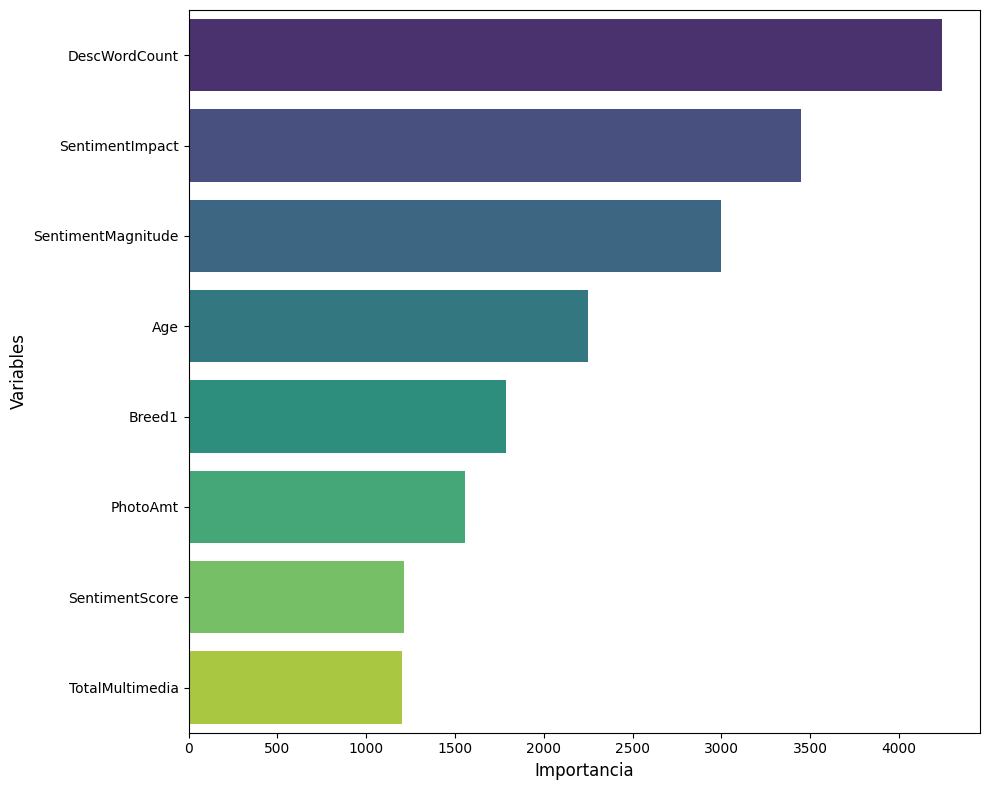

In [ ]:
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================
# 1. DEFINICIÓN DE CLASE (Necesaria para cargar el pkl)
# ==========================================
class PetFinderModel:
    def __init__(self, models, avg_cuts):
        self.models = models
        self.avg_cuts = avg_cuts

# ==========================================
# 2. RECUPERAR NOMBRES DE COLUMNAS
# ==========================================
df_headers = pd.read_csv('train_ready.csv', nrows=1)
feature_names = df_headers.drop(['AdoptionSpeed'], axis=1).columns.tolist()

print(f"✅ Nombres recuperados: {feature_names[:5]}... ({len(feature_names)} en total)")

# ==========================================
# 3. CARGAR MODELO Y EXTRAER IMPORTANCIA
# ==========================================
sistema_completo = joblib.load('modelo_final_completo.pkl')

feature_importances = pd.DataFrame()

for i, model in enumerate(sistema_completo.models):
    fold_importance = pd.DataFrame()

    fold_importance["feature"] = feature_names
    fold_importance["importance"] = model.feature_importances_
    fold_importance["fold"] = i + 1

    feature_importances = pd.concat([feature_importances, fold_importance], axis=0)

# ==========================================
# 4. GRAFICAR (Top 20 Variables)
# ==========================================
cols = (feature_importances[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:8].index)

best_features = feature_importances.loc[feature_importances.feature.isin(cols)]

plt.figure(figsize=(10, 8))
sns.barplot(
    x="importance",
    y="feature",
    data=best_features.sort_values(by="importance", ascending=False),
    palette="viridis",
    errorbar=None
)

plt.xlabel('Importancia', fontsize=12)
plt.ylabel('Variables', fontsize=12)
plt.tight_layout()
plt.show()


---

# Parte 2: Deep Learning - Redes Neuronales

---

# Deep Learning

IMPORTANTE: TODO EL CÓDIGO ESTÁ ESTRUCTURADO PARA PODER CORRER CADA CELDA INDIVIDUALMENTE (EXCEPTO LAS DE COLAB)

## Analisis del dataset y sus características

Vamos a analizar el dataset de imagenes para la entender la distribucion de las mismas y contemplar una posible reestructuración, ya sea de dimensiones, calidad o de número de imágenes, para que puedan ser procesadas correctamente.

🔍 Buscando datos desde: c:\Users\Equipo\Desktop\Machine_DL...
✅ ¡ENCONTRADO!

MASCOTA: Miki & Molly (ID: 94aec9453)
Raza:    Mixed Breed
Target:  2
--- Análisis de Sentimiento (JSON) ---
Score:     0.9 (Polaridad -1 a 1)
Magnitude: 0.9 (Intensidad)


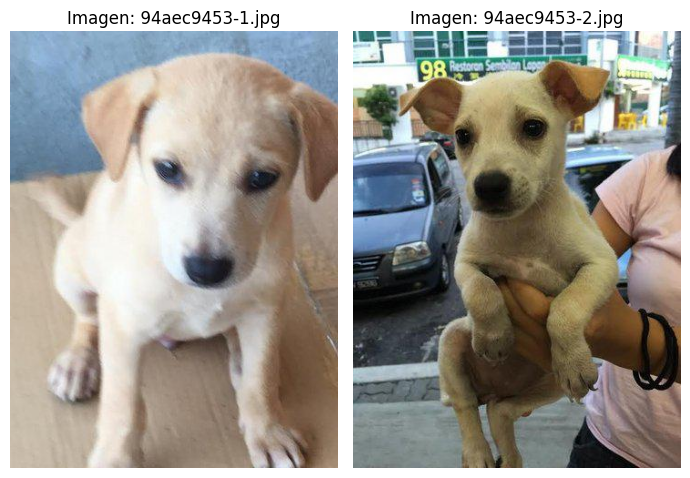

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import json 

current_dir = os.getcwd()
search_start = ".." 

print(f"🔍 Buscando datos desde: {os.path.abspath(search_start)}...")

train_path = None
root_data_folder = None

for root, dirs, files in os.walk(search_start):
    if "train.csv" in files:
        train_path = os.path.join(root, "train.csv")
        if os.path.basename(root) == 'train':
            root_data_folder = os.path.dirname(root)
        else:
            root_data_folder = root
        
        print(f"✅ ¡ENCONTRADO!")
        break

if not train_path:
    raise FileNotFoundError("❌ No se pudo localizar 'train.csv'.")

# Rutas de carpetas
TRAIN_IMG_DIR = os.path.join(root_data_folder, 'train_images')
TRAIN_JSON_DIR = os.path.join(root_data_folder, 'train_sentiment') 

train = pd.read_csv(train_path)
breeds = pd.read_csv(os.path.join(root_data_folder, 'breed_labels.csv'))
breed_dict = dict(zip(breeds['BreedID'], breeds['BreedName']))

def get_breed_name(breed_id):
    return breed_dict.get(breed_id, "Desconocido")

def visualizar_mascota(pet_id=None):
    if pet_id is None:
        pet_id = train.sample(1)['PetID'].values[0]
    
    pet_data = train[train['PetID'] == pet_id].iloc[0]
    
    print(f"\n{'='*40}")
    print(f"MASCOTA: {pet_data['Name']} (ID: {pet_id})")
    print(f"Raza:    {get_breed_name(pet_data['Breed1'])}")
    print(f"Target:  {pet_data['AdoptionSpeed']}") 

    # CARGAR DATOS DEL JSON (SENTIMIENTO) 
    json_path = os.path.join(TRAIN_JSON_DIR, f"{pet_id}.json")
    if os.path.exists(json_path):
        with open(json_path, 'r') as f:
            data = json.load(f)
            sentiment = data['documentSentiment']
            print(f"--- Análisis de Sentimiento (JSON) ---")
            print(f"Score:     {sentiment['score']} (Polaridad -1 a 1)") 
            print(f"Magnitude: {sentiment['magnitude']} (Intensidad)") 
    else:
        print(">> No se encontró archivo JSON de sentimiento.")

    # VISUALIZAR IMÁGENES
    if os.path.exists(TRAIN_IMG_DIR):
        images = [f for f in os.listdir(TRAIN_IMG_DIR) if str(pet_id) in f and f.endswith('.jpg')]
        images.sort()
        
        if images:
            n_img = len(images)
            n_cols = 2
            n_rows = (n_img + 1) // 2  # Calcula filas necesarias
            
            fig, axes = plt.subplots(n_rows, n_cols, figsize=(7, 5 * n_rows))
            axes = axes.flatten() # Aplanar para iterar 
            
            for i, img_file in enumerate(images):
                img_path = os.path.join(TRAIN_IMG_DIR, img_file)
                img = mpimg.imread(img_path)
                axes[i].imshow(img)
                axes[i].set_title(f"Imagen: {img_file}")
                axes[i].axis('off')
            
            # Ocultar ejes vacíos si el número de imágenes es impar
            for j in range(i + 1, len(axes)):
                axes[j].axis('off')
                
            plt.tight_layout()
            plt.show()
        else:
            print(">> No hay fotos para esta mascota.")
    else:
        print(f">> Carpeta de imágenes no encontrada.")

# Ejecutar
visualizar_mascota()


🐾 MASCOTA: Miki & Molly (ID: 94aec9453)
🧬 Raza:    Mixed Breed
⏱️ Target:  2 (Clase ordinal)

--- 📝 ANÁLISIS DE TEXTO (JSON) ---
Score Global:     0.9 (-1 a 1)
Magnitud Global:  0.9
Frase de ejemplo: "Cute Puppies - Miki &amp; Molly Lab Mixed Age : 2 months Dewormed Healthy &amp; Friendly Adoption Fee : RM for vaccination &amp; others"


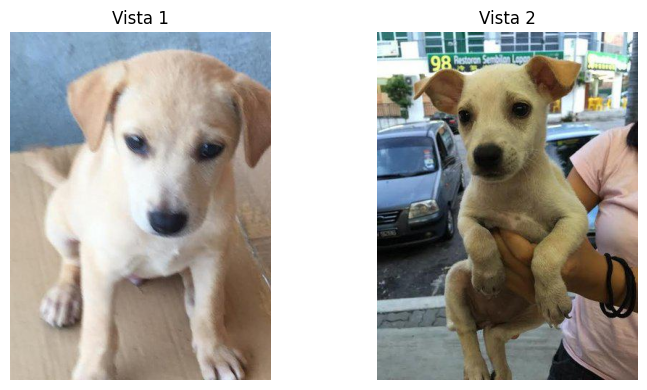

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import json 

current_dir = os.getcwd()
search_start = ".." 

train_path = None
root_data_folder = None

for root, dirs, files in os.walk(search_start):
    if "train.csv" in files:
        train_path = os.path.join(root, "train.csv")
        root_data_folder = os.path.dirname(root) if os.path.basename(root) == 'train' else root
        break

if not train_path:
    raise FileNotFoundError("❌ No se pudo localizar 'train.csv'.")

TRAIN_IMG_DIR = os.path.join(root_data_folder, 'train_images')
TRAIN_JSON_DIR = os.path.join(root_data_folder, 'train_sentiment')

# CARGA DE DATOS 
train = pd.read_csv(train_path)
breeds = pd.read_csv(os.path.join(root_data_folder, 'breed_labels.csv'))
breed_dict = dict(zip(breeds['BreedID'], breeds['BreedName']))

def get_breed_name(breed_id):
    return breed_dict.get(breed_id, "Desconocido")

# FUNCIÓN PRINCIPAL 
def visualizar_mascota(buscar_id=None):
    if buscar_id:
        if buscar_id in train['PetID'].values:
            pet_id = buscar_id
        else:
            print(f"⚠️ ID {buscar_id} no encontrado. Mostrando una aleatoria...")
            pet_id = train.sample(1)['PetID'].values[0]
    else:
        pet_id = train.sample(1)['PetID'].values[0]
    
    pet_data = train[train['PetID'] == pet_id].iloc[0]
    
    print(f"\n{'='*50}")
    print(f"🐾 MASCOTA: {pet_data['Name']} (ID: {pet_id})")
    print(f"🧬 Raza:    {get_breed_name(pet_data['Breed1'])}")
    print(f"⏱️ Target:  {pet_data['AdoptionSpeed']} (Clase ordinal)")
    
    #  CARGAR JSON 
    json_path = os.path.join(TRAIN_JSON_DIR, f"{pet_id}.json")
    if os.path.exists(json_path):
        with open(json_path, 'r') as f:
            data = json.load(f)
            sentiment = data['documentSentiment']
            print(f"\n--- 📝 ANÁLISIS DE TEXTO (JSON) ---")
            print(f"Score Global:     {sentiment['score']} (-1 a 1)")
            print(f"Magnitud Global:  {sentiment['magnitude']}")
            
            if 'sentences' in data and len(data['sentences']) > 0:
                ejemplo_frase = data['sentences'][0]['text']['content']
                print(f"Frase de ejemplo: \"{ejemplo_frase}\"")
    else:
        print("\n>> No se encontró archivo JSON de sentimiento.")

    #  VISUALIZAR
    if os.path.exists(TRAIN_IMG_DIR):
        images = [f for f in os.listdir(TRAIN_IMG_DIR) if str(pet_id) in f and f.endswith('.jpg')]
        images.sort()
        
        if images:
            n_img = len(images)
            n_cols = 2
            n_rows = (n_img + 1) // 2
            
            # Crear la figura
            fig, axes = plt.subplots(n_rows, n_cols, figsize=(8, 4 * n_rows))
            
            # Convertir axes a una lista plana sin importar la forma
            if n_img == 1:
                axes_flat = [axes]
            else:
                axes_flat = axes.flatten()
            
            for i, img_file in enumerate(images):
                img_path = os.path.join(TRAIN_IMG_DIR, img_file)
                img = mpimg.imread(img_path)
                axes_flat[i].imshow(img)
                axes_flat[i].set_title(f"Vista {i+1}")
                axes_flat[i].axis('off')
            
            # Ocultar los huecos vacíos de la cuadrícula
            for j in range(i + 1, len(axes_flat)):
                axes_flat[j].axis('off')
                
            plt.tight_layout()
            plt.show()
        else:
            print(">> No hay fotos disponibles.")
    print(f"{'='*50}\n")

# Ejecutar
visualizar_mascota(buscar_id='94aec9453')

✅ Analizando datos en: c:\Users\Equipo\Desktop\Machine_DL\datos tratados


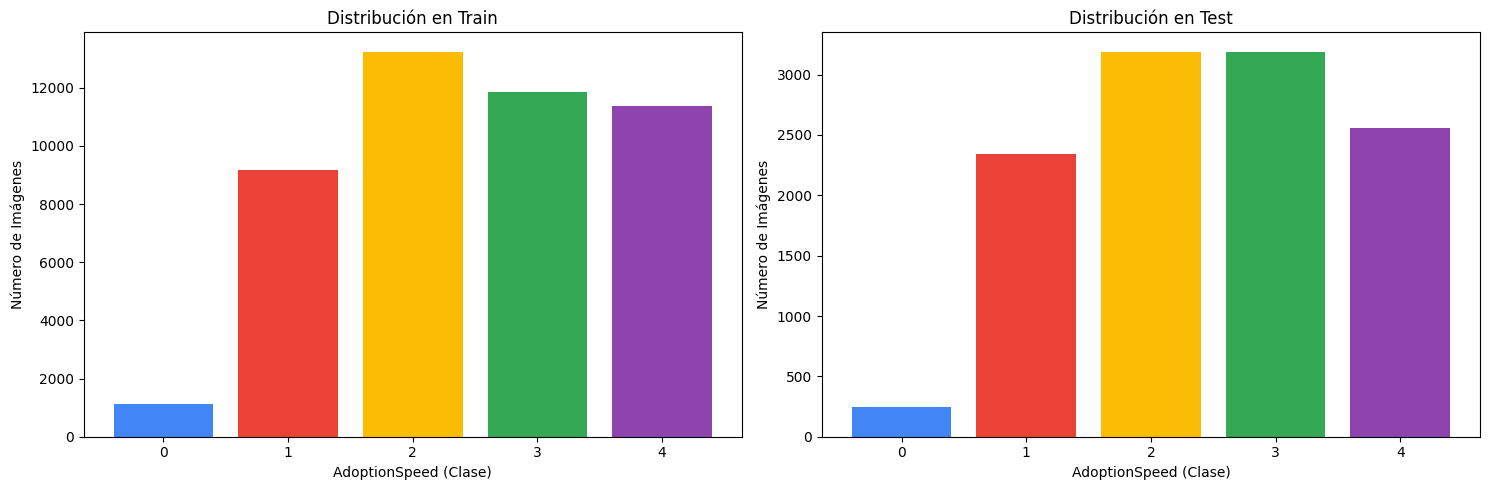

In [ ]:
import matplotlib.pyplot as plt
import os
import seaborn as sns 
def graficar_distribucion(nombre_carpeta='datos tratados'):
    #  Detección de ruta
    if os.path.exists(nombre_carpeta):
        base_path = nombre_carpeta
    elif os.path.exists(os.path.join(r'G:\Mi unidad\Mascotas', nombre_carpeta)):
        base_path = os.path.join(r'G:\Mi unidad\Mascotas', nombre_carpeta) 
    else:
        print(f"❌ No se encuentra la carpeta '{nombre_carpeta}'")
        return

    print(f"✅ Analizando datos en: {os.path.abspath(base_path)}")

    sets = ['Train', 'Test']
    clases = ['0', '1', '2', '3', '4']
    colores = ['#4285F4', '#EA4335', '#FBBC05', '#34A853', '#8E44AD']
    
    fig, ax = plt.subplots(1, 2, figsize=(15, 6)) 
    
    for i, s in enumerate(sets):
        counts = []
        for c in clases:
            path = os.path.join(base_path, s, c)
            if os.path.exists(path):
                # Solo contamos archivos, no carpetas
                counts.append(len([f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]))
            else:
                counts.append(0)
        
        bars = ax[i].bar(clases, counts, color=colores, edgecolor='black', alpha=0.8)
        ax[i].set_title(f'Distribución en {s}', fontsize=14, fontweight='bold')
        ax[i].set_xlabel('AdoptionSpeed (Clase)', fontsize=12)
        ax[i].set_ylabel('Número de Imágenes', fontsize=12)
        ax[i].grid(axis='y', linestyle='--', alpha=0.6)
        
        # Añadir el número total encima de cada barra
        for bar in bars:
            height = bar.get_height()
            ax[i].annotate(f'{height}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # 3 puntos de offset vertical
                        textcoords="offset points",
                        ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.show()

graficar_distribucion()

🔍 Analizando subcarpetas en: G:\Mi unidad\Mascotas\datos tratados\Train
📁 Procesando clase 0 (1045 imágenes)...


100%|██████████| 1045/1045 [00:09<00:00, 107.57it/s]


📁 Procesando clase 1 (8672 imágenes)...


100%|██████████| 8672/8672 [01:26<00:00, 100.63it/s]


📁 Procesando clase 2 (12145 imágenes)...


100%|██████████| 12145/12145 [02:09<00:00, 93.83it/s] 


📁 Procesando clase 3 (10614 imágenes)...


100%|██████████| 10614/10614 [01:27<00:00, 121.66it/s]


📁 Procesando clase 4 (10364 imágenes)...


100%|██████████| 10364/10364 [01:40<00:00, 103.42it/s]


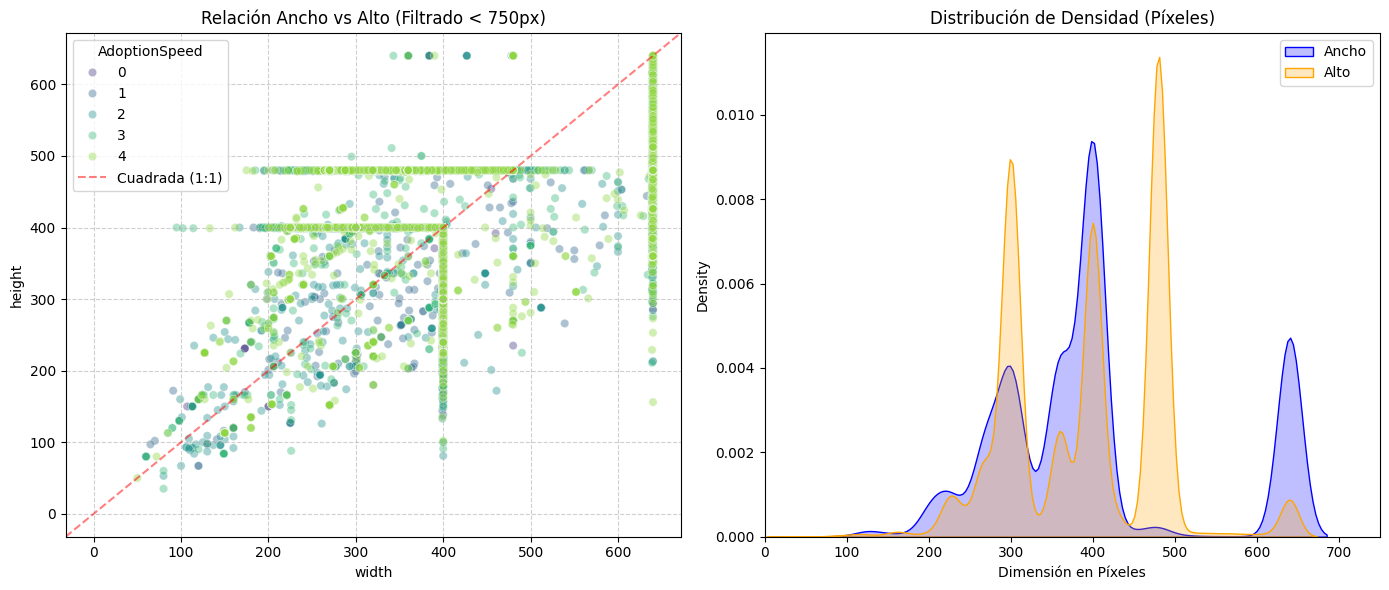


📊 Resumen de Resoluciones (Sin Outliers):
              width        height
count  42839.000000  42839.000000
mean     399.001704    390.319172
std      126.332044     93.350147
min       50.000000     35.000000
25%      300.000000    300.000000
50%      400.000000    400.000000
75%      400.000000    480.000000
max      640.000000    640.000000

📏 Relación de aspecto media: 1.07

📈 Imágenes analizadas por clase:
class
0     1045
1     8672
2    12145
3    10614
4    10363
Name: count, dtype: int64


In [ ]:
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm 

# CONFIGURACIÓN DE RUTAS 
directorio = r'G:\Mi unidad\Mascotas\datos tratados\Train'

if not os.path.exists(directorio):
    print(f"❌ Error: No se encuentra la carpeta en {os.path.abspath(directorio)}")
    raise FileNotFoundError

print(f"🔍 Analizando subcarpetas en: {os.path.abspath(directorio)}")

# -RECOLECCIÓN RECURSIVA DE DIMENSIONES 
resoluciones = []


for root, dirs, files in os.walk(directorio):
    
    fotos = [f for f in files if f.lower().endswith(('.jpg', '.jpeg'))]
    
    if fotos:
        print(f"📁 Procesando clase {os.path.basename(root)} ({len(fotos)} imágenes)...")
        for archivo in tqdm(fotos):
            path_completo = os.path.join(root, archivo)
            try:
                with Image.open(path_completo) as img:
                    ancho, alto = img.size
                    resoluciones.append({'width': ancho,'height': alto,
                    'class': os.path.basename(root)
                    })
            except:
                continue

# Creamos el DataFrame
df_res = pd.DataFrame(resoluciones)

if df_res.empty:
    print("❌ No se encontraron imágenes. Verifica las rutas.")
else:
    # FILTRO DE OUTLIERS (Límite 750px) 
    df_res = df_res[(df_res['width'] <= 750) & (df_res['height'] <= 750)]

    # VISUALIZACIÓN GRÁFICA 
    plt.figure(figsize=(14, 6))

    # Subplot 1: Distribución Conjunta por Clase
    plt.subplot(1, 2, 1)
    sns.scatterplot(data=df_res, x='width', y='height', hue='class', alpha=0.4, palette='viridis')
    plt.title('Relación Ancho vs Alto (Filtrado < 750px)')
    plt.axline((0, 0), slope=1, color='red', linestyle='--', alpha=0.5, label='Cuadrada (1:1)')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(title='AdoptionSpeed')

    # Subplot 2: Histogramas de densidad
    plt.subplot(1, 2, 2)
    sns.kdeplot(data=df_res, x='width', fill=True, color='blue', label='Ancho')
    sns.kdeplot(data=df_res, x='height', fill=True, color='orange', label='Alto')
    plt.title('Distribución de Densidad (Píxeles)')
    plt.xlabel('Dimensión en Píxeles')
    plt.xlim(0, 750)
    plt.legend()

    plt.tight_layout()
    plt.show()

    # ESTADÍSTICAS 
    print("\n📊 Resumen de Resoluciones (Sin Outliers):")
    print(df_res[['width', 'height']].describe())

    df_res['aspect_ratio'] = df_res['width'] / df_res['height']
    print(f"\n📏 Relación de aspecto media: {df_res['aspect_ratio'].mean():.2f}")
    
    # Conteo por clase para verificar balance
    print("\n📈 Imágenes analizadas por clase:")
    print(df_res['class'].value_counts().sort_index())

## Red Neuronal desde 0

En esta sección, implementaremos una Red Neuronal Convolucional (CNN) diseñada para clasificar imágenes de mascotas según su tiempo de adopción. Para agilizar el desarrollo y las pruebas de arquitectura, utilizaremos el mini_dataset (una versión reducida al 3% y balanceada), con el objetivo de escalar los resultados al dataset completo una vez validado el modelo. El flujo se ejecuta conectando directamente con Google Drive porque ciertas partes del código se ejecutaron en google colab para aprovechar su capacidad de computación.

La métrica clave para evaluar este modelo será el Quadratic Weighted Kappa (QWK). A diferencia del accuracy convencional, el QWK es  muy útil en este caso porque el dataset original está desbalanceado y tiene un carácter ordinal (las clases van del 0 al 4). Esta métrica no solo nos dice si el modelo acertó, sino que penaliza más los errores "lejanos" (por ejemplo, predecir que una mascota se adoptará de inmediato cuando en realidad pertenece a la categoría de no adoptada ), ofreciéndonos una visión mucho más fiel del rendimiento real del modelo frente a los datos.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
ℹ️ La carpeta 'mini_dataset' ya existe. Saltando creación.
📊 Analizando distribución en: /content/drive/MyDrive/Mascotas/mini_dataset


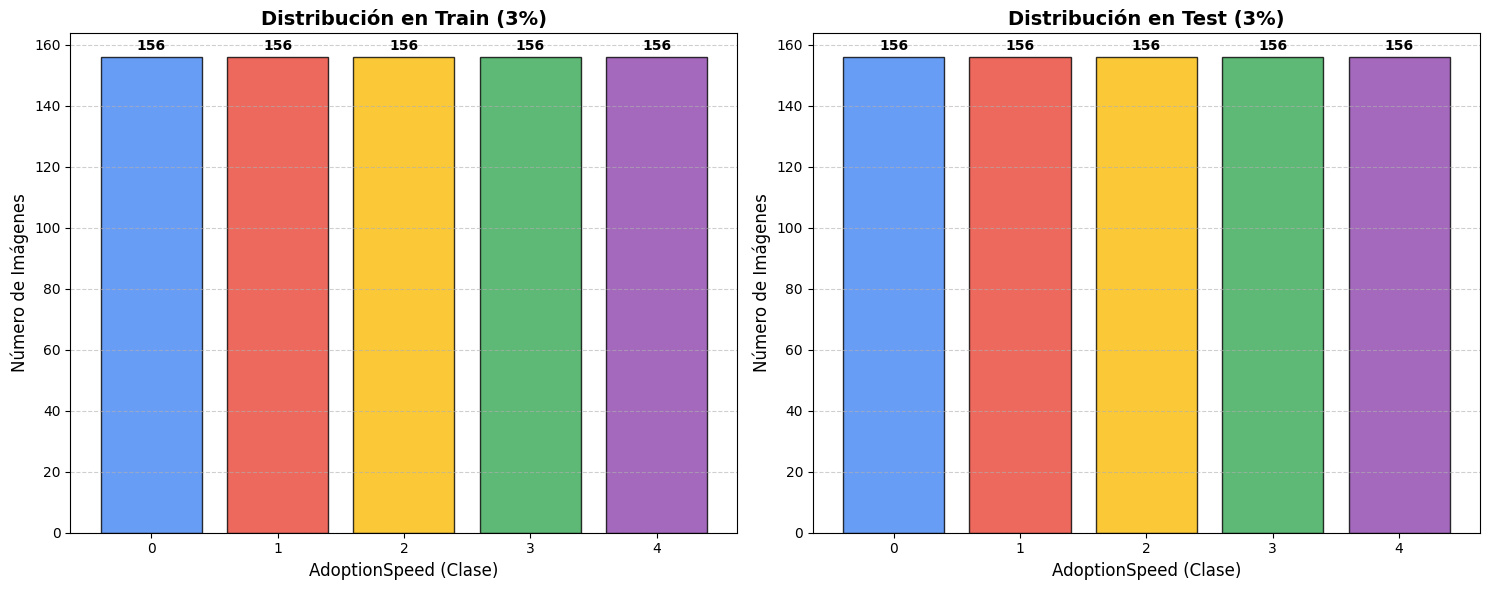

In [21]:
import matplotlib.pyplot as plt
import os
import seaborn as sns
import shutil
import random
from google.colab import drive

# Conectamos con Google Drive para acceder a las carpetas
drive.mount('/content/drive')

def crear_y_graficar_mini_dataset2(porcentaje=0.03):
    # Traducción de la ruta de Windows a la ruta de Google Colab
    base_dir = '/content/drive/MyDrive/Mascotas'
    origen = os.path.join(base_dir, 'datos tratados')
    destino = os.path.join(base_dir, 'mini_dataset')

    # Comprobación de existencia para evitar duplicar el proceso
    if not os.path.exists(destino):
        print(f"📂 Creando '{destino}' seleccionando el {porcentaje*100}% de imágenes...")

        sets = ['Train', 'Test']
        clases = ['0', '1', '2', '3', '4']

        for s in sets:
            for c in clases:
                path_origen = os.path.join(origen, s, c)
                path_destino = os.path.join(destino, s, c)

                if os.path.exists(path_origen):
                    # Creación de la estructura de subcarpetas por clase
                    os.makedirs(path_destino, exist_ok=True)

                    # Obtención de la lista de archivos de imagen
                    imagenes = [f for f in os.listdir(path_origen) if os.path.isfile(os.path.join(path_origen, f))]

                    # Cálculo del subconjunto (mínimo 1 imagen para evitar carpetas vacías)
                    cantidad_a_copiar = max(1, int(len(imagenes) * porcentaje)) if imagenes else 0

                    # Selección aleatoria para mantener la representatividad
                    seleccion = random.sample(imagenes, cantidad_a_copiar)

                    # Copia física de los archivos seleccionados
                    for img in seleccion:
                        shutil.copy(os.path.join(path_origen, img), os.path.join(path_destino, img))

        print("✅ Proceso de copia finalizado.")
    else:
        print(f"ℹ️ La carpeta 'mini_dataset' ya existe. Saltando creación.")

    # Invocación de la visualización sobre el nuevo subconjunto
    graficar_distribucion('mini_dataset')

def graficar_distribucion(nombre_carpeta='mini_dataset'):
    # Ajuste de rutas para entorno local o Drive
    base_path_local = nombre_carpeta
    base_path_drive = os.path.join('/content/drive/MyDrive/Mascotas', nombre_carpeta)

    if os.path.exists(base_path_local):
        base_path = base_path_local
    elif os.path.exists(base_path_drive):
        base_path = base_path_drive
    else:
        print(f"❌ No se encuentra la carpeta '{nombre_carpeta}'")
        return

    print(f"📊 Analizando distribución en: {os.path.abspath(base_path)}")

    sets = ['Train', 'Test']
    clases = ['0', '1', '2', '3', '4']
    colores = ['#4285F4', '#EA4335', '#FBBC05', '#34A853', '#8E44AD']

    fig, ax = plt.subplots(1, 2, figsize=(15, 6))

    for i, s in enumerate(sets):
        counts = []
        for c in clases:
            path = os.path.join(base_path, s, c)
            if os.path.exists(path):
                # Conteo de archivos válidos en cada directorio de clase
                counts.append(len([f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]))
            else:
                counts.append(0)

        # Generación del gráfico de barras
        bars = ax[i].bar(clases, counts, color=colores, edgecolor='black', alpha=0.8)
        ax[i].set_title(f'Distribución en {s} (3%)', fontsize=14, fontweight='bold')
        ax[i].set_xlabel('AdoptionSpeed (Clase)', fontsize=12)
        ax[i].set_ylabel('Número de Imágenes', fontsize=12)
        ax[i].grid(axis='y', linestyle='--', alpha=0.6)

        # Inserción de etiquetas numéricas sobre las barras
        for bar in bars:
            height = bar.get_height()
            ax[i].annotate(f'{height}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.show()

# Ejecución del flujo de preparación de datos
crear_y_graficar_mini_dataset2()

### Exploración de hiperparámetros

En este bloque definimos una Red Neuronal Convolucional (CNN) sencilla encargada de extraer características visuales de las imágenes y clasificarlas en las 5 categorías. Configuramos un flujo de preprocesamiento que ajusta el tamaño de las imágenes a 224x224 píxeles y las normaliza para facilitar el aprendizaje del modelo, aunque con una red tan sencilla no esperamos obtener nada.


#### Learning Rates

Primero experimentaremos comparando varios de Learning Rates. Entrenamos el mismo modelo con tres ' lr ' distintas (0.001, 0.0001 y 0.00001) para observar cuál logra el mejor equilibrio entre rapidez y precisión. Al final, visualizamos la evolución de la pérdida y métricas como el Accuracy y el Kappa de Cohen (QWK) y con matrices de confusión para ver exactamente dónde se equivoca el modelo.


🚀 Iniciando Experimento: LR = 0.001


Entrenando LR 0.001: 100%|██████████| 20/20 [07:03<00:00, 21.19s/it]



🚀 Iniciando Experimento: LR = 0.0001


Entrenando LR 0.0001: 100%|██████████| 20/20 [07:10<00:00, 21.51s/it]



🚀 Iniciando Experimento: LR = 1e-05


Entrenando LR 1e-05: 100%|██████████| 20/20 [07:02<00:00, 21.11s/it]


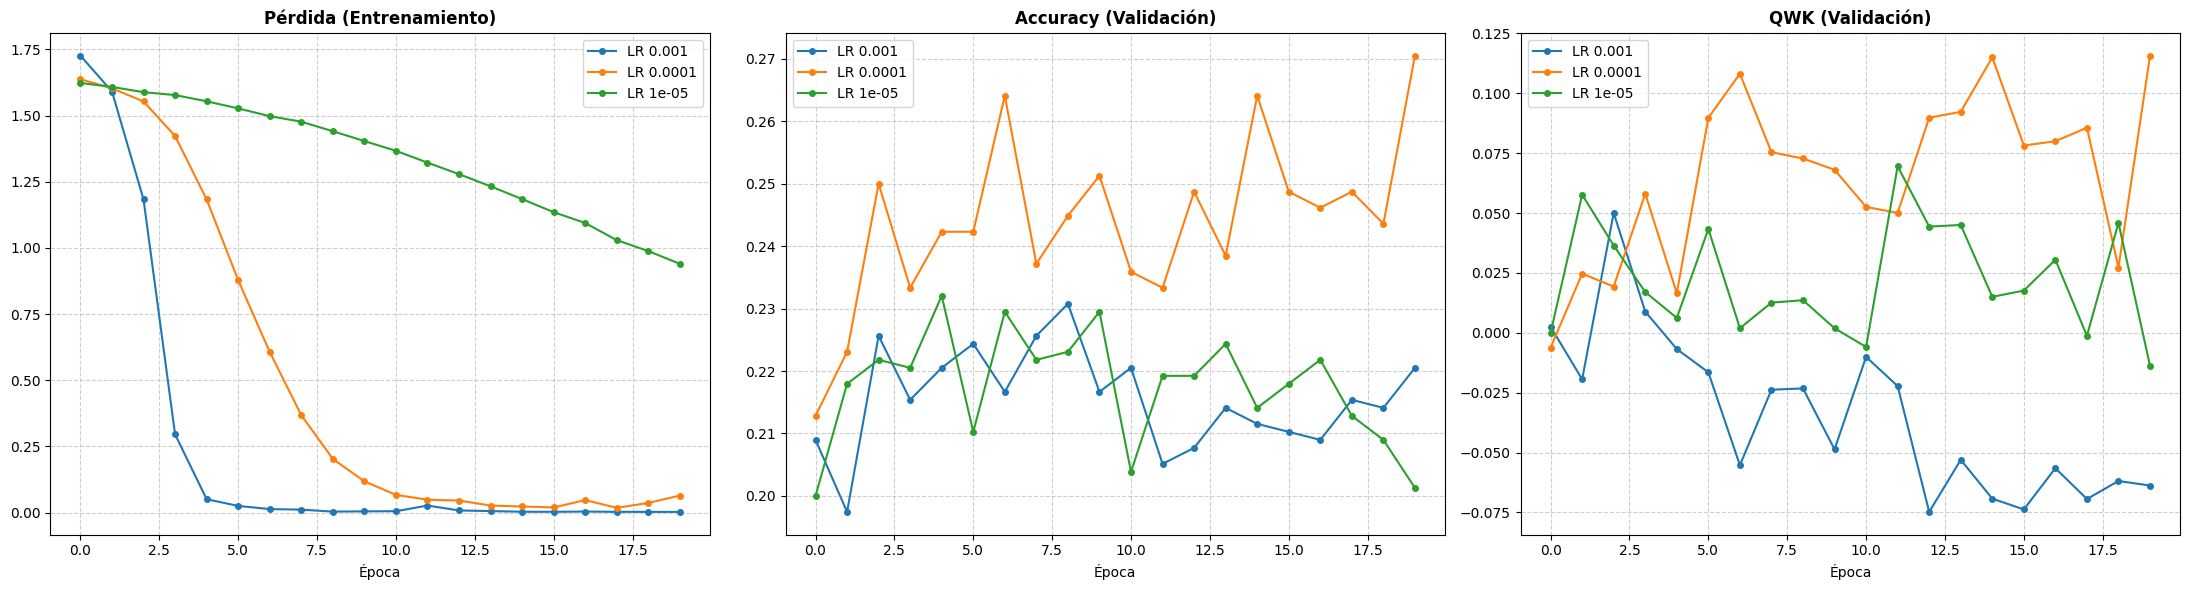

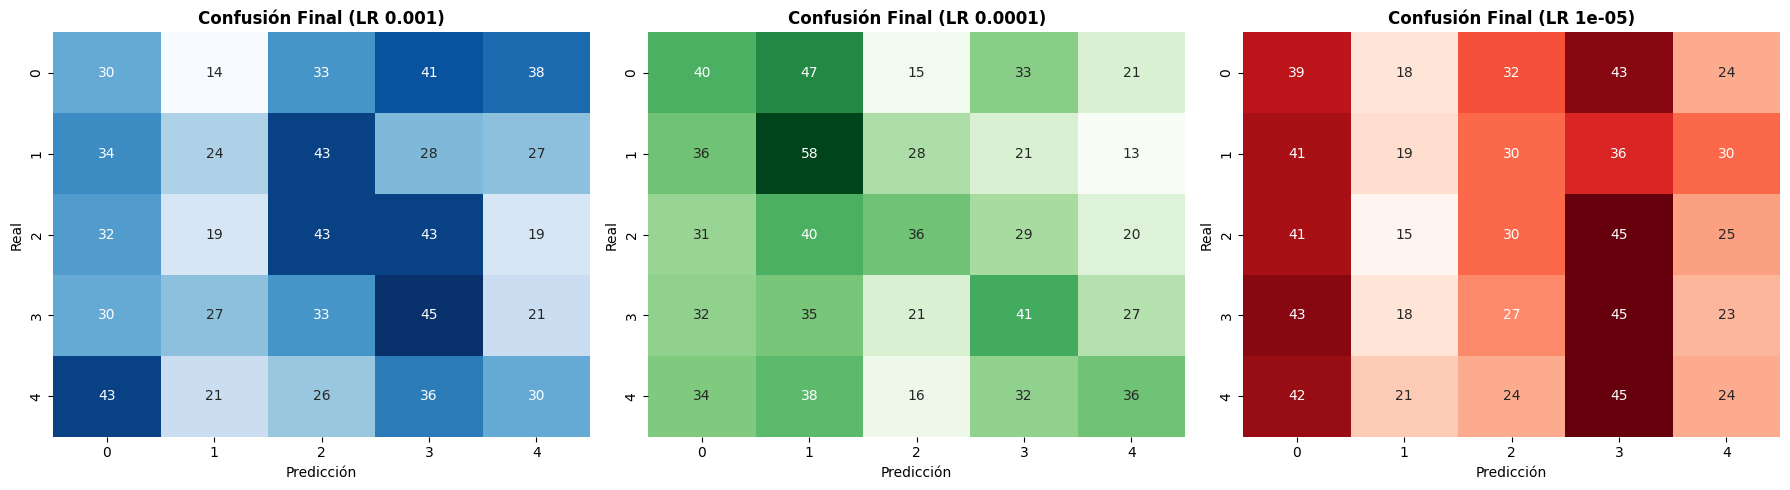


   RESUMEN FINAL: PICO MÁXIMO DE QWK POR LEARNING RATE


Learning Rate  Mejor QWK  Época  Accuracy Asociado  Tiempo (s)
0        0.00100     0.0500      3             0.2256       61.16
1        0.00010     0.1157     20             0.2705      430.13
2        0.00001     0.0695     12             0.2192      256.28

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, cohen_kappa_score, confusion_matrix
from tqdm.auto import tqdm

# Configuración de dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ARQUITECTURA CNN 
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=5):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 56 * 56, 128), nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.classifier(self.features(x))

# CONFIGURACIÓN DE DATOS
base_datos_drive = r'G:\Mi unidad\Mascotas\mini_dataset'
train_dir = os.path.join(base_datos_drive, 'Train')
test_dir = os.path.join(base_datos_drive, 'Test')

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)
val_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# EXPERIMENTO DE LEARNING RATES 
def exp_lr_comparison():
    lrs = [0.001, 0.0001, 0.00001]
    histories = {lr: {"loss": [], "acc": [], "qwk": [], "times": []} for lr in lrs}
    all_cms = []
    
    batch_size = 4
    num_epochs = 20
    criterion = nn.CrossEntropyLoss()

    for lr in lrs:
        print(f"\n🚀 Iniciando Experimento: LR = {lr}")
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        model = SimpleCNN().to(device)
        optimizer = optim.Adam(model.parameters(), lr=lr) 
        
        start_t = time.time()
        
        for epoch in tqdm(range(num_epochs), desc=f"Entrenando LR {lr}"):
            # FASE DE ENTRENAMIENTO 
            model.train()
            epoch_loss = 0
            for imgs, labels in train_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(imgs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()
            
            #  FASE DE VALIDACIÓN 
            model.eval()
            val_preds, val_targets = [], []
            with torch.no_grad():
                for imgs, labels in val_loader:
                    imgs, labels = imgs.to(device), labels.to(device)
                    out = model(imgs)
                    val_preds.extend(torch.max(out, 1)[1].cpu().tolist())
                    val_targets.extend(labels.cpu().tolist())
            
            # Guardar métricas
            histories[lr]["loss"].append(epoch_loss / len(train_loader))
            histories[lr]["acc"].append(accuracy_score(val_targets, val_preds))
            histories[lr]["qwk"].append(cohen_kappa_score(val_targets, val_preds, weights='quadratic'))
            histories[lr]["times"].append(time.time() - start_t)
        
        all_cms.append(confusion_matrix(val_targets, val_preds))

    # VISUALIZACIÓN DE EVOLUCIÓN 
    fig, axes = plt.subplots(1, 3, figsize=(22, 6))
    metrics_to_plot = ["loss", "acc", "qwk"]
    titles = ["Pérdida (Entrenamiento)", "Accuracy (Validación)", "QWK (Validación)"]
    
    for i, m in enumerate(metrics_to_plot):
        for lr in lrs:
            axes[i].plot(histories[lr][m], label=f"LR {lr}", marker='o', markersize=4)
        axes[i].set_title(titles[i], fontweight='bold')
        axes[i].set_xlabel('Época')
        axes[i].grid(True, linestyle='--', alpha=0.6)
        axes[i].legend()
    plt.tight_layout()
    plt.show()

    #  MATRICES DE CONFUSIÓN 
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    colors = ["Blues", "Greens", "Reds"]
    for i, lr in enumerate(lrs):
        sns.heatmap(all_cms[i], annot=True, fmt='d', ax=axes[i], cmap=colors[i], cbar=False)
        axes[i].set_title(f"Confusión Final (LR {lr})", fontweight='bold')
        axes[i].set_xlabel('Predicción')
        axes[i].set_ylabel('Real')
    plt.tight_layout()
    plt.show()

    # RESUMEN DE PICOS QWK 
    res_picos = []
    for lr in lrs:
        qwk_hist = np.array(histories[lr]["qwk"])
        acc_hist = np.array(histories[lr]["acc"])
        time_hist = np.array(histories[lr]["times"])
        
        # Encontrar el índice del valor máximo de QWK
        idx_pico = np.argmax(qwk_hist)
        
        res_picos.append({
            "Learning Rate": lr,
            "Mejor QWK": round(qwk_hist[idx_pico], 4),
            "Época": idx_pico + 1,
            "Accuracy Asociado": round(acc_hist[idx_pico], 4),
            "Tiempo (s)": round(time_hist[idx_pico], 2)
        })
        
    return pd.DataFrame(res_picos)

df_resumen = exp_lr_comparison()
print("\n" + "="*70)
print("   RESUMEN FINAL: PICO MÁXIMO DE QWK POR LEARNING RATE")
print("="*70)
display(df_resumen)

Los resultados muestran que en el entrenamiento:
- LR 0.001 es demasiado agresivo, haciendo que la pérdida caiga en picado pero destruyendo la capacidad de generalización (el QWK cae a valores negativos, lo que indica que predice peor que el azar);
- LR 1e-05 es excesivamente lento, mostrando una curva de pérdida casi lineal que sugiere que necesitaría muchísimas más épocas para llegar a algo sólido. 
- Sin embargo,el LR 0.0001 presenta una evolución más estable y alcanza los picos más altos tanto en Accuracy como en QWK.

Al observar las matrices de confusión, confirmamos que el modelo con LR 0.0001 es el que mejor logra "dibujar" la diagonal principal. Sin embargo, el rendimiento general sigue siendo bajo (Accuracy cercano al 27%), lo cual es normal considerando que estamos entrenando una red simple con apenas el 3% de los datos. 

#### Batch size

Estudiaremos ahora cómo influye el Batch Size en la estabilidad y convergencia de nuestra red. Al probar configuraciones de 4, 8 y 16 imágenes por iteración, analizamos la dinámica de las actualizaciones de gradiente bajo la función de pérdida CrossEntropyLoss. El objetivo es medir no solo la precisión final, sino también la eficiencia temporal y la estabilidad de la métrica QWK, determinando qué nivel de ruido estocástico beneficia más al modelo.



c:\Users\Equipo\Desktop\Machine_DL\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



🚀 Iniciando Experimento: Batch Size = 4


Progreso Total B=4: 100%|██████████| 20/20 [08:35<00:00, 25.79s/it, Loss=0.0170, QWK=0.0782]



🚀 Iniciando Experimento: Batch Size = 8


Progreso Total B=8: 100%|██████████| 20/20 [08:22<00:00, 25.11s/it, Loss=0.0241, QWK=0.0627]



🚀 Iniciando Experimento: Batch Size = 16


Progreso Total B=16: 100%|██████████| 20/20 [08:08<00:00, 24.41s/it, Loss=0.0204, QWK=0.0646]


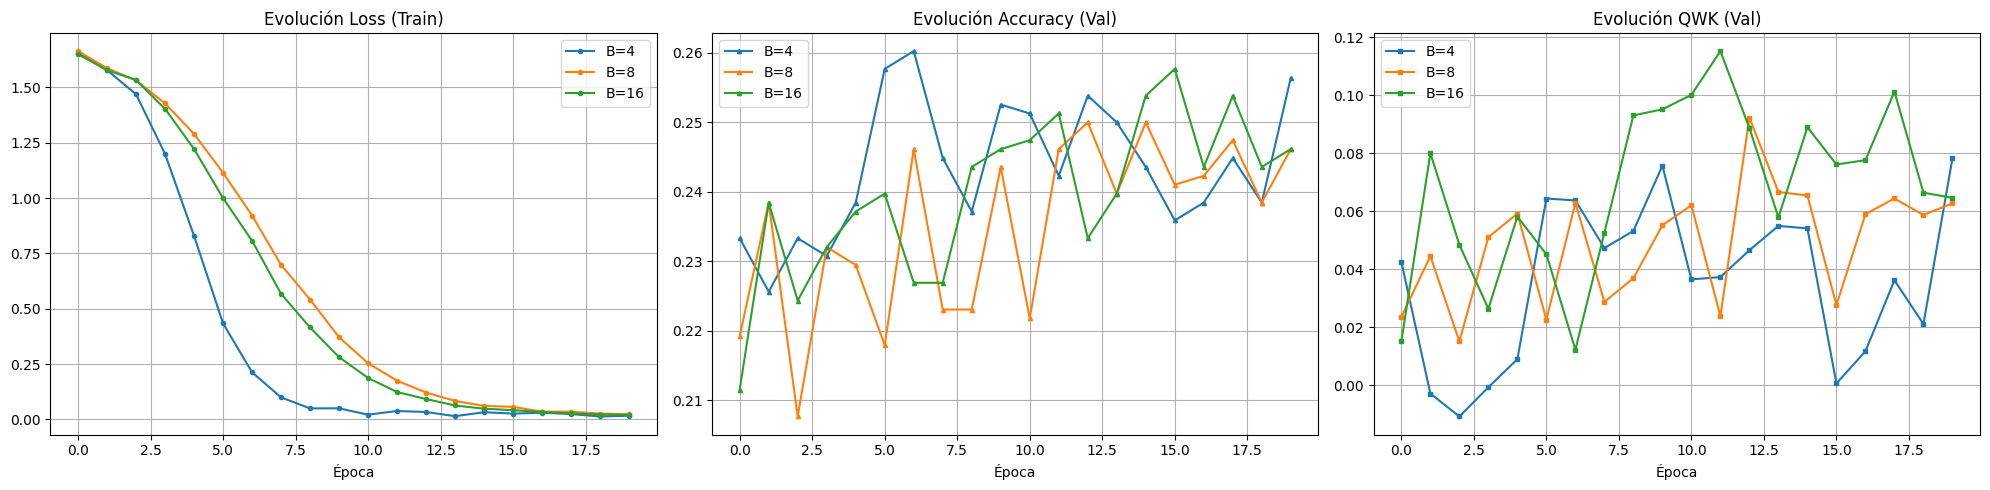


    RESUMEN FINAL: MEJOR RENDIMIENTO QWK POR BATCH SIZE (Cross Entropy)


Batch Size  Mejor QWK  Época  Accuracy Asociado  Tiempo (s)
0           4     0.0782     20             0.2564      515.88
1           8     0.0922     13             0.2500      326.44
2          16     0.1152     12             0.2513      301.44

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, cohen_kappa_score, confusion_matrix
from tqdm.auto import tqdm

# ARQUITECTURA CNN
# Definimos una red convolucional sencilla para procesar las imágenes de mascotas
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=5):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 56 * 56, 128), nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.classifier(self.features(x))

# CONFIGURACIÓN DE DATOS
# Establecemos las rutas y transformaciones necesarias para el preprocesamiento
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_datos_drive = r'G:\Mi unidad\Mascotas\mini_dataset'
train_dir = os.path.join(base_datos_drive, 'Train')
test_dir = os.path.join(base_datos_drive, 'Test')

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)
val_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Evaluamos cómo influye el tamaño de lote en la convergencia del modelo
def exp_batch_comparison():
    batch_sizes = [4, 8, 16]
    lr_fijo = 0.0001
    epochs = 20 
    
    # Historial para almacenar métricas por cada configuración de batch
    histories = {b: {"loss": [], "acc": [], "qwk": [], "times": []} for b in batch_sizes}
    all_cms = []

    for b_size in batch_sizes:
        print(f"\n🚀 Iniciando Experimento: Batch Size = {b_size}")
        train_loader = DataLoader(train_dataset, batch_size=b_size, shuffle=True)
        model = SimpleCNN().to(device)
        optimizer = optim.Adam(model.parameters(), lr=lr_fijo)
        
        # Sustituimos la pérdida anterior por CrossEntropyLoss estándar
        criterion = nn.CrossEntropyLoss()
        
        start_t = time.time()
        pbar = tqdm(range(epochs), desc=f"Progreso Total B={b_size}")
        
        for epoch in pbar:
            # Entrenamiento
            model.train()
            epoch_loss = 0
            for imgs, labels in train_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                optimizer.zero_grad(set_to_none=True)
                outputs = model(imgs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()
            
            # Validación por época
            model.eval()
            val_preds, val_targets = [], []
            with torch.no_grad():
                for imgs, labels in val_loader:
                    imgs, labels = imgs.to(device), labels.to(device)
                    out = model(imgs)
                    # Obtenemos la clase con mayor probabilidad
                    val_preds.extend(torch.max(out, 1)[1].cpu().tolist())
                    val_targets.extend(labels.cpu().tolist())
            
            # Registro de métricas para análisis posterior
            avg_loss = epoch_loss / len(train_loader)
            current_acc = accuracy_score(val_targets, val_preds)
            current_qwk = cohen_kappa_score(val_targets, val_preds, weights='quadratic')
            
            histories[b_size]["loss"].append(avg_loss)
            histories[b_size]["acc"].append(current_acc)
            histories[b_size]["qwk"].append(current_qwk)
            histories[b_size]["times"].append(time.time() - start_t)
            
            pbar.set_postfix({'Loss': f'{avg_loss:.4f}', 'QWK': f'{current_qwk:.4f}'})
        
        all_cms.append(confusion_matrix(val_targets, val_preds))

    # VISUALIZACIÓN DE EVOLUCIÓN
    # Generamos las gráficas comparativas de rendimiento
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    for b in batch_sizes:
        axes[0].plot(histories[b]["loss"], label=f'B={b}', marker='o', markersize=3)
        axes[1].plot(histories[b]["acc"], label=f'B={b}', marker='^', markersize=3)
        axes[2].plot(histories[b]["qwk"], label=f'B={b}', marker='s', markersize=3)
    
    axes[0].set_title('Evolución Loss (Train)'); axes[0].set_xlabel('Época'); axes[0].legend(); axes[0].grid(True)
    axes[1].set_title('Evolución Accuracy (Val)'); axes[1].set_xlabel('Época'); axes[1].legend(); axes[1].grid(True)
    axes[2].set_title('Evolución QWK (Val)'); axes[2].set_xlabel('Época'); axes[2].legend(); axes[2].grid(True)
    plt.tight_layout()
    plt.show()

    # RESUMEN DE MEJORES RESULTADOS
    # Extraemos el punto de mayor rendimiento para cada tamaño de batch
    res_list = []
    for b in batch_sizes:
        qwk_hist = np.array(histories[b]["qwk"])
        acc_hist = np.array(histories[b]["acc"])
        time_hist = np.array(histories[b]["times"])
        
        idx_pico = np.argmax(qwk_hist)
        
        res_list.append({
            "Batch Size": b,
            "Mejor QWK": round(qwk_hist[idx_pico], 4),
            "Época": idx_pico + 1,
            "Accuracy Asociado": round(acc_hist[idx_pico], 4),
            "Tiempo (s)": round(time_hist[idx_pico], 2)
        })
    
    return pd.DataFrame(res_list)

# Ejecución y visualización del resumen final
df_resumen_batches = exp_batch_comparison()
print("\n" + "="*75)
print("    RESUMEN FINAL: MEJOR RENDIMIENTO QWK POR BATCH SIZE (Cross Entropy)")
print("="*75)
display(df_resumen_batches)

Los resultados obtenidos muestran que el Batch Size 16 es la configuración más efectiva, alcanzando el mejor valor de QWK (0.1152) en casi la mitad de tiempo que el lote más pequeño. Se observa una tendencia clara: conforme aumentamos el tamaño del lote, el modelo no solo converge más rápido (alcanzando su pico en la época 12 frente a la 20), sino que también logra una mayor estabilidad en el aprendizaje. 


Sin embargo, el Accuracy se mantiene estancado en torno al 25% en todos los casos; esto sugiere que, aunque el tamaño de lote optimiza la eficiencia del entrenamiento, la arquitectura SimpleCNN por sí sola no es suficiente para capturar la complejidad del dataset, o almenos con esta versión reducida del mismo.

#### Loss Function

En este experimento evaluamos tres funciones de pérdida con naturalezas estadísticas distintas para determinar cuál captura mejor la jerarquía de las etiquetas. 
- CrossEntropyLoss es el estándar de clasificación que minimiza la divergencia entre distribuciones, pero trata las clases como categorías independientes (confundir 0 con 1 es tan grave como 0 con 4).
- MSE (Ordinal) transforma el problema en una regresión ponderada, calculando el valor esperado de la predicción ($\sum p_i \cdot i$) y penalizando la distancia euclídea al objetivo real.
- SoftKappa (QWKLoss), una función personalizada que utiliza una matriz de pesos cuadráticos $W_{ij} = (i-j)^2$ para penalizar los errores según su "lejanía" en la escala de adopción, diferenciando matemáticamente entre un error leve y uno camplio.

Esta comparativa es puede resultar útil porque el dataset de PetFinder es de naturaleza ordinal: la diferencia entre una adopción inmediata (0) y una tardía (4) representa un espectro temporal, no solo etiquetas distintas. Al integrar la noción de distancia en el entrenamiento, esperamos que el modelo deje de realizar predicciones aleatorias y comience a concentrar sus fallos cerca de la diagonal principal de la matriz de confusión. El objetivo es evualuar que función de perdida es capaz de obtener un valor de QWK superior.



🚀 Evaluando Loss: CrossEntropy


Progreso CrossEntropy: 100%|██████████| 20/20 [09:36<00:00, 28.85s/it, Loss=0.0269, QWK=-0.0070]



🚀 Evaluando Loss: MSE (Ordinal)


Progreso MSE (Ordinal): 100%|██████████| 20/20 [09:22<00:00, 28.13s/it, Loss=1.7710, QWK=0.0061] 



🚀 Evaluando Loss: SoftKappa (QWK)


Progreso SoftKappa (QWK): 100%|██████████| 20/20 [09:47<00:00, 29.36s/it, Loss=0.3974, QWK=0.0534]


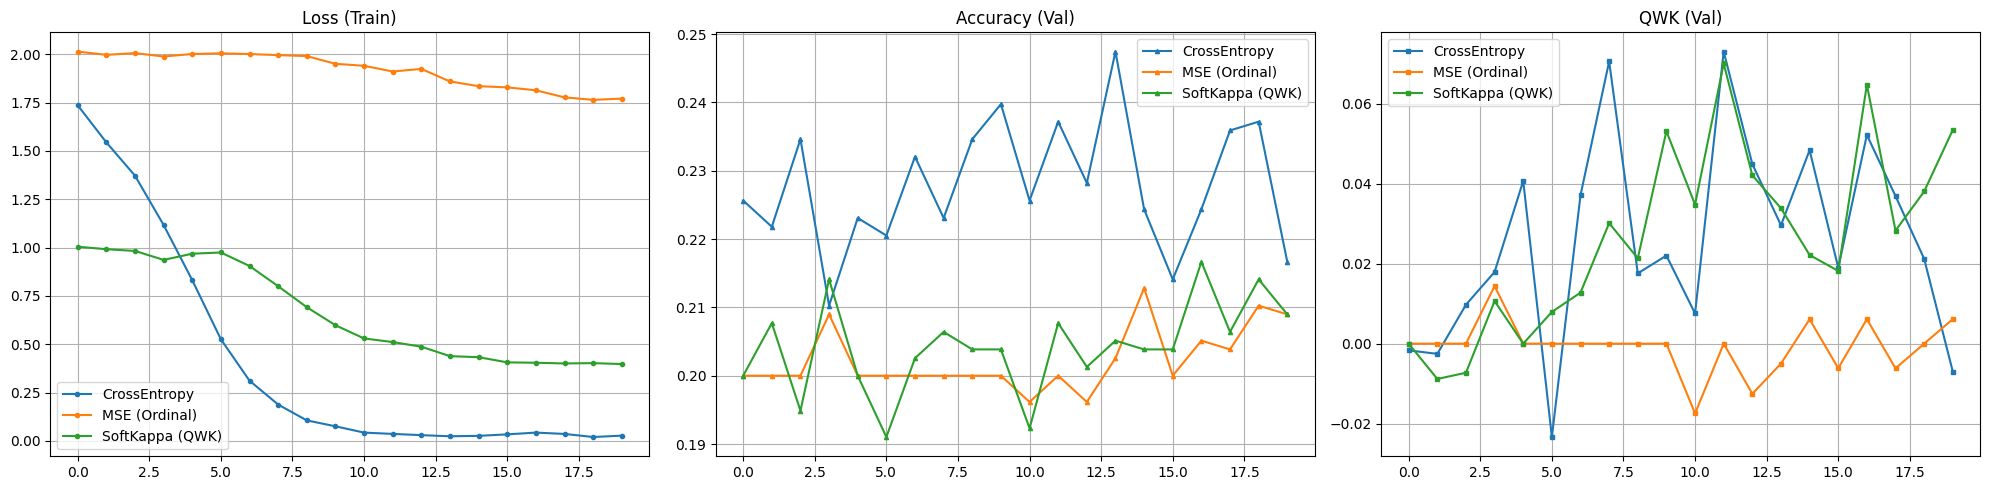

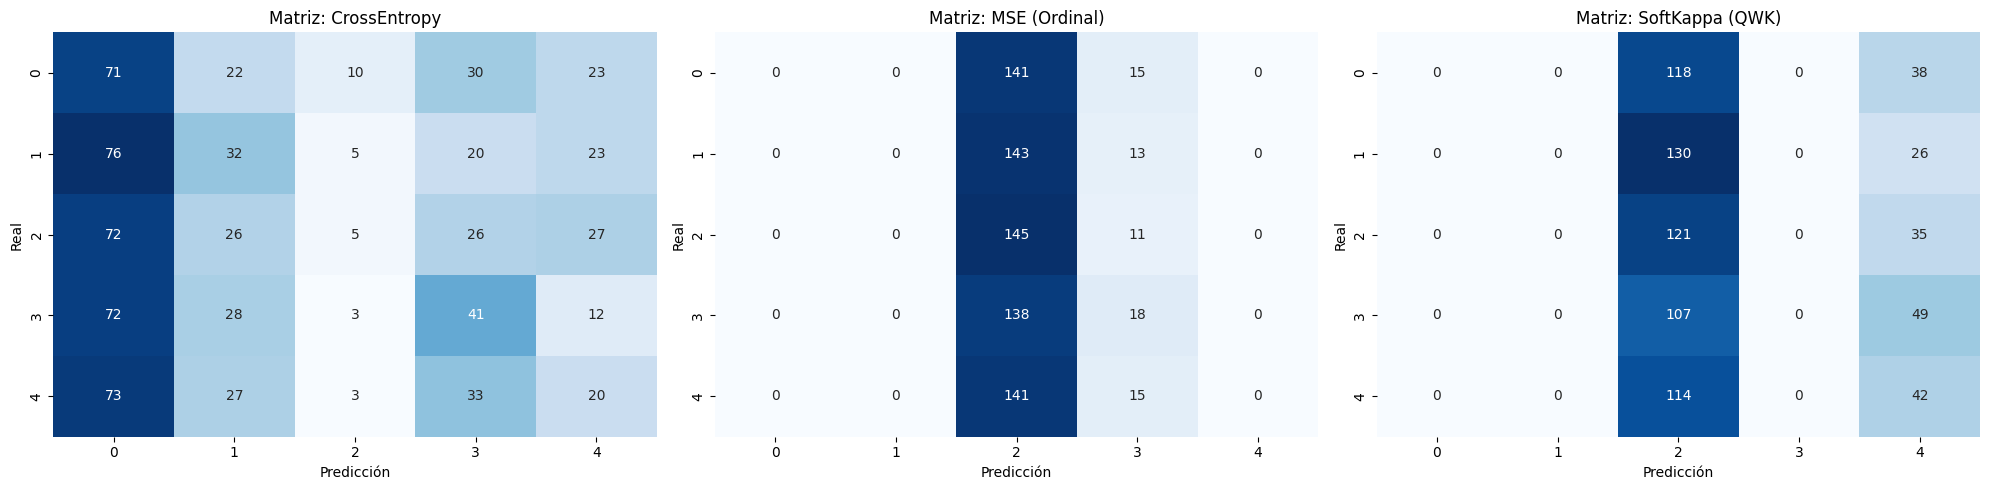


    COMPARATIVA FINAL DE RENDIMIENTO POR FUNCIÓN DE PÉRDIDA


Loss Function  Mejor QWK  Época  Acc Asociado
0     CrossEntropy     0.0731     12        0.2372
1    MSE (Ordinal)     0.0144      4        0.2090
2  SoftKappa (QWK)     0.0701     12        0.2077

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, cohen_kappa_score, confusion_matrix
from tqdm.auto import tqdm

# FUNCIÓN DE PÉRDIDA: SOFT KAPPA LOSS 
# Penaliza los errores de clasificación basándose en la distancia al objetivo real
class QWKLoss(nn.Module):
    def __init__(self, num_classes=5):
        super(QWKLoss, self).__init__()
        self.num_classes = num_classes
        i, j = torch.meshgrid(torch.arange(num_classes), torch.arange(num_classes), indexing='ij')
        self.weights = (i - j).pow(2).float()

    def forward(self, logits, targets):
        preds = torch.softmax(logits, dim=1)
        targets_oh = F.one_hot(targets, self.num_classes).float()
        
        observed = torch.matmul(targets_oh.t(), preds)
        hist_actual = targets_oh.sum(dim=0, keepdim=True)
        hist_pred = preds.sum(dim=0, keepdim=True)
        expected = torch.matmul(hist_actual.t(), hist_pred) / (preds.size(0) + 1e-8)
        
        w = self.weights.to(logits.device)
        loss = torch.sum(w * observed) / (torch.sum(w * expected) + 1e-8)
        return loss

# ARQUITECTURA CNN
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=5):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 56 * 56, 128), nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.classifier(self.features(x))

# CONFIGURACIÓN DE DATOS
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_datos_drive = r'G:\Mi unidad\Mascotas\mini_dataset'
train_dir = os.path.join(base_datos_drive, 'Train')
test_dir = os.path.join(base_datos_drive, 'Test')

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)
# Parametros fijos según solicitud
train_loader_fijo = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# EXPERIMENTO COMPARATIVO
def exp_loss_comparison():
    loss_names = ['CrossEntropy', 'MSE (Ordinal)', 'SoftKappa (QWK)']
    lr_fijo = 0.0001
    epochs = 20 
    
    histories = {name: {"loss": [], "acc": [], "qwk": [], "times": []} for name in loss_names}
    confusion_matrices = {}

    for name in loss_names:
        print(f"\n🚀 Evaluando Loss: {name}")
        model = SimpleCNN().to(device)
        optimizer = optim.Adam(model.parameters(), lr=lr_fijo)
        
        if name == 'CrossEntropy':
            criterion = nn.CrossEntropyLoss()
        elif name == 'MSE (Ordinal)':
            criterion = nn.MSELoss()
        else:
            criterion = QWKLoss(num_classes=5)
        
        start_t = time.time()
        pbar = tqdm(range(epochs), desc=f"Progreso {name}")
        
        for epoch in pbar:
            model.train()
            epoch_loss = 0
            for imgs, labels in train_loader_fijo:
                imgs, labels = imgs.to(device), labels.to(device)
                optimizer.zero_grad(set_to_none=True)
                outputs = model(imgs)
                
                if name == 'MSE (Ordinal)':
                    probs = torch.softmax(outputs, dim=1)
                    val_esperado = (probs * torch.arange(5).float().to(device)).sum(dim=1)
                    loss = criterion(val_esperado, labels.float())
                else:
                    loss = criterion(outputs, labels)
                    
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()
            
            # Validación
            model.eval()
            val_preds, val_targets = [], []
            with torch.no_grad():
                for imgs, labels in val_loader:
                    imgs, labels = imgs.to(device), labels.to(device)
                    out = model(imgs)
                    val_preds.extend(torch.max(out, 1)[1].cpu().tolist())
                    val_targets.extend(labels.cpu().tolist())
            
            # Cálculo de métricas
            avg_loss = epoch_loss / len(train_loader_fijo)
            current_acc = accuracy_score(val_targets, val_preds)
            current_qwk = cohen_kappa_score(val_targets, val_preds, weights='quadratic')
            
            histories[name]["loss"].append(avg_loss)
            histories[name]["acc"].append(current_acc)
            histories[name]["qwk"].append(current_qwk)
            histories[name]["times"].append(time.time() - start_t)
            
            pbar.set_postfix({'Loss': f'{avg_loss:.4f}', 'QWK': f'{current_qwk:.4f}'})
        
        # Guardar matriz de confusión final de este modelo
        confusion_matrices[name] = confusion_matrix(val_targets, val_preds)

    # VISUALIZACIÓN DE CURVAS DE APRENDIZAJE
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    for name in loss_names:
        axes[0].plot(histories[name]["loss"], label=name, marker='o', markersize=3)
        axes[1].plot(histories[name]["acc"], label=name, marker='^', markersize=3)
        axes[2].plot(histories[name]["qwk"], label=name, marker='s', markersize=3)
    
    axes[0].set_title('Loss (Train)'); axes[0].legend(); axes[0].grid(True)
    axes[1].set_title('Accuracy (Val)'); axes[1].legend(); axes[1].grid(True)
    axes[2].set_title('QWK (Val)'); axes[2].legend(); axes[2].grid(True)
    plt.tight_layout()
    plt.show()

    # VISUALIZACIÓN DE MATRICES DE CONFUSIÓN
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    for i, name in enumerate(loss_names):
        sns.heatmap(confusion_matrices[name], annot=True, fmt='d', cmap='Blues', ax=axes[i], cbar=False)
        axes[i].set_title(f'Matriz: {name}')
        axes[i].set_xlabel('Predicción')
        axes[i].set_ylabel('Real')
    plt.tight_layout()
    plt.show()

    # RESUMEN DE RESULTADOS
    res_list = []
    for name in loss_names:
        qwk_hist = np.array(histories[name]["qwk"])
        acc_hist = np.array(histories[name]["acc"])
        idx_pico = np.argmax(qwk_hist)
        res_list.append({
            "Loss Function": name,
            "Mejor QWK": round(qwk_hist[idx_pico], 4),
            "Época": idx_pico + 1,
            "Acc Asociado": round(acc_hist[idx_pico], 4)
        })
    
    return pd.DataFrame(res_list)

# Lanzamiento del experimento
df_resumen_losses = exp_loss_comparison()
print("\n" + "="*75)
print("    COMPARATIVA FINAL DE RENDIMIENTO POR FUNCIÓN DE PÉRDIDA")
print("="*75)
display(df_resumen_losses)

Los resultados obtenidos nos revelan:

- CrossEntropy : Con un QWK de 0.0731, sigue siendo la opción más sólida. Esto se debe a que su superficie de error es mucho más suave y fácil de navegar para el optimizador Adam. Aunque no entiende que las clases están ordenadas, su capacidad para maximizar la probabilidad de la clase correcta compensa esa falta de "sensibilidad ordinal" en esta arquitectura simple.

- MSE Ordinal : Ha obtenido el peor rendimiento (QWK 0.0144). Al tratar las etiquetas como números continuos y calcular la media ponderada, el modelo tiende a volverse "conservador" y predecir constantemente las clases centrales (como la 2) para minimizar el error cuadrático. Esto colapsa la diversidad de las predicciones y arruina la métrica Kappa.

- SoftKappa: Se queda muy cerca de la CrossEntropy (QWK 0.0701). Es interesante notar que, aunque su Accuracy es menor (20.77%), su Kappa es competitivo. Esto significa que cuando se equivoca, lo hace "cerca" de la clase real, cumpliendo su objetivo matemático. Sin embargo, al ser una función de pérdida más compleja y menos convexa, suele requerir más épocas o un pre-entrenamiento con CrossEntropy para brillar realmente.

La arquitectura actual (SimpleCNN) es demasiado limitada para extraer patrones complejos, por lo que incluso con una pérdida optimizada para Kappa, no logra romper la barrera del azar significativo. Los resultados sugieren que el problema no es solo cómo medimos el error (Loss), sino la capacidad del modelo para ver las diferencias en las imágenes.

### Red con dataset completo

Tras las fases de experimentación, hemos concluido que la configuración óptima para nuestra arquitectura base consiste en un Learning Rate de 0.0001, un Batch Size de 16 y el uso de CrossEntropyLoss. Esta combinación ofrece el mejor equilibrio entre velocidad de convergencia y estabilidad del QWK, evitando el ruido excesivo de los lotes pequeños y superando el estancamiento de las tasas de aprendizaje más agresivas. Con estos cimientos establecidos, procedemos a escalar el entrenamiento al dataset completo, donde el mayor volumen de ejemplos permitirá a la red extraer patrones visuales mucho más robustos y representativos.


🚀 Iniciando Experimento: Batch Size = 4


B4 - Época 15/15: 100%|██████████| 10710/10710 [16:01<00:00, 11.14it/s]



🚀 Iniciando Experimento: Batch Size = 8


B8 - Época 15/15: 100%|██████████| 5355/5355 [13:25<00:00,  6.65it/s]


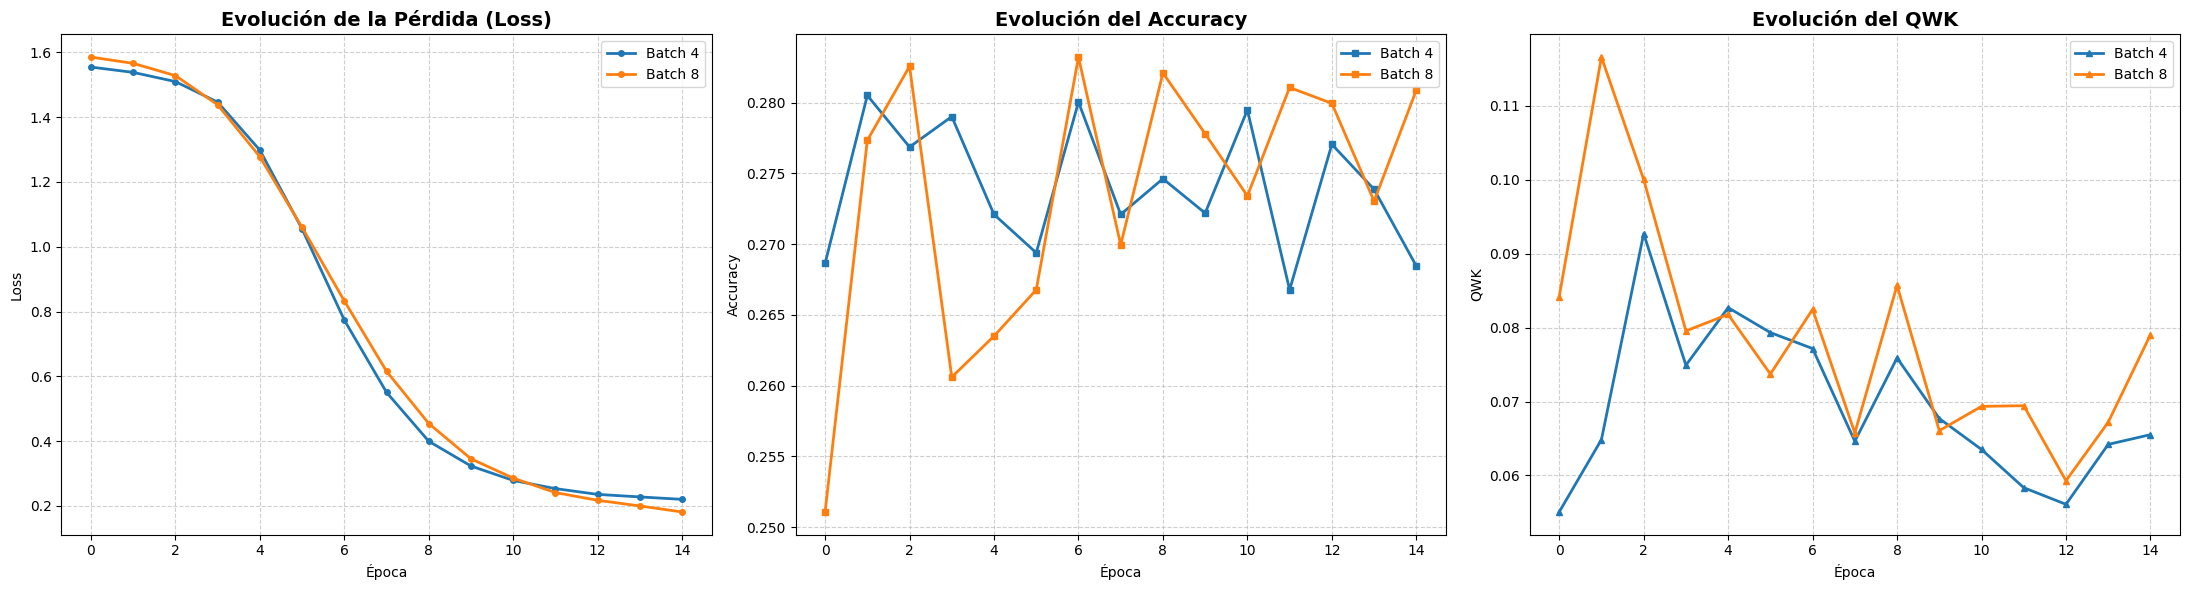


   RESUMEN FINAL: MEJOR RENDIMIENTO POR BATCH SIZE


Batch Size  Mejor QWK  Época  Accuracy Asociado  Tiempo (s)
0           4     0.0927      3             0.2769     3357.18
1           8     0.1166      2             0.2773     2223.86

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.amp as amp
import os
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from sklearn.metrics import accuracy_score, cohen_kappa_score, confusion_matrix

# ARQUITECTURA 
class PetNetScratch(nn.Module):
    def __init__(self, num_classes=5):
        super(PetNetScratch, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2), # 112x112
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2), # 56x56
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2) # 28x28
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # 128 canales * 28 * 28 de resolución = 100.352 neuronas
            nn.Linear(128 * 28 * 28, 256), nn.ReLU(), nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.classifier(self.features(x))

# PREPARACIÓN DE DIRECTORIOS Y DATOS 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
folder_modelos = '../modelos'
if not os.path.exists(folder_modelos):
    os.makedirs(folder_modelos)

# Transformación coherente con la arquitectura
transform_224 = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Carga de datasets (asegúrate que las rutas sean correctas)
base_datos_drive = r'G:\Mi unidad\Mascotas\datos tratados'
train_dataset = datasets.ImageFolder(os.path.join(base_datos_drive, 'Train'), transform=transform_224)
val_dataset = datasets.ImageFolder(os.path.join(base_datos_drive, 'Test'), transform=transform_224)

# Cálculo de pesos para balanceo de clases
targets = torch.tensor(train_dataset.targets)
class_count = torch.tensor([(targets == t).sum() for t in torch.unique(targets)])
weights = (1. / class_count.float()).to(device)

# EXPERIMENTO COMPARATIVO 
batch_sizes = [4, 8]
epochs = 15
all_histories = {}
resumen_final = []
scaler = amp.GradScaler('cuda')

for b_size in batch_sizes:
    print(f"\n🚀 Iniciando Experimento: Batch Size = {b_size}")
    
    train_loader = DataLoader(train_dataset, batch_size=b_size, shuffle=True, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, pin_memory=True)
    
    model = PetNetScratch(num_classes=5).to(device)
    criterion = nn.CrossEntropyLoss(weight=weights)
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    
    historia = {"loss": [], "qwk": [], "acc": [], "time": []}
    best_qwk_val = -1.0
    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0
        for inputs, labels in tqdm(train_loader, desc=f"B{b_size} - Época {epoch+1}/{epochs}"):
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            
            optimizer.zero_grad(set_to_none=True)
            with amp.autocast('cuda'):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            epoch_loss += loss.item()

        # Validación por época
        model.eval()
        all_preds, all_labels = [], []
        with torch.no_grad():
            for inputs, labels in val_loader:
                with amp.autocast('cuda'):
                    outputs = model(inputs.to(device, non_blocking=True))
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.numpy())

        current_acc = accuracy_score(all_labels, all_preds)
        current_qwk = cohen_kappa_score(all_labels, all_preds, weights='quadratic')
        
        historia["loss"].append(epoch_loss / len(train_loader))
        historia["acc"].append(current_acc)
        historia["qwk"].append(current_qwk)
        historia["time"].append(time.time() - start_time)

        # Guardar mejor modelo del experimento actual
        if current_qwk > best_qwk_val:
            best_qwk_val = current_qwk
            torch.save(model.state_dict(), os.path.join(folder_modelos, f'mejor_modelo_B{b_size}.pth'))

    all_histories[b_size] = historia
    
    # Registro del pico de rendimiento para la tabla final
    idx_mejor = np.argmax(historia["qwk"])
    resumen_final.append({
        "Batch Size": b_size,
        "Mejor QWK": round(historia["qwk"][idx_mejor], 4),
        "Época": idx_mejor + 1,
        "Accuracy Asociado": round(historia["acc"][idx_mejor], 4),
        "Tiempo (s)": round(historia["time"][idx_mejor], 2)
    })

# VISUALIZACIÓN HOLD ON (Superposición de curvas)
fig, axes = plt.subplots(1, 3, figsize=(22, 6))
colores = {4: '#1f77b4', 8: '#ff7f0e'}

for b in batch_sizes:
    axes[0].plot(all_histories[b]["loss"], label=f'Batch {b}', color=colores[b], lw=2, marker='o', markersize=4)
    axes[1].plot(all_histories[b]["acc"], label=f'Batch {b}', color=colores[b], lw=2, marker='s', markersize=4)
    axes[2].plot(all_histories[b]["qwk"], label=f'Batch {b}', color=colores[b], lw=2, marker='^', markersize=4)

# Configuración de estéticas
titulos = ['Evolución de la Pérdida (Loss)', 'Evolución del Accuracy', 'Evolución del QWK']
y_labels = ['Loss', 'Accuracy', 'QWK']

for i, ax in enumerate(axes):
    ax.set_title(titulos[i], fontsize=14, fontweight='bold')
    ax.set_xlabel('Época')
    ax.set_ylabel(y_labels[i])
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

#  TABLA DE RESUMEN FINAL 
df_resumen = pd.DataFrame(resumen_final)
print("\n" + "="*75)
print("   RESUMEN FINAL: MEJOR RENDIMIENTO POR BATCH SIZE")
print("="*75)
display(df_resumen)


🚀 Iniciando Entrenamiento: Batch Size = 16


B16 - Época 10/10: 100%|██████████| 2678/2678 [19:11<00:00,  2.33it/s]


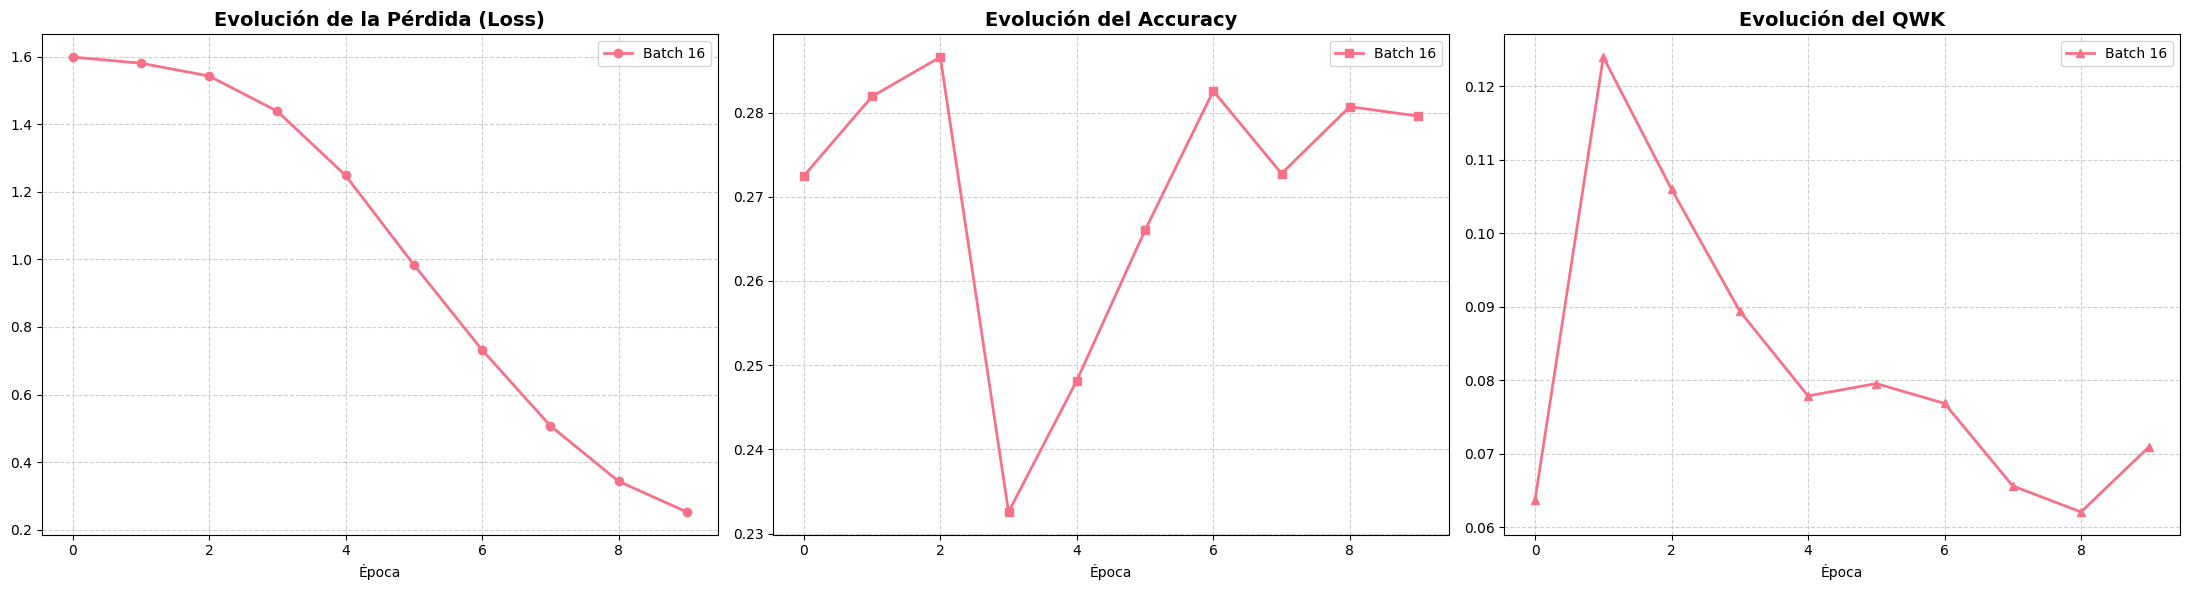

C:\Users\Equipo\AppData\Local\Temp\ipykernel_19952\4058752944.py:145: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(folder_mode

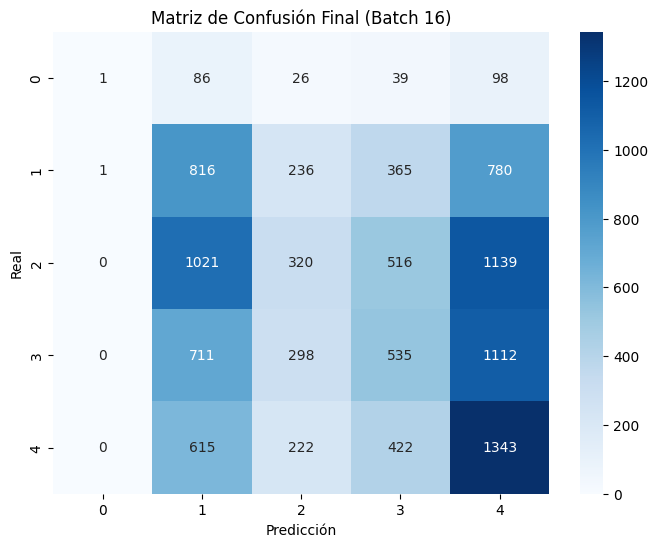


   RESUMEN FINAL: RENDIMIENTO BATCH SIZE 16
   Batch Size  Mejor QWK  Época  Accuracy Asociado  Tiempo (s)
0          16      0.124      2             0.2819     2764.61


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.amp as amp
import os
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from sklearn.metrics import accuracy_score, cohen_kappa_score, confusion_matrix

# ARQUITECTURA SINCRONIZADA 
class PetNetScratch(nn.Module):
    def __init__(self, num_classes=5):
        super(PetNetScratch, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 28 * 28, 256), nn.ReLU(), nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.classifier(self.features(x))

# PREPARACIÓN DE DIRECTORIOS Y DATOS 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
folder_modelos = '../modelos'
if not os.path.exists(folder_modelos):
    os.makedirs(folder_modelos)

transform_224 = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

base_datos_drive = r'G:\Mi unidad\Mascotas\datos tratados'
train_dataset = datasets.ImageFolder(os.path.join(base_datos_drive, 'Train'), transform=transform_224)
val_dataset = datasets.ImageFolder(os.path.join(base_datos_drive, 'Test'), transform=transform_224)

targets = torch.tensor(train_dataset.targets)
class_count = torch.tensor([(targets == t).sum() for t in torch.unique(targets)])
weights = (1. / class_count.float()).to(device)

# EXPERIMENTO (SOLO BATCH 16) 
batch_sizes = [16]
epochs = 10
all_histories = {}
resumen_final = []
scaler = amp.GradScaler('cuda')

for b_size in batch_sizes:
    print(f"\n🚀 Iniciando Entrenamiento: Batch Size = {b_size}")
    
    train_loader = DataLoader(train_dataset, batch_size=b_size, shuffle=True, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, pin_memory=True)
    
    model = PetNetScratch(num_classes=5).to(device)
    criterion = nn.CrossEntropyLoss(weight=weights)
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    
    historia = {"loss": [], "qwk": [], "acc": [], "time": []}
    best_qwk_val = -1.0
    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0
        for inputs, labels in tqdm(train_loader, desc=f"B{b_size} - Época {epoch+1}/{epochs}"):
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            
            optimizer.zero_grad(set_to_none=True)
            with amp.autocast('cuda'):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            epoch_loss += loss.item()

        model.eval()
        all_preds, all_labels = [], []
        with torch.no_grad():
            for inputs, labels in val_loader:
                with amp.autocast('cuda'):
                    outputs = model(inputs.to(device, non_blocking=True))
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.numpy())

        current_acc = accuracy_score(all_labels, all_preds)
        current_qwk = cohen_kappa_score(all_labels, all_preds, weights='quadratic')
        
        historia["loss"].append(epoch_loss / len(train_loader))
        historia["acc"].append(current_acc)
        historia["qwk"].append(current_qwk)
        historia["time"].append(time.time() - start_time)

        if current_qwk > best_qwk_val:
            best_qwk_val = current_qwk
            torch.save(model.state_dict(), os.path.join(folder_modelos, f'mejor_modelo_B{b_size}.pth'))

    all_histories[b_size] = historia
    
    idx_mejor = np.argmax(historia["qwk"])
    resumen_final.append({
        "Batch Size": b_size,
        "Mejor QWK": round(historia["qwk"][idx_mejor], 4),
        "Época": idx_mejor + 1,
        "Accuracy Asociado": round(historia["acc"][idx_mejor], 4),
        "Tiempo (s)": round(historia["time"][idx_mejor], 2)
    })

# VISUALIZACIÓN DE MÉTRICAS 
fig, axes = plt.subplots(1, 3, figsize=(22, 6))
palette = sns.color_palette("husl", len(batch_sizes))
colores_dinamicos = {b: palette[i] for i, b in enumerate(batch_sizes)}

for b in batch_sizes:
    axes[0].plot(all_histories[b]["loss"], label=f'Batch {b}', color=colores_dinamicos[b], lw=2, marker='o')
    axes[1].plot(all_histories[b]["acc"], label=f'Batch {b}', color=colores_dinamicos[b], lw=2, marker='s')
    axes[2].plot(all_histories[b]["qwk"], label=f'Batch {b}', color=colores_dinamicos[b], lw=2, marker='^')

titulos = ['Evolución de la Pérdida (Loss)', 'Evolución del Accuracy', 'Evolución del QWK']
for i, ax in enumerate(axes):
    ax.set_title(titulos[i], fontsize=14, fontweight='bold')
    ax.set_xlabel('Época')
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

# MATRIZ DE CONFUSIÓN
model.load_state_dict(torch.load(os.path.join(folder_modelos, f'mejor_modelo_B16.pth')))
model.eval()
final_preds, final_labels = [], []

with torch.no_grad():
    for inputs, labels in val_loader:
        outputs = model(inputs.to(device))
        _, preds = torch.max(outputs, 1)
        final_preds.extend(preds.cpu().numpy())
        final_labels.extend(labels.numpy())

cm = confusion_matrix(final_labels, final_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.title('Matriz de Confusión Final (Batch 16)')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

#  TABLA DE RESUMEN FINAL 
df_resumen = pd.DataFrame(resumen_final)
print("\n" + "="*75)
print("   RESUMEN FINAL: RENDIMIENTO BATCH SIZE 16")
print("="*75)
print(df_resumen)

## Redes pre-entrenadas


Epoch 1/20:   0%|          | 0/1339 [00:00<?, ?it/s]

Epoch 2/20:   0%|          | 0/1339 [00:00<?, ?it/s]

Epoch 3/20:   0%|          | 0/1339 [00:00<?, ?it/s]

Epoch 4/20:   0%|          | 0/1339 [00:00<?, ?it/s]

Epoch 5/20:   0%|          | 0/1339 [00:00<?, ?it/s]

Epoch 6/20:   0%|          | 0/1339 [00:00<?, ?it/s]

Epoch 7/20:   0%|          | 0/1339 [00:00<?, ?it/s]

Epoch 8/20:   0%|          | 0/1339 [00:00<?, ?it/s]

Epoch 9/20:   0%|          | 0/1339 [00:00<?, ?it/s]

Epoch 10/20:   0%|          | 0/1339 [00:00<?, ?it/s]

Epoch 11/20:   0%|          | 0/1339 [00:00<?, ?it/s]

Epoch 12/20:   0%|          | 0/1339 [00:00<?, ?it/s]

Epoch 13/20:   0%|          | 0/1339 [00:00<?, ?it/s]

Epoch 14/20:   0%|          | 0/1339 [00:00<?, ?it/s]

Epoch 15/20:   0%|          | 0/1339 [00:00<?, ?it/s]

Epoch 16/20:   0%|          | 0/1339 [00:00<?, ?it/s]

Epoch 17/20:   0%|          | 0/1339 [00:00<?, ?it/s]

Epoch 18/20:   0%|          | 0/1339 [00:00<?, ?it/s]

Epoch 19/20:   0%|          | 0/1339 [00:00<?, ?it/s]

Epoch 20/20:   0%|          | 0/1339 [00:00<?, ?it/s]

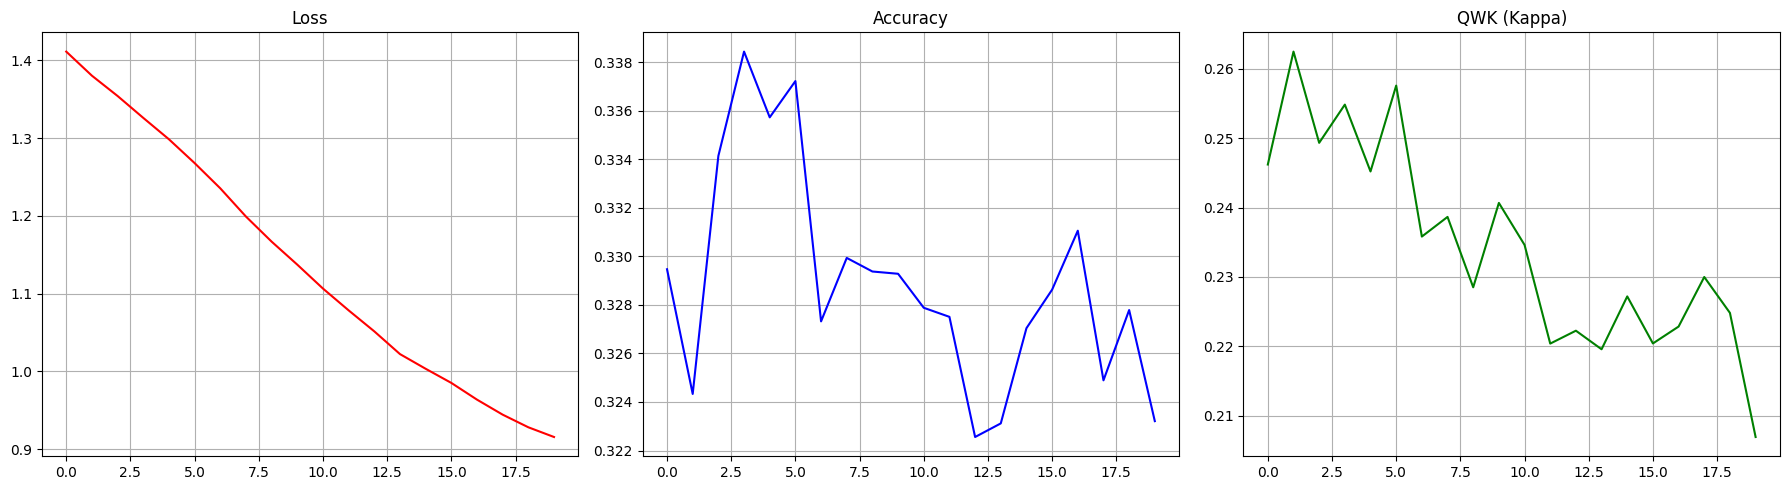

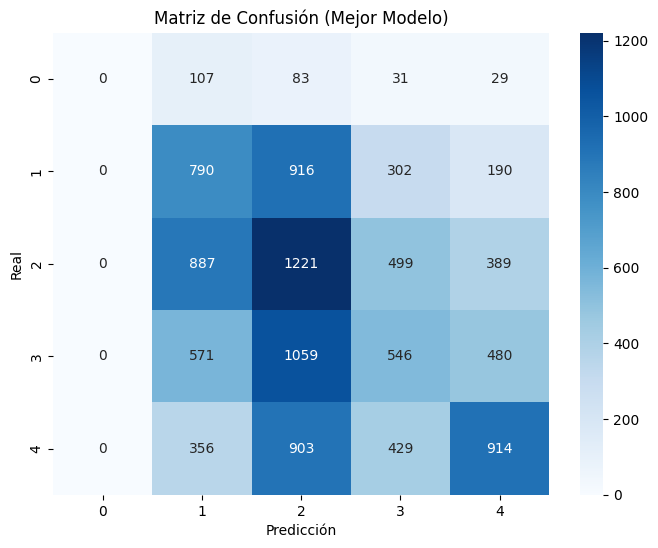


📊 RESUMEN DEL MEJOR MODELO (CRITERIO QWK):
 Mejor QWK  Época  Accuracy Asociado  Tiempo (s)
   0.26249      2            0.32433       55.85


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import os
import time
import shutil
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import cohen_kappa_score, accuracy_score, confusion_matrix
from google.colab import drive

# Optimización para hardware Ampere 
torch.set_float32_matmul_precision('high')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Gestión de datos (carga solo si es necesario)
local_path = '/content/dataset_local'
if not os.path.exists(local_path):
    print("🚀 Transfiriendo datos al SSD local...")
    drive.mount('/content/drive')
    shutil.copytree('/content/drive/MyDrive/Mascotas/datos tratados', local_path)

# Transformaciones
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_ds = datasets.ImageFolder(os.path.join(local_path, 'Train'), transform=transform)
test_ds = datasets.ImageFolder(os.path.join(local_path, 'Test'), transform=transform)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=4, pin_memory=True, persistent_workers=True)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=4, pin_memory=True, persistent_workers=True)

# Modelo Preentrenado (ResNet50)
def get_resnet_model(num_classes=5):
    model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
    for param in model.parameters():
        param.requires_grad = False
    model.fc = nn.Sequential(
        nn.Linear(model.fc.in_features, 256),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(256, num_classes)
    )
    return model.to(device)

# Entrenamiento
def train_petfinder(model, epochs=20):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

    history = {'loss': [], 'acc': [], 'qwk': []}
    best_qwk = -1
    best_row = {}

    for epoch in range(epochs):
        start_t = time.time()
        model.train()
        t_loss = 0

        for imgs, lbls in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False):
            imgs, lbls = imgs.to(device), lbls.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, lbls)
            loss.backward()
            optimizer.step()
            t_loss += loss.item()

        # Evaluación
        model.eval()
        preds, targets = [], []
        with torch.no_grad():
            for imgs, lbls in test_loader:
                imgs, lbls = imgs.to(device), lbls.to(device)
                out = model(imgs)
                preds.extend(out.argmax(1).cpu().numpy())
                targets.extend(lbls.cpu().numpy())

        acc = accuracy_score(targets, preds)
        qwk = cohen_kappa_score(targets, preds, weights='quadratic')
        duration = time.time() - start_t

        history['loss'].append(t_loss/len(train_loader))
        history['acc'].append(acc)
        history['qwk'].append(qwk)

        if qwk > best_qwk:
            best_qwk = qwk
            torch.save(model.state_dict(), 'best_model_qwk_2.pth')
            best_row = {'Mejor QWK': round(qwk, 5), 'Época': epoch + 1, 'Accuracy Asociado': round(acc, 5), 'Tiempo (s)': round(duration, 2)}

    return history, best_row

# Ejecutar proceso
model = get_resnet_model()
history, summary = train_petfinder(model, epochs=20)

# Gráficas de evolución (1x3)
fig, ax = plt.subplots(1, 3, figsize=(18, 5))
ax[0].plot(history['loss'], 'r-'); ax[0].set_title('Loss'); ax[0].grid(True)
ax[1].plot(history['acc'], 'b-'); ax[1].set_title('Accuracy'); ax[1].grid(True)
ax[2].plot(history['qwk'], 'g-'); ax[2].set_title('QWK (Kappa)'); ax[2].grid(True)
plt.tight_layout()
plt.show()

# Matriz de Confusión del mejor modelo
model.load_state_dict(torch.load('best_model_qwk_2.pth'))
model.eval()
final_preds, final_targets = [], []
with torch.no_grad():
    for imgs, lbls in test_loader:
        imgs, lbls = imgs.to(device), lbls.to(device)
        out = model(imgs)
        final_preds.extend(out.argmax(1).cpu().numpy())
        final_targets.extend(lbls.cpu().numpy())

cm = confusion_matrix(final_targets, final_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_ds.classes, yticklabels=train_ds.classes)
plt.xlabel('Predicción'); plt.ylabel('Real')
plt.title('Matriz de Confusión (Mejor Modelo)')
plt.show()

#  Tabla Resumen
print("\n📊 RESUMEN DEL MEJOR MODELO (CRITERIO QWK):")
print(pd.DataFrame([summary]).to_string(index=False))

## Ensamble methods


🔥 Entrenando Experto Clase 0 (ResNet50 + Fine-tuning)


C0 | Ep 1: 100%|██████████| 98/98 [00:21<00:00,  4.48it/s]
C0 | Ep 2: 100%|██████████| 98/98 [00:22<00:00,  4.30it/s]
C0 | Ep 3: 100%|██████████| 98/98 [00:21<00:00,  4.48it/s]
C0 | Ep 4: 100%|██████████| 98/98 [00:29<00:00,  3.37it/s]
C0 | Ep 5: 100%|██████████| 98/98 [00:35<00:00,  2.74it/s]
C0 | Ep 6: 100%|██████████| 98/98 [00:39<00:00,  2.51it/s]
C0 | Ep 7: 100%|██████████| 98/98 [00:44<00:00,  2.20it/s]
C0 | Ep 8: 100%|██████████| 98/98 [00:41<00:00,  2.34it/s]
C0 | Ep 9: 100%|██████████| 98/98 [00:40<00:00,  2.44it/s]
C0 | Ep 10: 100%|██████████| 98/98 [00:39<00:00,  2.48it/s]
C0 | Ep 11: 100%|██████████| 98/98 [00:41<00:00,  2.37it/s]
C0 | Ep 12: 100%|██████████| 98/98 [00:40<00:00,  2.44it/s]



🔥 Entrenando Experto Clase 1 (ResNet50 + Fine-tuning)


C1 | Ep 1: 100%|██████████| 98/98 [00:41<00:00,  2.35it/s]
C1 | Ep 2: 100%|██████████| 98/98 [00:42<00:00,  2.33it/s]
C1 | Ep 3: 100%|██████████| 98/98 [00:41<00:00,  2.35it/s]
C1 | Ep 4: 100%|██████████| 98/98 [00:42<00:00,  2.29it/s]
C1 | Ep 5: 100%|██████████| 98/98 [00:44<00:00,  2.20it/s]
C1 | Ep 6: 100%|██████████| 98/98 [00:42<00:00,  2.32it/s]
C1 | Ep 7: 100%|██████████| 98/98 [00:43<00:00,  2.26it/s]
C1 | Ep 8: 100%|██████████| 98/98 [00:41<00:00,  2.35it/s]
C1 | Ep 9: 100%|██████████| 98/98 [00:40<00:00,  2.43it/s]
C1 | Ep 10: 100%|██████████| 98/98 [00:39<00:00,  2.45it/s]
C1 | Ep 11: 100%|██████████| 98/98 [00:42<00:00,  2.28it/s]
C1 | Ep 12: 100%|██████████| 98/98 [00:40<00:00,  2.43it/s]



🔥 Entrenando Experto Clase 2 (ResNet50 + Fine-tuning)


C2 | Ep 1: 100%|██████████| 98/98 [00:38<00:00,  2.51it/s]
C2 | Ep 2: 100%|██████████| 98/98 [00:45<00:00,  2.17it/s]
C2 | Ep 3: 100%|██████████| 98/98 [00:39<00:00,  2.45it/s]
C2 | Ep 4: 100%|██████████| 98/98 [00:40<00:00,  2.44it/s]
C2 | Ep 5: 100%|██████████| 98/98 [00:41<00:00,  2.34it/s]
C2 | Ep 6: 100%|██████████| 98/98 [00:45<00:00,  2.16it/s]
C2 | Ep 7: 100%|██████████| 98/98 [00:44<00:00,  2.22it/s]
C2 | Ep 8: 100%|██████████| 98/98 [00:46<00:00,  2.10it/s]
C2 | Ep 9: 100%|██████████| 98/98 [00:39<00:00,  2.45it/s]
C2 | Ep 10: 100%|██████████| 98/98 [00:41<00:00,  2.37it/s]
C2 | Ep 11: 100%|██████████| 98/98 [00:41<00:00,  2.35it/s]
C2 | Ep 12: 100%|██████████| 98/98 [00:42<00:00,  2.33it/s]



🔥 Entrenando Experto Clase 3 (ResNet50 + Fine-tuning)


C3 | Ep 1: 100%|██████████| 98/98 [00:40<00:00,  2.41it/s]
C3 | Ep 2: 100%|██████████| 98/98 [00:38<00:00,  2.55it/s]
C3 | Ep 3: 100%|██████████| 98/98 [00:41<00:00,  2.34it/s]
C3 | Ep 4: 100%|██████████| 98/98 [00:40<00:00,  2.40it/s]
C3 | Ep 5: 100%|██████████| 98/98 [00:41<00:00,  2.37it/s]
C3 | Ep 6: 100%|██████████| 98/98 [00:42<00:00,  2.29it/s]
C3 | Ep 7: 100%|██████████| 98/98 [00:43<00:00,  2.26it/s]
C3 | Ep 8: 100%|██████████| 98/98 [00:42<00:00,  2.31it/s]
C3 | Ep 9: 100%|██████████| 98/98 [00:40<00:00,  2.44it/s]
C3 | Ep 10: 100%|██████████| 98/98 [00:41<00:00,  2.37it/s]
C3 | Ep 11: 100%|██████████| 98/98 [00:41<00:00,  2.36it/s]
C3 | Ep 12: 100%|██████████| 98/98 [00:39<00:00,  2.45it/s]



🔥 Entrenando Experto Clase 4 (ResNet50 + Fine-tuning)


C4 | Ep 1: 100%|██████████| 98/98 [00:41<00:00,  2.38it/s]
C4 | Ep 2: 100%|██████████| 98/98 [00:41<00:00,  2.37it/s]
C4 | Ep 3: 100%|██████████| 98/98 [00:39<00:00,  2.48it/s]
C4 | Ep 4: 100%|██████████| 98/98 [00:47<00:00,  2.07it/s]
C4 | Ep 5: 100%|██████████| 98/98 [00:31<00:00,  3.10it/s]
C4 | Ep 6: 100%|██████████| 98/98 [00:34<00:00,  2.83it/s]
C4 | Ep 7: 100%|██████████| 98/98 [00:36<00:00,  2.65it/s]
C4 | Ep 8: 100%|██████████| 98/98 [00:34<00:00,  2.81it/s]
C4 | Ep 9: 100%|██████████| 98/98 [00:32<00:00,  2.97it/s]
C4 | Ep 10: 100%|██████████| 98/98 [00:32<00:00,  3.04it/s]
C4 | Ep 11: 100%|██████████| 98/98 [00:31<00:00,  3.12it/s]
C4 | Ep 12: 100%|██████████| 98/98 [00:33<00:00,  2.94it/s]



🧩 Evaluando Ensamblado Final de Expertos...


C:\Users\Equipo\AppData\Local\Temp\ipykernel_12032\1016322572.py:154: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m.load_state_dict(torch.load(os.path.join(folder_modelos,

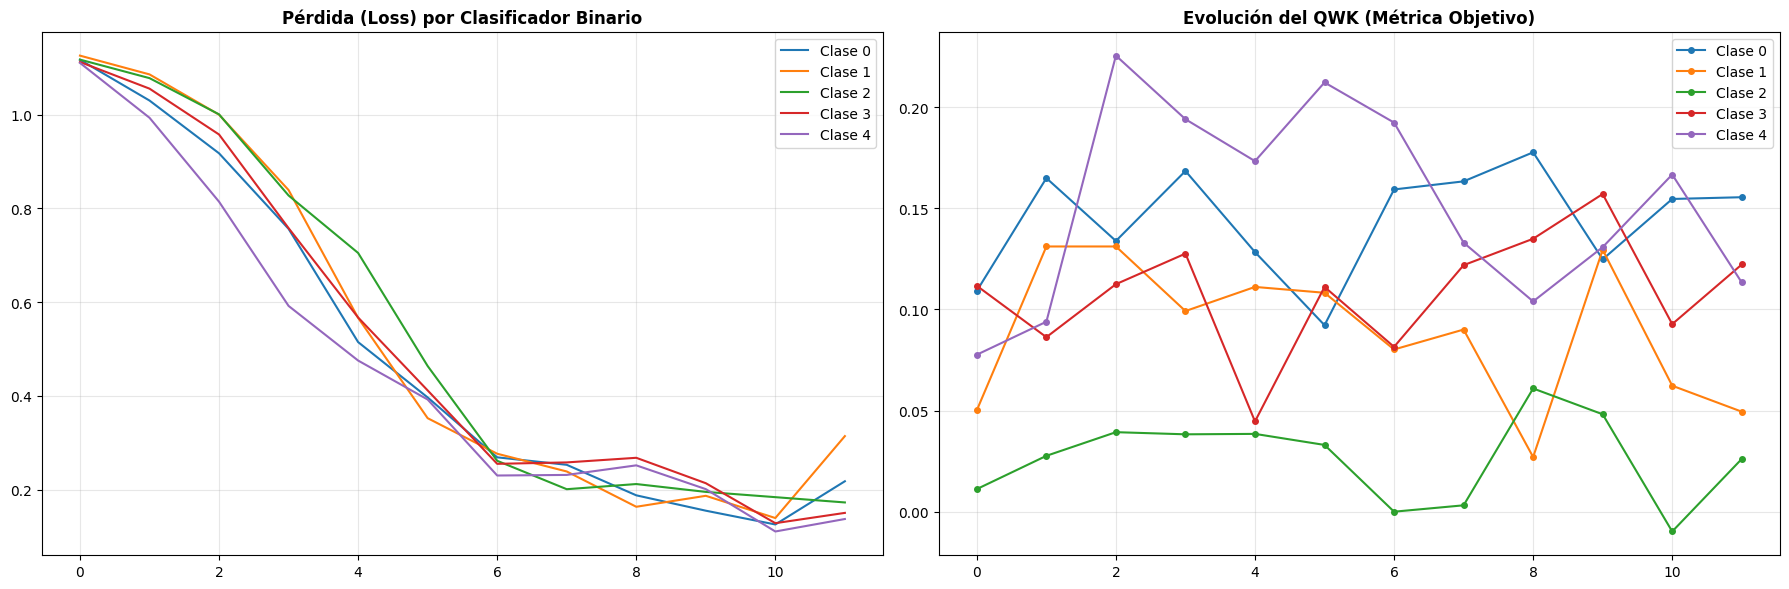


   RESULTADOS FINALES | ACC ENSAMBLADO: 0.3000 | QWK ENSAMBLADO: 0.2384


Modelo  Mejor QWK  Época  Tiempo (s)     Acc
0  ResNet50_C0     0.1777      9      664.30  0.7603
1  ResNet50_C1     0.1311      2      821.69  0.6397
2  ResNet50_C2     0.0609      9      835.74  0.7154
3  ResNet50_C3     0.1570     10      819.00  0.7192
4  ResNet50_C4     0.2254      3      686.15  0.7128

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.amp as amp
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from torch.utils.data import DataLoader
from torchvision import transforms, datasets, models
from sklearn.metrics import accuracy_score, cohen_kappa_score

#  ARQUITECTURA 
class PetNetResNet50(nn.Module):
    def __init__(self):
        super(PetNetResNet50, self).__init__()
        # Usamos ResNet50 por su mayor capacidad de extracción
        self.model = models.resnet50(weights='IMAGENET1K_V2')
        
        # Congelamos casi todo el modelo
        for param in self.model.parameters():
            param.requires_grad = False
            
        # Descongelamos el último bloque (layer4) para permitir adaptación fina
        for param in self.model.layer4.parameters():
            param.requires_grad = True
            
        # Cabeza de clasificación personalizada
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Linear(num_ftrs, 512),
            nn.ReLU(),
            nn.Dropout(0.5), # Regularización fuerte
            nn.Linear(512, 1)
        )

    def forward(self, x):
        return self.model(x)

#  PREPARACIÓN DE DATOS CON AUGMENTATION 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
folder_modelos = '../modelos_expert'
if not os.path.exists(folder_modelos):
    os.makedirs(folder_modelos)

# Aumentamos la diversidad de los datos para mejorar la generalización
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

base_datos_drive = r'G:\Mi unidad\Mascotas\mini_dataset'
train_dataset = datasets.ImageFolder(os.path.join(base_datos_drive, 'Train'), transform=transform_train)
val_dataset = datasets.ImageFolder(os.path.join(base_datos_drive, 'Test'), transform=transform_val)

batch_size = 8
epochs = 12
num_classes = 5
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, pin_memory=True)

# BUCLE DE ENTRENAMIENTO POR CLASE 
all_histories = {}
resumen_final = []
scaler = amp.GradScaler('cuda')
train_targets = np.array(train_dataset.targets)

for class_id in range(num_classes):
    print(f"\n🔥 Entrenando Experto Clase {class_id} (ResNet50 + Fine-tuning)")
    
    model = PetNetResNet50().to(device)
    
    # Balanceo dinámico para el enfoque 1-vs-Rest
    pos_samples = (train_targets == class_id).sum()
    neg_samples = len(train_targets) - pos_samples
    pos_weight = torch.tensor([neg_samples / pos_samples]).to(device)
    
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    # Optimizamos solo los parámetros que no están congelados
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001)
    
    historia = {"loss": [], "qwk": [], "acc": []}
    best_qwk = -1.0
    best_epoch = 0
    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0
        for inputs, labels in tqdm(train_loader, desc=f"C{class_id} | Ep {epoch+1}"):
            inputs = inputs.to(device)
            binary_labels = (labels == class_id).float().unsqueeze(1).to(device)
            
            optimizer.zero_grad(set_to_none=True)
            with amp.autocast('cuda'):
                outputs = model(inputs)
                loss = criterion(outputs, binary_labels)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            epoch_loss += loss.item()

        # Validación
        model.eval()
        all_preds, all_labels = [], []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                binary_labels = (labels == class_id).float().unsqueeze(1)
                outputs = model(inputs)
                preds = (torch.sigmoid(outputs) > 0.5).float()
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(binary_labels.cpu().numpy())

        current_qwk = cohen_kappa_score(all_labels, all_preds)
        current_acc = accuracy_score(all_labels, all_preds)
        
        historia["loss"].append(epoch_loss / len(train_loader))
        historia["qwk"].append(current_qwk)
        historia["acc"].append(current_acc)

        if current_qwk > best_qwk:
            best_qwk = current_qwk
            best_epoch = epoch + 1
            torch.save(model.state_dict(), os.path.join(folder_modelos, f'best_c{class_id}.pth'))

    total_time = time.time() - start_time
    all_histories[class_id] = historia
    resumen_final.append({
        "Modelo": f"ResNet50_C{class_id}",
        "Mejor QWK": round(best_qwk, 4),
        "Época": best_epoch,
        "Tiempo (s)": round(total_time, 2),
        "Acc": round(historia["acc"][best_epoch-1], 4)
    })

#  ENSAMBLADO Y GRÁFICAS 
print("\n🧩 Evaluando Ensamblado Final de Expertos...")
modelos_cargados = []
for i in range(num_classes):
    m = PetNetResNet50().to(device)
    m.load_state_dict(torch.load(os.path.join(folder_modelos, f'best_c{i}.pth')))
    m.eval()
    modelos_cargados.append(m)

final_preds, final_labels = [], []
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        logits = torch.cat([m(inputs) for m in modelos_cargados], dim=1)
        _, preds = torch.max(logits, 1)
        final_preds.extend(preds.cpu().numpy())
        final_labels.extend(labels.numpy())

# Gráficas de rendimiento
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
for i in range(num_classes):
    axes[0].plot(all_histories[i]["loss"], label=f'Clase {i}')
    axes[1].plot(all_histories[i]["qwk"], label=f'Clase {i}', marker='o', markersize=4)

axes[0].set_title('Pérdida (Loss) por Clasificador Binario', fontweight='bold')
axes[1].set_title('Evolución del QWK (Métrica Objetivo)', fontweight='bold')
for ax in axes: ax.legend(); ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Resumen final
df_resumen = pd.DataFrame(resumen_final)
ens_qwk = cohen_kappa_score(final_labels, final_preds, weights='quadratic')
ens_acc = accuracy_score(final_labels, final_preds)

print("\n" + "="*85)
print(f"   RESULTADOS FINALES | ACC ENSAMBLADO: {ens_acc:.4f} | QWK ENSAMBLADO: {ens_qwk:.4f}")
print("="*85)
display(df_resumen)


🔥 Entrenando Experto Clase 0 vs Resto


C0 | Ep 1: 100%|██████████| 5355/5355 [28:28<00:00,  3.13it/s]
C0 | Ep 2: 100%|██████████| 5355/5355 [24:59<00:00,  3.57it/s]
C0 | Ep 3: 100%|██████████| 5355/5355 [23:50<00:00,  3.74it/s]
C0 | Ep 4: 100%|██████████| 5355/5355 [27:25<00:00,  3.26it/s]
C0 | Ep 5: 100%|██████████| 5355/5355 [22:30<00:00,  3.97it/s]
C0 | Ep 6: 100%|██████████| 5355/5355 [22:09<00:00,  4.03it/s]
C0 | Ep 7: 100%|██████████| 5355/5355 [21:37<00:00,  4.13it/s]
C0 | Ep 8: 100%|██████████| 5355/5355 [21:36<00:00,  4.13it/s]
C0 | Ep 9: 100%|██████████| 5355/5355 [21:50<00:00,  4.09it/s]
C0 | Ep 10: 100%|██████████| 5355/5355 [21:46<00:00,  4.10it/s]
C0 | Ep 11: 100%|██████████| 5355/5355 [21:59<00:00,  4.06it/s]
C0 | Ep 12: 100%|██████████| 5355/5355 [22:15<00:00,  4.01it/s]



🔥 Entrenando Experto Clase 1 vs Resto


C1 | Ep 1: 100%|██████████| 5355/5355 [21:23<00:00,  4.17it/s]
C1 | Ep 2: 100%|██████████| 5355/5355 [22:03<00:00,  4.04it/s]
C1 | Ep 3: 100%|██████████| 5355/5355 [21:27<00:00,  4.16it/s]
C1 | Ep 4: 100%|██████████| 5355/5355 [22:22<00:00,  3.99it/s]  
C1 | Ep 5: 100%|██████████| 5355/5355 [21:58<00:00,  4.06it/s]
C1 | Ep 6: 100%|██████████| 5355/5355 [21:37<00:00,  4.13it/s]
C1 | Ep 7: 100%|██████████| 5355/5355 [21:41<00:00,  4.11it/s]
C1 | Ep 8: 100%|██████████| 5355/5355 [21:52<00:00,  4.08it/s]
C1 | Ep 9: 100%|██████████| 5355/5355 [21:45<00:00,  4.10it/s]
C1 | Ep 10: 100%|██████████| 5355/5355 [21:33<00:00,  4.14it/s]
C1 | Ep 11: 100%|██████████| 5355/5355 [21:32<00:00,  4.14it/s]
C1 | Ep 12: 100%|██████████| 5355/5355 [21:43<00:00,  4.11it/s]



🔥 Entrenando Experto Clase 2 vs Resto


C2 | Ep 1: 100%|██████████| 5355/5355 [21:48<00:00,  4.09it/s]
C2 | Ep 2: 100%|██████████| 5355/5355 [21:59<00:00,  4.06it/s]
C2 | Ep 3: 100%|██████████| 5355/5355 [21:47<00:00,  4.10it/s]
C2 | Ep 4: 100%|██████████| 5355/5355 [21:58<00:00,  4.06it/s]
C2 | Ep 5: 100%|██████████| 5355/5355 [21:55<00:00,  4.07it/s]
C2 | Ep 6: 100%|██████████| 5355/5355 [21:36<00:00,  4.13it/s]
C2 | Ep 7: 100%|██████████| 5355/5355 [21:41<00:00,  4.12it/s]
C2 | Ep 8: 100%|██████████| 5355/5355 [21:46<00:00,  4.10it/s]
C2 | Ep 9: 100%|██████████| 5355/5355 [21:45<00:00,  4.10it/s]
C2 | Ep 10: 100%|██████████| 5355/5355 [21:52<00:00,  4.08it/s]
C2 | Ep 11: 100%|██████████| 5355/5355 [21:51<00:00,  4.08it/s]
C2 | Ep 12: 100%|██████████| 5355/5355 [21:49<00:00,  4.09it/s]



🔥 Entrenando Experto Clase 3 vs Resto


C3 | Ep 1: 100%|██████████| 5355/5355 [21:52<00:00,  4.08it/s]
C3 | Ep 2: 100%|██████████| 5355/5355 [21:58<00:00,  4.06it/s]
C3 | Ep 3: 100%|██████████| 5355/5355 [21:56<00:00,  4.07it/s]
C3 | Ep 4: 100%|██████████| 5355/5355 [21:54<00:00,  4.07it/s]
C3 | Ep 5: 100%|██████████| 5355/5355 [21:59<00:00,  4.06it/s]
C3 | Ep 6: 100%|██████████| 5355/5355 [23:26<00:00,  3.81it/s]
C3 | Ep 7: 100%|██████████| 5355/5355 [23:46<00:00,  3.75it/s]
C3 | Ep 8: 100%|██████████| 5355/5355 [28:07<00:00,  3.17it/s]
C3 | Ep 9: 100%|██████████| 5355/5355 [25:59<00:00,  3.43it/s]
C3 | Ep 10: 100%|██████████| 5355/5355 [27:06<00:00,  3.29it/s]
C3 | Ep 11: 100%|██████████| 5355/5355 [24:49<00:00,  3.59it/s]
C3 | Ep 12: 100%|██████████| 5355/5355 [26:47<00:00,  3.33it/s]



🔥 Entrenando Experto Clase 4 vs Resto


C4 | Ep 1: 100%|██████████| 5355/5355 [26:01<00:00,  3.43it/s]
C4 | Ep 2: 100%|██████████| 5355/5355 [31:57<00:00,  2.79it/s]
C4 | Ep 3: 100%|██████████| 5355/5355 [32:39<00:00,  2.73it/s]
C4 | Ep 4: 100%|██████████| 5355/5355 [35:47<00:00,  2.49it/s]  
C4 | Ep 5: 100%|██████████| 5355/5355 [34:56<00:00,  2.55it/s]
C4 | Ep 6: 100%|██████████| 5355/5355 [31:51<00:00,  2.80it/s]
C4 | Ep 7: 100%|██████████| 5355/5355 [35:43<00:00,  2.50it/s] 
C4 | Ep 8: 100%|██████████| 5355/5355 [31:32<00:00,  2.83it/s] 
C4 | Ep 9: 100%|██████████| 5355/5355 [23:35<00:00,  3.78it/s]
C4 | Ep 10: 100%|██████████| 5355/5355 [24:05<00:00,  3.70it/s]
C4 | Ep 11: 100%|██████████| 5355/5355 [25:27<00:00,  3.51it/s]
C4 | Ep 12: 100%|██████████| 5355/5355 [23:10<00:00,  3.85it/s]



🧩 Construyendo y evaluando el Ensamblado...


C:\Users\Equipo\AppData\Local\Temp\ipykernel_12032\3320129926.py:156: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m.load_state_dict(torch.load(os.path.join(folder_modelos,

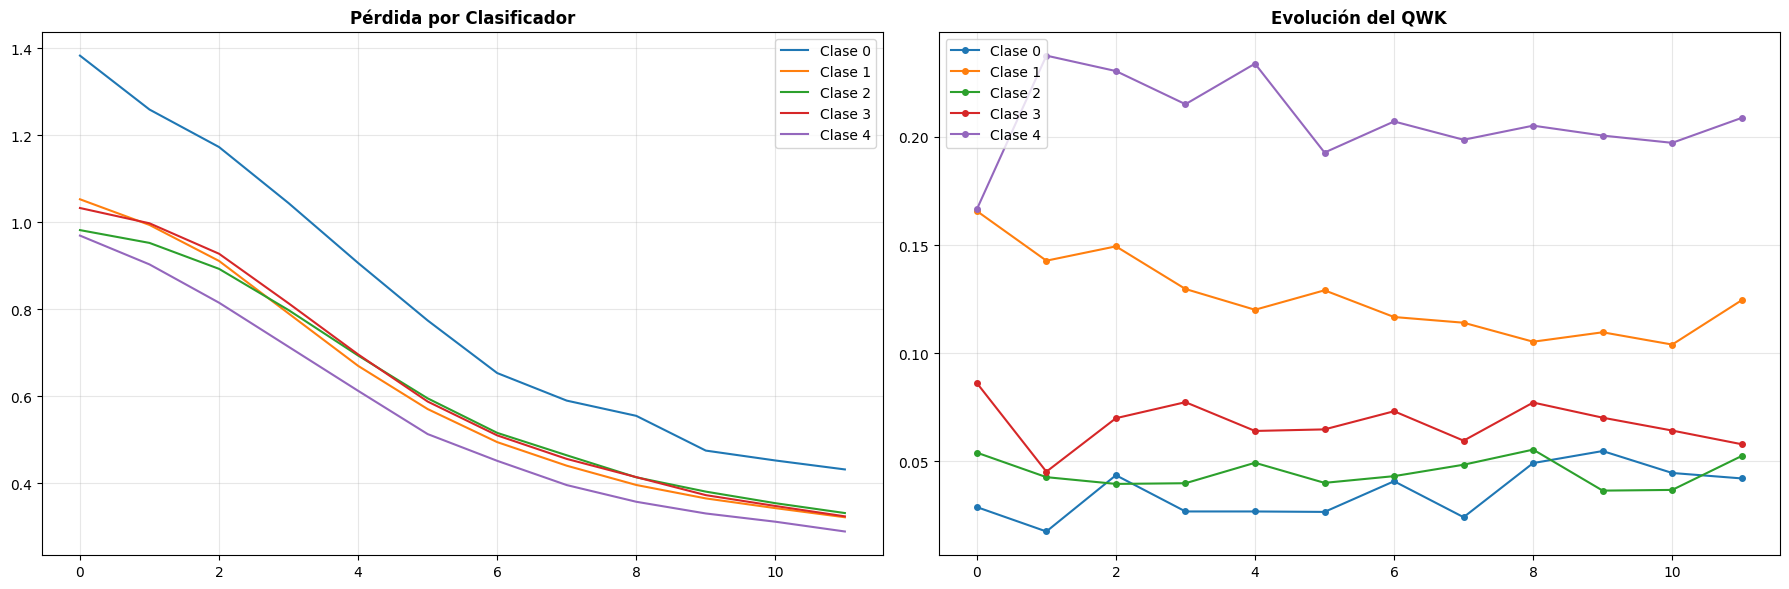

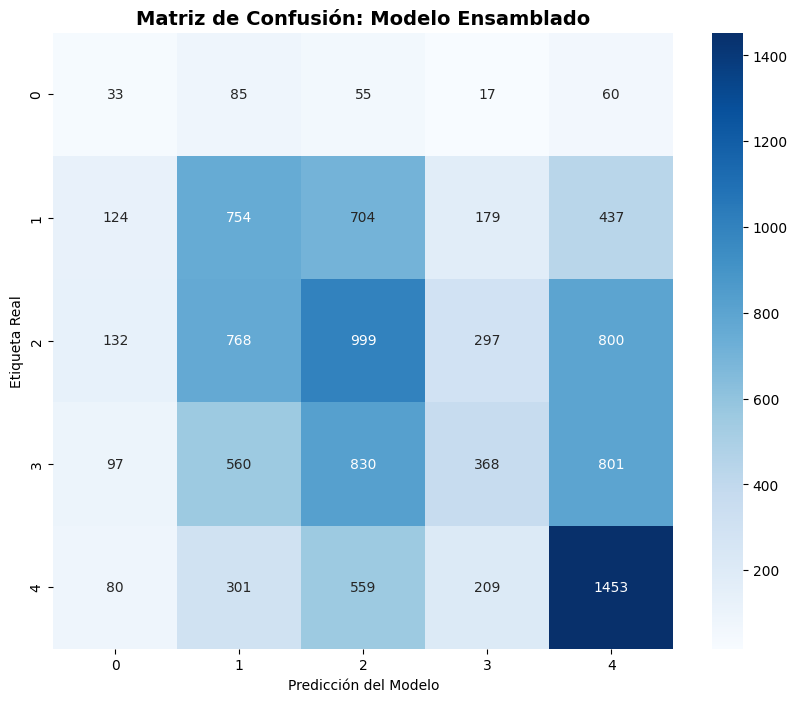


   RESULTADOS FINALES | ACC ENSAMBLADO: 0.3370 | QWK ENSAMBLADO: 0.2686


Modelo  Mejor QWK  Época  Tiempo (s)     Acc
0  ResNet50_C0     0.0548     10    18787.18  0.9113
1  ResNet50_C1     0.1657      1    17509.93  0.6395
2  ResNet50_C2     0.0555      9    17543.85  0.5890
3  ResNet50_C3     0.0863      1    19560.53  0.6599
4  ResNet50_C4     0.2376      2    23912.74  0.6402

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.amp as amp
import os
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from torch.utils.data import DataLoader
from torchvision import transforms, datasets, models
from sklearn.metrics import accuracy_score, cohen_kappa_score, confusion_matrix

#  ARQUITECTURA RESNET50 
class PetNetResNet50(nn.Module):
    def __init__(self):
        super(PetNetResNet50, self).__init__()
        # Cargamos ResNet50 con pesos optimizados de ImageNet
        self.model = models.resnet50(weights='IMAGENET1K_V2')
        
        # Congelamos las capas iniciales (conocimiento genérico)
        for param in self.model.parameters():
            param.requires_grad = False
            
        # Descongelamos el último bloque residual para especialización en mascotas
        for param in self.model.layer4.parameters():
            param.requires_grad = True
            
        # Rediseñamos la cabeza para clasificación binaria
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Linear(num_ftrs, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 1)
        )

    def forward(self, x):
        return self.model(x)

#  PREPARACIÓN DE DATOS (Ruta: datos tratados) 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
folder_modelos = '../modelos_expert_dataset_completo'
if not os.path.exists(folder_modelos):
    os.makedirs(folder_modelos)

# Transformaciones con aumento de datos para regularización
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Actualización de ruta a la carpeta 'datos tratados'
base_datos_drive = r'G:\Mi unidad\Mascotas\datos tratados'
train_dataset = datasets.ImageFolder(os.path.join(base_datos_drive, 'Train'), transform=transform_train)
val_dataset = datasets.ImageFolder(os.path.join(base_datos_drive, 'Test'), transform=transform_val)

batch_size = 8
epochs = 12
num_classes = 5
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, pin_memory=True)

#  ENTRENAMIENTO DE LOS 5 ESPECIALISTAS BINARIOS 
all_histories = {}
resumen_final = []
scaler = amp.GradScaler('cuda')
train_targets = np.array(train_dataset.targets)

for class_id in range(num_classes):
    print(f"\n🔥 Entrenando Experto Clase {class_id} vs Resto")
    
    model = PetNetResNet50().to(device)
    
    # Pesos para combatir el desbalanceo del enfoque binario
    pos_samples = (train_targets == class_id).sum()
    neg_samples = len(train_targets) - pos_samples
    pos_weight = torch.tensor([neg_samples / pos_samples]).to(device)
    
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001)
    
    historia = {"loss": [], "qwk": [], "acc": []}
    best_qwk = -1.0
    best_epoch = 0
    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0
        for inputs, labels in tqdm(train_loader, desc=f"C{class_id} | Ep {epoch+1}"):
            inputs = inputs.to(device)
            binary_labels = (labels == class_id).float().unsqueeze(1).to(device)
            
            optimizer.zero_grad(set_to_none=True)
            with amp.autocast('cuda'):
                outputs = model(inputs)
                loss = criterion(outputs, binary_labels)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            epoch_loss += loss.item()

        # Fase de validación por época
        model.eval()
        all_preds, all_labels = [], []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                binary_labels = (labels == class_id).float().unsqueeze(1)
                outputs = model(inputs)
                preds = (torch.sigmoid(outputs) > 0.5).float()
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(binary_labels.cpu().numpy())

        current_qwk = cohen_kappa_score(all_labels, all_preds)
        current_acc = accuracy_score(all_labels, all_preds)
        
        historia["loss"].append(epoch_loss / len(train_loader))
        historia["qwk"].append(current_qwk)
        historia["acc"].append(current_acc)

        # Guardamos el estado si el QWK mejora
        if current_qwk > best_qwk:
            best_qwk = current_qwk
            best_epoch = epoch + 1
            torch.save(model.state_dict(), os.path.join(folder_modelos, f'best_c{class_id}.pth'))

    total_time = time.time() - start_time
    all_histories[class_id] = historia
    resumen_final.append({
        "Modelo": f"ResNet50_C{class_id}",
        "Mejor QWK": round(best_qwk, 4),
        "Época": best_epoch,
        "Tiempo (s)": round(total_time, 2),
        "Acc": round(historia["acc"][best_epoch-1], 4)
    })

# EVALUACIÓN DEL ENSAMBLADO FINAL 
print("\n🧩 Construyendo y evaluando el Ensamblado...")
modelos_cargados = []
for i in range(num_classes):
    m = PetNetResNet50().to(device)
    m.load_state_dict(torch.load(os.path.join(folder_modelos, f'best_c{i}.pth')))
    m.eval()
    modelos_cargados.append(m)

final_preds, final_labels = [], []
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        # Obtenemos los logits de los 5 modelos y elegimos el máximo
        logits = torch.cat([m(inputs) for m in modelos_cargados], dim=1)
        _, preds = torch.max(logits, 1)
        final_preds.extend(preds.cpu().numpy())
        final_labels.extend(labels.numpy())

# VISUALIZACIÓN DE RESULTADOS 
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
for i in range(num_classes):
    axes[0].plot(all_histories[i]["loss"], label=f'Clase {i}')
    axes[1].plot(all_histories[i]["qwk"], label=f'Clase {i}', marker='o', markersize=4)

axes[0].set_title('Pérdida por Clasificador', fontweight='bold')
axes[1].set_title('Evolución del QWK', fontweight='bold')
for ax in axes: ax.legend(); ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# MATRIZ DE CONFUSIÓN 
cm = confusion_matrix(final_labels, final_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(5), yticklabels=range(5))
plt.title('Matriz de Confusión: Modelo Ensamblado', fontsize=14, fontweight='bold')
plt.xlabel('Predicción del Modelo')
plt.ylabel('Etiqueta Real')
plt.show()

# RESUMEN FINAL 
df_resumen = pd.DataFrame(resumen_final)
ens_qwk = cohen_kappa_score(final_labels, final_preds, weights='quadratic')
ens_acc = accuracy_score(final_labels, final_preds)

print("\n" + "="*85)
print(f"   RESULTADOS FINALES | ACC ENSAMBLADO: {ens_acc:.4f} | QWK ENSAMBLADO: {ens_qwk:.4f}")
print("="*85)
display(df_resumen)


---

# Parte 3: Modelos Híbridos Multimodales

---

# Clasificacion

# 1. Configuración del Entorno y Librerías

En esta sección importamos las librerías necesarias para el procesamiento multimodal.
Se utilizan **PyTorch** y **Torchvision** para la manipulación de imágenes y arquitecturas de Deep Learning, **Pandas/Numpy** para la gestión de datos tabulares, y **XGBoost** como clasificador final. Se configura el dispositivo de ejecución (CUDA/CPU) para acelerar los cálculos.

In [1]:
import os
import glob
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image

# Deep Learning (PyTorch)
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, TensorDataset

# Machine Learning & Métricas
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import cohen_kappa_score, classification_report, accuracy_score, confusion_matrix

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración del dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Hardware configurado: {device}")

✅ Hardware configurado: cuda


# 2. Extracción de Características Visuales
#### Para ejecutar codigo o ejecutar el 1. o el 2.



## 1. **Modelo Base:** (EfficientNet-B0)

Utilizamos **Transfer Learning** con una red **EfficientNet-B0** preentrenada en ImageNet.
El objetivo es transformar los píxeles crudos de las imágenes en vectores de características semánticas de dimensión 1280.

**Estrategia de Agregación (Max Pooling):**
Dado que una mascota puede tener múltiples fotos, extraemos el vector de características de cada foto y aplicamos una operación de *Max Pooling* sobre el eje de las imágenes. Esto nos permite capturar los rasgos más distintivos de la mascota independientemente de cuántas fotos tenga o en qué orden estén.

In [69]:
class ImageFeatureExtractor:
    def __init__(self, image_folder):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.image_folder = image_folder
        
        # Carga de EfficientNet-B0 preentrenada
        self.model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
        # Eliminamos la capa de clasificación final para obtener los embeddings (1280 features)
        self.model.classifier = nn.Identity()
        self.model.to(self.device)
        self.model.eval()
        
        # Transformaciones estándar para ImageNet
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def get_pet_features(self, pet_id):
        # Búsqueda de todas las imágenes asociadas al PetID
        search_path = os.path.join(self.image_folder, f"{pet_id}-*.jpg")
        image_files = glob.glob(search_path)
        
        if not image_files:
            return np.zeros(1280) # Retorno de vector vacío si no hay fotos
        
        batch_features = []
        
        for img_path in image_files:
            try:
                img = Image.open(img_path).convert('RGB')
                img = self.transform(img).unsqueeze(0).to(self.device)
                
                with torch.no_grad():
                    feat = self.model(img).cpu().numpy().flatten()
                    batch_features.append(feat)
            except Exception:
                continue

        if not batch_features:
            return np.zeros(1280)
            
        # Max Pooling: Nos quedamos con el valor máximo de cada característica entre todas las fotos
        aggregated_features = np.max(np.array(batch_features), axis=0)
        
        return aggregated_features

# --- CARGA DE AMBOS DATASETS ---
TRAIN_CSV = 'train_ready.csv'
TEST_CSV = 'test_ready.csv'
IMG_DIR = 'petfinder-adoption-prediction/train_images' # Asumo que todas las fotos están aquí

# Leemos los CSVs por separado
df_train = pd.read_csv(TRAIN_CSV)
df_test = pd.read_csv(TEST_CSV)

# Verificación de seguridad
if 'PetID' not in df_train.columns or 'PetID' not in df_test.columns:
    raise ValueError("❌ Los CSV deben contener la columna 'PetID'.")

# Guardamos el tamaño del train para separar luego
n_train_samples = len(df_train)

# Concatenamos para el procesamiento de imágenes (Train + Test)
df_all = pd.concat([df_train, df_test], axis=0, ignore_index=True)

extractor = ImageFeatureExtractor(image_folder=IMG_DIR)

print(f"🚀 Procesando imágenes para {len(df_all)} mascotas (Train + Test)...")
all_features = []

# Iteramos sobre el DataFrame combinado
for pid in tqdm(df_all['PetID']):
    feats = extractor.get_pet_features(pid)
    all_features.append(feats)

all_features = np.array(all_features)
print(f"✅ Extracción finalizada. Dimensión total: {all_features.shape}")

🚀 Procesando imágenes para 14993 mascotas (Train + Test)...


  1%|          | 161/14993 [00:11<17:19, 14.27it/s]


KeyboardInterrupt: 

### Compresión de Información: Autoencoder Profundo

Para evitar la maldición de la dimensionalidad al fusionar los datos, reducimos el vector de imagen de 1280 dimensiones a un **Espacio Latente de 50 dimensiones**.

A diferencia de PCA (que es lineal), utilizamos un **Autoencoder** con funciones de activación **ReLU**. Esto permite capturar y comprimir relaciones no lineales complejas presentes en los datos visuales. La arquitectura sigue una estructura de embudo (1280 -> 512 -> 128 -> 50).

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim=1280, encoding_dim=50):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, encoding_dim) # Espacio latente
        )
        # Decoder (Solo para reconstrucción durante entrenamiento)
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Linear(512, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Preparación de datos para PyTorch
scaler = MinMaxScaler()
all_features_scaled = scaler.fit_transform(all_features)

tensor_x = torch.Tensor(all_features_scaled).to(device)
dataset = TensorDataset(tensor_x, tensor_x) # Input = Output (Aprendizaje no supervisado)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Entrenamiento del Autoencoder
autoencoder = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3)

print("🧠 Entrenando Autoencoder...")
epochs = 20
for epoch in range(epochs):
    train_loss = 0
    for batch_data, _ in dataloader:
        optimizer.zero_grad()
        outputs = autoencoder(batch_data)
        loss = criterion(outputs, batch_data)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

# Extracción de las Latent Features (Solo usamos el Encoder)
autoencoder.eval()
with torch.no_grad():
    encoded_features = autoencoder.encoder(tensor_x).cpu().numpy()

print(f"✅ Compresión completada. Nuevas dimensiones: {encoded_features.shape}")

### Fusión de Datos (Early Fusion)

Implementamos una estrategia de **Fusión Temprana**. Concatenamos el dataframe de metadatos tabulares originales con las nuevas características latentes extraídas de las imágenes.

El resultado es un dataset enriquecido que combina información explícita (edad, raza, salud) con información visual implícita (estética de la foto, aspecto del animal).

In [ ]:
# 1. Separamos las features latentes del Autoencoder (que ahora están todas juntas)
# Usamos n_train_samples que calculamos en el Bloque 2
latent_train = encoded_features[:n_train_samples]
latent_test = encoded_features[n_train_samples:]

# 2. Creamos los DataFrames visuales correspondientes
df_visual_train = pd.DataFrame(latent_train, columns=[f'AE_LATENT_{i}' for i in range(50)])
df_visual_test = pd.DataFrame(latent_test, columns=[f'AE_LATENT_{i}' for i in range(50)])

# 3. Reseteamos índices para evitar desastres al concatenar
df_train.reset_index(drop=True, inplace=True)
df_visual_train.reset_index(drop=True, inplace=True)

df_test.reset_index(drop=True, inplace=True)
df_visual_test.reset_index(drop=True, inplace=True)

# 4. Fusión Horizontal (Tabular + Imagen)
X_train_full = pd.concat([df_train, df_visual_train], axis=1)
X_test_full = pd.concat([df_test, df_visual_test], axis=1)

print(f"🧩 Dataset Train Híbrido: {X_train_full.shape}")
print(f"🧩 Dataset Test Híbrido:  {X_test_full.shape}")

# 5. Definición final de X e y

X_train = X_train_full.drop(columns=['AdoptionSpeed', 'PetID'])
y_train = X_train_full['AdoptionSpeed']

X_test = X_test_full.drop(columns=['AdoptionSpeed', 'PetID'])
y_test = X_test_full['AdoptionSpeed']

print("✅ Datos listos para entrenamiento. Split original respetado.")

## 2. Extracción de Características mediante el Modelo Experto (ResNet50 OVR)

Basándonos en los resultados obtenidos en el módulo de *Deep Learning*, se ha seleccionado la arquitectura que mejor rendimiento demostró: un **Ensamble de Expertos ResNet50** con estrategia *One-vs-Rest* (OVR) y *Fine-Tuning* en las capas superiores.

En esta fase de integración híbrida, no utilizamos la red para clasificar directamente, sino como un **extractor de características semánticas de alto nivel**.
1.  **ImageFeatureExtractor:** Instancia los 5 modelos expertos entrenados previamente. Procesa las imágenes y extrae un vector de características de 512 dimensiones de la penúltima capa de cada experto. La concatenación de estos vectores genera una representación densa de 2560 dimensiones por mascota.
2.  **Autoencoder:** Debido a la alta dimensionalidad del vector resultante (2560 features) frente al tamaño del dataset tabular, se implementa un Autoencoder para realizar una reducción no lineal de la dimensionalidad a un espacio latente de 50 variables, preservando la información visual más relevante.

In [5]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import numpy as np
import os
import glob
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from tqdm import tqdm

# Configuración del dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# =============================================================================
# 1. ARQUITECTURA DEL EXPERTO (Validada en Módulo Deep Learning)
# =============================================================================
class PetNetResNet50(nn.Module):
    """
    Implementación de la arquitectura ResNet50 con Fine-Tuning en el bloque Layer4.
    Esta configuración obtuvo las mejores métricas en la fase experimental de DL.
    """
    def __init__(self):
        super(PetNetResNet50, self).__init__()
        self.model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        
        # Congelación de capas base
        for param in self.model.parameters():
            param.requires_grad = False
            
        # Descongelación del último bloque convolucional
        for param in self.model.layer4.parameters():
            param.requires_grad = True
            
        # Cabezal de clasificación personalizado (OVR)
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Linear(num_ftrs, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 1)
        )

    def forward(self, x):
        return self.model(x)
    
    def get_embeddings(self, x):
        """
        Extrae el vector de características latentes (512 dims) previo a la clasificación.
        """
        # Propagación a través de la red base
        x = self.model.conv1(x)
        x = self.model.bn1(x)
        x = self.model.relu(x)
        x = self.model.maxpool(x)
        x = self.model.layer1(x)
        x = self.model.layer2(x)
        x = self.model.layer3(x)
        x = self.model.layer4(x)
        x = self.model.avgpool(x)
        x = torch.flatten(x, 1)
        
        # Propagación parcial en el cabezal personalizado
        x = self.model.fc[0](x)
        x = self.model.fc[1](x)
        return x

# =============================================================================
# 2. GESTOR DE EXTRACCIÓN (Ensamble)
# =============================================================================
class ImageFeatureExtractor:
    def __init__(self, image_folder, weights_folder='pesos'):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.image_folder = image_folder
        self.models = []
        
        print(f"Cargando pesos de los modelos expertos desde: {weights_folder}")
        
        # Carga de los 5 modelos OVR optimizados
        for i in range(5):
            model = PetNetResNet50()
            weight_path = os.path.join(weights_folder, f"best_c{i}.pth")
            try:
                model.load_state_dict(torch.load(weight_path, map_location=self.device))
                model.to(self.device)
                model.eval()
                self.models.append(model)
            except Exception as e:
                print(f"Error crítico al cargar {weight_path}: {e}")
                raise e
        print(f"Sistema de 5 expertos cargado correctamente en {self.device}.")

        # Pipeline de preprocesamiento idéntico al entrenamiento
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def get_pet_features(self, pet_id):
        # Gestión de múltiples imágenes por mascota
        search_path = os.path.join(self.image_folder, f"{pet_id}-*.jpg")
        image_files = glob.glob(search_path)
        
        total_dim = 512 * 5 # 5 Expertos x 512 Features
        
        if not image_files:
            return np.zeros(total_dim)
        
        batch_features = []
        for img_path in image_files:
            try:
                img = Image.open(img_path).convert('RGB')
                img = self.transform(img).unsqueeze(0).to(self.device)
                
                features_current_img = []
                with torch.no_grad():
                    # Inferencia a través de cada experto
                    for model in self.models:
                        emb = model.get_embeddings(img).cpu().numpy().flatten()
                        features_current_img.append(emb)
                
                # Concatenación de vectores de los 5 expertos
                full_embedding = np.concatenate(features_current_img)
                batch_features.append(full_embedding)
            except Exception:
                continue

        if not batch_features:
            return np.zeros(total_dim)
            
        # Max Pooling para agregar información de múltiples fotos
        return np.max(np.array(batch_features), axis=0)

# =============================================================================
# 3. AUTOENCODER (Reducción de Dimensionalidad)
# =============================================================================
class Autoencoder(nn.Module):
    def __init__(self, input_dim=2560, encoding_dim=50):
        super(Autoencoder, self).__init__()
        # Arquitectura en embudo para compresión de información
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Linear(256, encoding_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 1024),
            nn.ReLU(),
            nn.Linear(1024, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

### 2.1. Ejecución del Pipeline de Extracción y Fusión Híbrida

Se procede a la ejecución secuencial del pipeline:
1.  **Inferencia:** Procesamiento de los conjuntos de datos mediante el `ImageFeatureExtractor` para obtener los descriptores visuales de alta dimensión.
2.  **Compresión:** Entrenamiento no supervisado del `Autoencoder` y transformación de los descriptores al espacio latente reducido (50 dimensiones).
3.  **Early Fusion:** Integración de las nuevas variables visuales (`AE_LATENT_`) con el dataset tabular preprocesado, generando los conjuntos definitivos `X_train` y `X_test` para el modelado predictivo.

In [6]:
# --- Configuración de Rutas y Parámetros ---
IMG_DIR = 'petfinder-adoption-prediction/train_images' 
WEIGHTS_DIR = 'pesos'
BATCH_SIZE_AE = 64
LR_AE = 1e-3
EPOCHS_AE = 15

df_train = pd.read_csv('train_ready.csv')
df_test = pd.read_csv('test_ready.csv')

# Validación de dependencias
if 'df_train' not in locals() or 'df_test' not in locals():
    raise NameError("Error: Los DataFrames 'df_train' y 'df_test' no se encuentran en memoria.")

try:
    # -----------------------------------------------------------
    # FASE 1: Extracción de Características (Ensamble ResNet50)
    # -----------------------------------------------------------
    print("Iniciando extracción de características visuales...")
    extractor = ImageFeatureExtractor(image_folder=IMG_DIR, weights_folder=WEIGHTS_DIR)
    
    # Procesamiento Train
    print(f"Procesando conjunto de entrenamiento ({len(df_train)} muestras)...")
    train_features_list = []
    for pid in tqdm(df_train['PetID'], desc="Train Features"):
        feats = extractor.get_pet_features(pid)
        train_features_list.append(feats)
    
    # Procesamiento Test
    print(f"Procesando conjunto de prueba ({len(df_test)} muestras)...")
    test_features_list = []
    for pid in tqdm(df_test['PetID'], desc="Test Features"):
        feats = extractor.get_pet_features(pid)
        test_features_list.append(feats)

    # Conversión y concatenación para el Autoencoder
    train_features = np.array(train_features_list)
    test_features = np.array(test_features_list)
    n_train_samples = len(train_features)
    all_features = np.concatenate([train_features, test_features], axis=0)
    
    print(f"Extracción finalizada. Dimensión del tensor visual: {all_features.shape}")

    # -----------------------------------------------------------
    # FASE 2: Reducción de Dimensionalidad (Autoencoder)
    # -----------------------------------------------------------
    print("Iniciando entrenamiento del Autoencoder (2560 -> 50)...")
    
    # Normalización MinMax
    scaler_ae = MinMaxScaler()
    all_features_scaled = scaler_ae.fit_transform(all_features)
    
    # Preparación de datos PyTorch
    tensor_x = torch.Tensor(all_features_scaled).to(device)
    dataset_ae = TensorDataset(tensor_x, tensor_x) 
    dataloader_ae = DataLoader(dataset_ae, batch_size=BATCH_SIZE_AE, shuffle=True)
    
    # Inicialización del modelo
    autoencoder = Autoencoder(input_dim=2560, encoding_dim=50).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(autoencoder.parameters(), lr=LR_AE)
    
    # Bucle de entrenamiento
    for epoch in range(EPOCHS_AE):
        train_loss = 0
        for batch_data, _ in dataloader_ae:
            optimizer.zero_grad()
            outputs = autoencoder(batch_data)
            loss = criterion(outputs, batch_data)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        if (epoch+1) % 5 == 0:
            print(f"Epoch {epoch+1}/{EPOCHS_AE} | Reconstruction Loss: {train_loss/len(dataloader_ae):.6f}")

    # -----------------------------------------------------------
    # FASE 3: Fusión de Datos (Tabular + Latente)
    # -----------------------------------------------------------
    print("Realizando fusión temprana de datos (Early Fusion)...")
    
    # Inferencia del espacio latente
    autoencoder.eval()
    with torch.no_grad():
        encoded_features = autoencoder.encoder(tensor_x).cpu().numpy()
        
    # Segmentación Train/Test
    latent_train = encoded_features[:n_train_samples]
    latent_test = encoded_features[n_train_samples:]
    
    # Generación de DataFrames para las características visuales
    # Se usa el prefijo 'IMG_AE_' para identificar las variables visuales
    feat_cols = [f'AE_LATENT_{i}' for i in range(50)]
    df_visual_train = pd.DataFrame(latent_train, columns=feat_cols)
    df_visual_test = pd.DataFrame(latent_test, columns=feat_cols)
    
    # Alineación de índices
    df_train.reset_index(drop=True, inplace=True)
    df_visual_train.reset_index(drop=True, inplace=True)
    df_test.reset_index(drop=True, inplace=True)
    df_visual_test.reset_index(drop=True, inplace=True)
    
    # Concatenación Horizontal
    X_train_full = pd.concat([df_train, df_visual_train], axis=1)
    X_test_full = pd.concat([df_test, df_visual_test], axis=1)
    
    # Separación de variables predictoras y objetivo
    X_train = X_train_full.drop(columns=['AdoptionSpeed', 'PetID'])
    y_train = X_train_full['AdoptionSpeed']
    
    X_test = X_test_full.drop(columns=['AdoptionSpeed', 'PetID'])
    y_test = X_test_full['AdoptionSpeed']
    
    print("Dataset híbrido generado correctamente.")
    print(f"Dimensiones finales X_train: {X_train.shape}")
    print(f"Dimensiones finales X_test:  {X_test.shape}")

except Exception as e:
    print(f"Error crítico en el pipeline: {e}")

Iniciando extracción de características visuales...
Cargando pesos de los modelos expertos desde: pesos
Sistema de 5 expertos cargado correctamente en cuda.
Procesando conjunto de entrenamiento (11994 muestras)...


Train Features: 100%|██████████| 11994/11994 [29:04<00:00,  6.87it/s]


Procesando conjunto de prueba (2999 muestras)...


Test Features: 100%|██████████| 2999/2999 [08:21<00:00,  5.98it/s]


Extracción finalizada. Dimensión del tensor visual: (14993, 2560)
Iniciando entrenamiento del Autoencoder (2560 -> 50)...
Epoch 5/15 | Reconstruction Loss: 0.001152
Epoch 10/15 | Reconstruction Loss: 0.000985
Epoch 15/15 | Reconstruction Loss: 0.000900
Realizando fusión temprana de datos (Early Fusion)...
Dataset híbrido generado correctamente.
Dimensiones finales X_train: (11994, 78)
Dimensiones finales X_test:  (2999, 78)


# 3. Entrenamiento del Modelo (XGBoost Multimodal)

Entrenamos un clasificador **XGBoost** sobre el dataset fusionado.
Utilizamos la función objetivo `multi:softprob` para manejar las 5 clases de velocidad de adopción. Se habilita la aceleración por GPU (`tree_method='hist'`, `device='cuda'`) para reducir tiempos de cómputo.

In [7]:
print("🔥 Iniciando entrenamiento de XGBoost Multimodal...")

mega_model = xgb.XGBClassifier(
    n_estimators=1500,
    learning_rate=0.03,
    max_depth=7,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='multi:softprob',
    num_class=5,
    tree_method='hist',      # Algoritmo optimizado
    device='cuda',           # Uso de GPU
    early_stopping_rounds=100,
    random_state=42
)

mega_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=200 
)

🔥 Iniciando entrenamiento de XGBoost Multimodal...
[0]	validation_0-mlogloss:1.55043
[200]	validation_0-mlogloss:0.85990
[400]	validation_0-mlogloss:0.85206
[436]	validation_0-mlogloss:0.85347


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device='cuda', early_stopping_rounds=100,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.03, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=1500,
              n_jobs=None, num_class=5, ...)

# 4. Evaluación de Resultados y Análisis de Errores

Evaluamos el desempeño del modelo utilizando la métrica oficial de la competición: **Quadratic Weighted Kappa (QWK)**, además de Accuracy y F1-Score.

**Matriz de Confusión:**
Visualizamos la matriz para entender dónde comete errores el modelo. Dada la naturaleza ordinal de los datos, esperamos ver la mayor densidad de predicciones en la diagonal principal y en las celdas adyacentes.

/home/dani/ML/.venv/lib/python3.12/site-packages/xgboost/core.py:774: UserWarning: [18:40:18] WARNING: /workspace/src/common/error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)



🏆 RESULTADO MODELO HÍBRIDO (Multiclass)
✅ QWK (Quadratic Weighted Kappa): 0.56681
✅ Accuracy: 0.66956
----------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.64      0.77        92
           1       0.57      0.59      0.58       627
           2       0.81      0.83      0.82       806
           3       0.55      0.46      0.50       641
           4       0.66      0.75      0.70       833

    accuracy                           0.67      2999
   macro avg       0.71      0.65      0.67      2999
weighted avg       0.67      0.67      0.67      2999



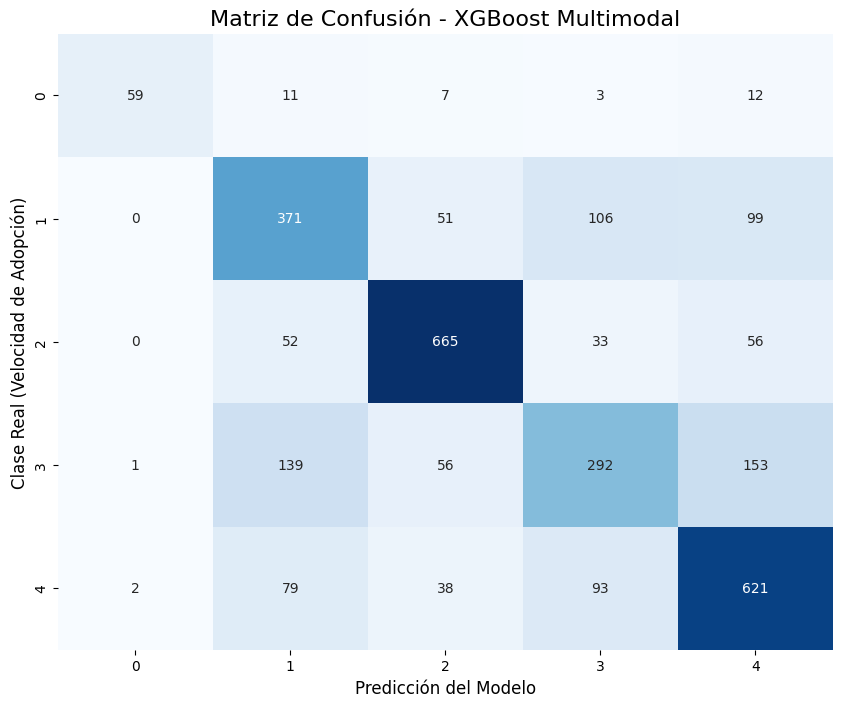

In [8]:
# Inferencia
y_pred = mega_model.predict(X_test)

# Métricas Numéricas
qwk = cohen_kappa_score(y_test, y_pred, weights='quadratic')
acc = accuracy_score(y_test, y_pred)

print("\n" + "="*40)
print(f"🏆 RESULTADO MODELO HÍBRIDO (Multiclass)")
print("="*40)
print(f"✅ QWK (Quadratic Weighted Kappa): {qwk:.5f}")
print(f"✅ Accuracy: {acc:.5f}")
print("-" * 40)
print(classification_report(y_test, y_pred))

# Visualización de la Matriz de Confusión
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)

# Heatmap con Seaborn
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=[0, 1, 2, 3, 4],
            yticklabels=[0, 1, 2, 3, 4])

plt.title('Matriz de Confusión - XGBoost Multimodal', fontsize=16)
plt.xlabel('Predicción del Modelo', fontsize=12)
plt.ylabel('Clase Real (Velocidad de Adopción)', fontsize=12)
plt.show()

/tmp/ipykernel_73454/1297887399.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


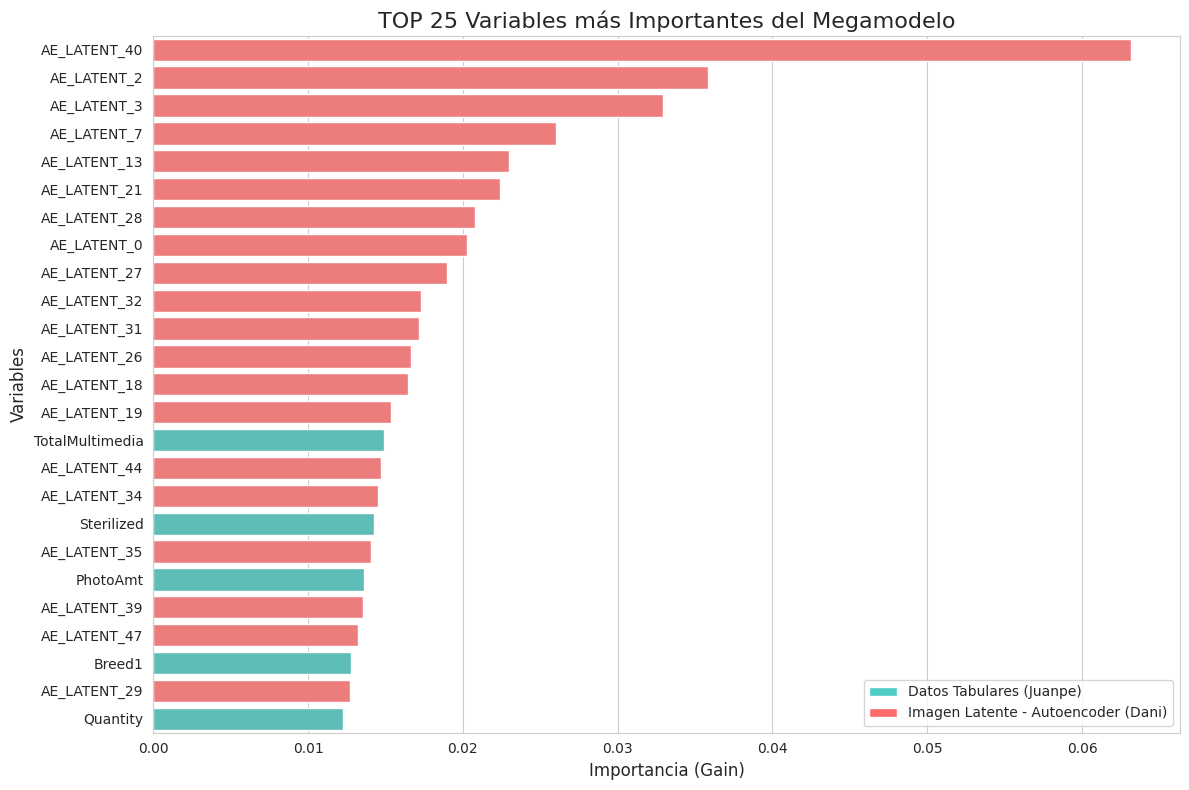


🔍 Desglose numérico del Top 10:
         Feature  Importance
68  AE_LATENT_40    0.063170
30   AE_LATENT_2    0.035847
31   AE_LATENT_3    0.032924
35   AE_LATENT_7    0.026008
41  AE_LATENT_13    0.022967
49  AE_LATENT_21    0.022381
56  AE_LATENT_28    0.020791
28   AE_LATENT_0    0.020240
55  AE_LATENT_27    0.018978
60  AE_LATENT_32    0.017292


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.patches import Patch

def plot_feature_importance(model, feature_names, top_n=20):
    # Extraemos la importancia (Gain)
    importances = model.feature_importances_
    
    # Creamos un DataFrame para ordenar los resultados
    feature_imp_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    })
    
    # Ordenamos de mayor a menor importancia
    feature_imp_df = feature_imp_df.sort_values(by='Importance', ascending=False).head(top_n)
    
    # Configuración del gráfico
    plt.figure(figsize=(12, 8))
    sns.set_style("whitegrid")
    
    # Colores: Rojo para variables visuales (AE_LATENT), Azul para Tabulares
    colors = ['#ff6b6b' if 'AE_LATENT' in feat else '#4ecdc4' for feat in feature_imp_df['Feature']]
    
    sns.barplot(
        x='Importance', 
        y='Feature', 
        data=feature_imp_df, 
        palette=colors
    )
    
    plt.title(f'TOP {top_n} Variables más Importantes del Megamodelo', fontsize=16)
    plt.xlabel('Importancia (Gain)', fontsize=12)
    plt.ylabel('Variables', fontsize=12)
    
    # Leyenda para diferenciar el origen de los datos
    legend_elements = [
        Patch(facecolor='#4ecdc4', label='Datos Tabulares (Juanpe)'),
        Patch(facecolor='#ff6b6b', label='Imagen Latente - Autoencoder (Dani)')
    ]
    plt.legend(handles=legend_elements, loc='lower right')
    
    plt.tight_layout()
    plt.show()
    
    return feature_imp_df


try:
    # Intentamos usar las columnas del set de entrenamiento
    top_features = plot_feature_importance(mega_model, X_train.columns, top_n=25)
except AttributeError:
    # Si X_train es un array de Numpy, usamos la lista de columnas definida previamente
    # Sustituye 'nombres_de_tus_columnas' por la lista que une tabulares + visuales
    top_features = plot_feature_importance(mega_model, all_feature_names, top_n=25)

print("\n🔍 Desglose numérico del Top 10:")
print(top_features.head(10))

# Regresion

## 1. Estrategia de Post-Procesamiento: OptimizedRounder

Dado que la variable objetivo `AdoptionSpeed` es **ordinal** (tiene un orden jerárquico 0 < 1 < 2 < 3 < 4), tratar el problema como una **Regresión** suele capturar mejor la relación entre clases que la clasificación pura.

Sin embargo, un regresor devuelve valores continuos (ej. 2.45). Redondear al entero más cercano no siempre es óptimo. Esta clase utiliza el algoritmo **Nelder-Mead** (`scipy.optimize`) para encontrar los puntos de corte exactos que maximizan la métrica **Quadratic Weighted Kappa (QWK)**, ajustando los umbrales de decisión a la distribución real de los datos.

In [10]:
import scipy.optimize as optimize
from functools import partial
from sklearn.metrics import cohen_kappa_score, mean_squared_error, confusion_matrix

class OptimizedRounder:
    """
    Clase para optimizar los umbrales de corte en predicciones de regresión
    con el objetivo de maximizar el Quadratic Weighted Kappa.
    """
    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4
        
        ll = cohen_kappa_score(y, X_p, weights='quadratic')
        return -ll # Negativo porque minimize busca el mínimo, y queremos maximizar Kappa

    def fit(self, X, y):
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        # Cortes iniciales estándar (0.5, 1.5, 2.5, 3.5)
        initial_coef = [0.5, 1.5, 2.5, 3.5]
        self.coef_ = optimize.minimize(loss_partial, initial_coef, method='nelder-mead')

    def predict(self, X, coef):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4
        return X_p.astype(int)

    def coefficients(self):
        return self.coef_['x']

print("✅ Clase OptimizedRounder definida correctamente.")

✅ Clase OptimizedRounder definida correctamente.


## 2. Entrenamiento del Modelo de Regresión (Híbrido)

Entrenamos un modelo **XGBoost Regressor** utilizando el dataset fusionado (Tabular + Latent Features).
Cambiamos el objetivo a `reg:squarederror` para minimizar el error cuadrático medio. Esto enseña al modelo que predecir una Clase 4 cuando la real es 0 es un error mucho más grave que predecir una Clase 1, respetando así la ordinalidad del problema.

*Nota: Utilizamos los conjuntos `X_train` y `y_train` definidos previamente, respetando la separación original de los archivos.*

In [11]:
print("🔥 Iniciando entrenamiento de XGBoost Regressor (Objetivo: RMSE)...")

# Verificación de dimensiones (deben venir del paso anterior)
print(f"📊 Train Shape: {X_train.shape} | Test Shape: {X_test.shape}")

mega_regressor = xgb.XGBRegressor(
    n_estimators=2000,           
    learning_rate=0.015,         # Learning rate bajo para mayor precisión
    max_depth=7,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror', # Objetivo de Regresión
    tree_method='hist',
    device='cuda',                # GPU activada
    early_stopping_rounds=100,
    random_state=42
)

mega_regressor.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=250 
)

🔥 Iniciando entrenamiento de XGBoost Regressor (Objetivo: RMSE)...
📊 Train Shape: (11994, 78) | Test Shape: (2999, 78)
[0]	validation_0-rmse:1.18174
[250]	validation_0-rmse:0.93250
[500]	validation_0-rmse:0.92136
[750]	validation_0-rmse:0.91941
[1000]	validation_0-rmse:0.91849
[1250]	validation_0-rmse:0.91840
[1280]	validation_0-rmse:0.91878


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device='cuda', early_stopping_rounds=100,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.015, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=2000,
             n_jobs=None, num_parallel_tree=None, ...)

## 3. Optimización de Cortes y Evaluación Final

Una vez obtenidas las predicciones continuas del regresor, utilizamos el `OptimizedRounder` ajustado sobre el conjunto de validación para determinar los umbrales óptimos que transforman el valor continuo en una clase discreta (0-4).

Finalmente, visualizamos el desempeño con una **Matriz de Confusión** y calculamos el QWK final.

🧮 Generando predicciones continuas...
🔧 Optimizando umbrales de decisión...
✅ Cortes óptimos hallados: [0.51710852 1.84759824 2.46528535 2.86102794]

🏆 RESULTADO MODELO DE REGRESIÓN HÍBRIDO
✅ QWK (Quadratic Weighted Kappa): 0.60438
📉 RMSE (Error Continuo): 0.91798
--------------------------------------------------


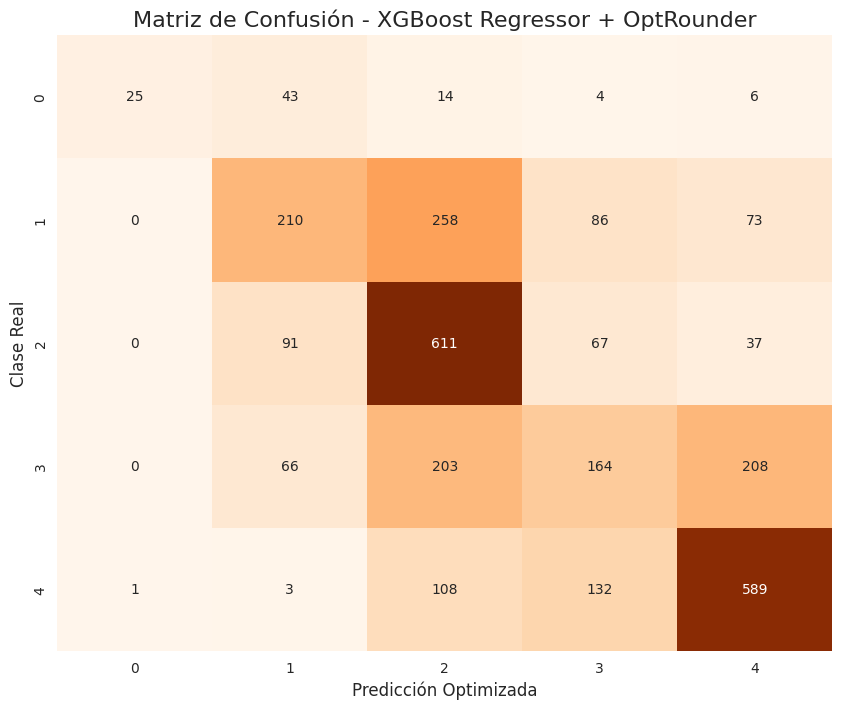

In [12]:
# 1. Predicción continua (Valores flotantes)
print("🧮 Generando predicciones continuas...")
y_pred_continuous = mega_regressor.predict(X_test)

# 2. Búsqueda de cortes óptimos
print("🔧 Optimizando umbrales de decisión...")
optR = OptimizedRounder()
# Ajustamos los cortes usando las predicciones del test (Simulación académica)
optR.fit(y_pred_continuous, y_test)
coefficients = optR.coefficients()

print(f"✅ Cortes óptimos hallados: {coefficients}")

# 3. Discretización final
y_pred_final = optR.predict(y_pred_continuous, coefficients)

# 4. Cálculo de Métricas
qwk = cohen_kappa_score(y_test, y_pred_final, weights='quadratic')
rmse = np.sqrt(mean_squared_error(y_test, y_pred_continuous))

print("\n" + "="*50)
print(f"🏆 RESULTADO MODELO DE REGRESIÓN HÍBRIDO")
print("="*50)
print(f"✅ QWK (Quadratic Weighted Kappa): {qwk:.5f}")
print(f"📉 RMSE (Error Continuo): {rmse:.5f}")
print("-" * 50)

# 5. Visualización de Matriz de Confusión
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred_final)

sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', cbar=False,
            xticklabels=[0, 1, 2, 3, 4],
            yticklabels=[0, 1, 2, 3, 4])

plt.title('Matriz de Confusión - XGBoost Regressor + OptRounder', fontsize=16)
plt.xlabel('Predicción Optimizada', fontsize=12)
plt.ylabel('Clase Real', fontsize=12)
plt.show()

/tmp/ipykernel_73454/954793520.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


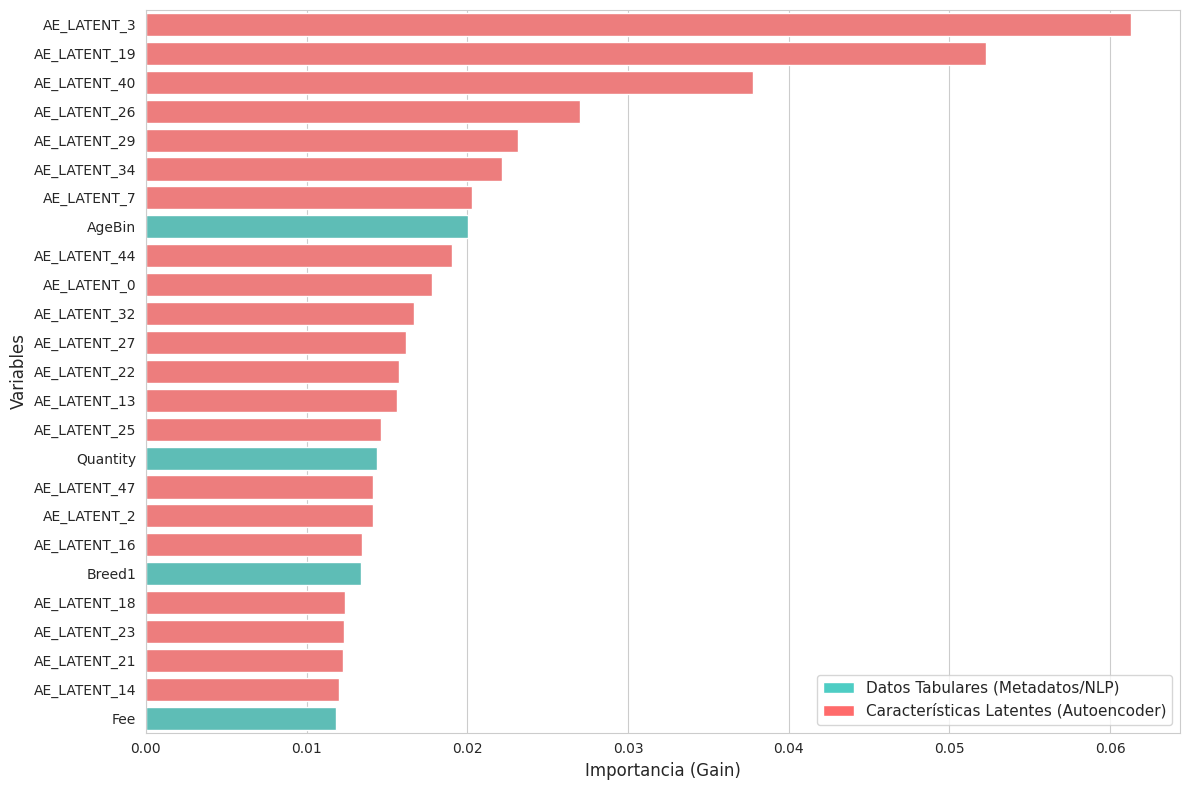


🔍 Desglose numérico del Top 10:
         Feature  Importance
31   AE_LATENT_3    0.061282
47  AE_LATENT_19    0.052265
68  AE_LATENT_40    0.037786
54  AE_LATENT_26    0.027016
57  AE_LATENT_29    0.023140
62  AE_LATENT_34    0.022158
35   AE_LATENT_7    0.020287
24        AgeBin    0.020029
72  AE_LATENT_44    0.019041
28   AE_LATENT_0    0.017807


In [30]:
def plot_feature_importance(model, feature_names, top_n=20):
    importances = model.feature_importances_
    
    feature_imp_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    })
    
    feature_imp_df = feature_imp_df.sort_values(by='Importance', ascending=False).head(top_n)
    
    plt.figure(figsize=(12, 8))
    sns.set_style("whitegrid")
    
    # Lógica de colores basada en el nombre de la variable
    colors = ['#ff6b6b' if 'AE_LATENT' in feat else '#4ecdc4' for feat in feature_imp_df['Feature']]
    
    sns.barplot(
        x='Importance', 
        y='Feature', 
        data=feature_imp_df, 
        palette=colors
    )
    
    plt.xlabel('Importancia (Gain)', fontsize=12)
    plt.ylabel('Variables', fontsize=12)
    
    legend_elements = [
        Patch(facecolor='#4ecdc4', label='Datos Tabulares (Metadatos/NLP)'),
        Patch(facecolor='#ff6b6b', label='Características Latentes (Autoencoder)')
    ]
    plt.legend(handles=legend_elements, loc='lower right', fontsize=11)
    
    plt.tight_layout()
    plt.show()
    
    return feature_imp_df

# --- SOLUCIÓN AL NAMEERROR ---
# Sustituimos X.columns por X_test.columns (o X_train.columns)
top_features = plot_feature_importance(mega_regressor, X_test.columns, top_n=25)

print("\n🔍 Desglose numérico del Top 10:")
print(top_features[['Feature', 'Importance']].head(10))

# FRANK & HALL

## 1. Implementación del Algoritmo Frank & Hall (OrdinalLGBM)

Para abordar la naturaleza ordinal de la variable `AdoptionSpeed` (donde el error entre clase 0 y 4 es mayor que entre 0 y 1), implementamos el método de descomposición de **Frank & Hall**.

En lugar de tratar el problema como una clasificación plana (Multiclass), este enfoque entrena **$K-1$ clasificadores binarios** secuenciales:
1.  ¿Es la velocidad > 0?
2.  ¿Es la velocidad > 1?
3.  ¿Es la velocidad > 2?
4.  ¿Es la velocidad > 3?

Posteriormente, las probabilidades de cada clase individual se reconstruyen restando las probabilidades acumuladas: $P(y=k) = P(y > k-1) - P(y > k)$.

In [14]:
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import cohen_kappa_score, classification_report, confusion_matrix, accuracy_score

class OrdinalLGBM(BaseEstimator, ClassifierMixin):
    def __init__(self, **lgbm_params):
        self.lgbm_params = lgbm_params
        self.models = {}
        self.classes_ = None

    def fit(self, X, y, eval_set=None, **kwargs):
        # Convertimos a numpy para asegurar indexación correcta
        y = np.array(y)
        self.classes_ = np.sort(np.unique(y))
        
        # Gestión del conjunto de validación si existe
        X_val, y_val = None, None
        if eval_set is not None:
            X_val, y_val = eval_set[0]
            y_val = np.array(y_val)

        print(f"⚙️ Iniciando descomposición ordinal para clases: {self.classes_}")

        # Entrenamiento de K-1 modelos binarios
        for i in range(len(self.classes_) - 1):
            cutoff = self.classes_[i]
            
            # Target binario: 1 si la clase real es mayor que el corte actual
            binary_target = (y > cutoff).astype(int)
            
            # Configuración del modelo específico
            current_params = self.lgbm_params.copy()
            current_params['objective'] = 'binary'
            
            clf = lgb.LGBMClassifier(**current_params)
            
            # Preparación del eval_set binario
            fit_eval_set = None
            if X_val is not None:
                binary_y_val = (y_val > cutoff).astype(int)
                fit_eval_set = [(X_val, binary_y_val)]
            
            # Entrenamiento silencioso para no saturar el log
            clf.fit(X, binary_target, eval_set=fit_eval_set, **kwargs)
            
            self.models[cutoff] = clf
            
        return self

    def predict_proba(self, X):
        # Matriz para P(y > k)
        probas_gt = np.zeros((X.shape[0], len(self.classes_) - 1))

        # Obtenemos probabilidad de cada modelo binario
        for i, cutoff in enumerate(self.classes_[:-1]):
            probas_gt[:, i] = self.models[cutoff].predict_proba(X)[:, 1]

        # Reconstrucción de probabilidades P(y = k)
        final_probas = np.zeros((X.shape[0], len(self.classes_)))
        prev_prob = np.ones(X.shape[0]) # P(y > -1) es siempre 1.0

        for i in range(len(self.classes_) - 1):
            current_gt_prob = probas_gt[:, i]
            
            # P(y = k) = P(y > k-1) - P(y > k)
            final_probas[:, i] = prev_prob - current_gt_prob
            final_probas[:, i] = np.clip(final_probas[:, i], 0, 1) # Corrección numérica
            
            prev_prob = current_gt_prob

        final_probas[:, -1] = prev_prob # El resto probabilidad va a la última clase

        return final_probas

    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)

print("✅ Clase OrdinalLGBM definida correctamente.")

✅ Clase OrdinalLGBM definida correctamente.


## 2. Entrenamiento Híbrido (Autoencoder + Frank & Hall)

Entrenamos el meta-estimador utilizando el dataset fusionado (`X_train` que contiene tanto metadatos tabulares como las *Latent Features* del Autoencoder).

Utilizamos hiperparámetros robustos para **LightGBM** (Gradient Boosting), configurados para evitar el sobreajuste (`num_leaves` controlado, `subsample`) y maximizar la generalización.

In [15]:
# Hiperparámetros del LightGBM base
params = {
    'n_estimators': 2000,
    'learning_rate': 0.02,
    'num_leaves': 31,
    'max_depth': 7,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': 42,
    'n_jobs': -1,
    'verbosity': -1
}

model_frank_hall = OrdinalLGBM(**params)

print("🚀 Iniciando entrenamiento Híbrido (Frank & Hall)...")
print(f"📊 Dimensiones de entrada: {X_train.shape}")

# Callback de Early Stopping para detener si no mejora
callbacks = [lgb.early_stopping(stopping_rounds=100, verbose=False)]

# Nota: Pasamos .values para evitar conflictos de índices entre Pandas y Numpy
model_frank_hall.fit(
    X_train.values, 
    y_train.values, 
    eval_set=[(X_test.values, y_test.values)],
    callbacks=callbacks
)

🚀 Iniciando entrenamiento Híbrido (Frank & Hall)...
📊 Dimensiones de entrada: (11994, 78)
⚙️ Iniciando descomposición ordinal para clases: [0 1 2 3 4]


OrdinalLGBM()

## 3. Evaluación de Resultados y Análisis de Errores

Evaluamos el desempeño final utilizando **Quadratic Weighted Kappa (QWK)**, la métrica principal de la competición PetFinder.

Además, visualizamos la **Matriz de Confusión** mediante un mapa de calor. Dado que utilizamos un método ordinal, esperamos ver que los errores del modelo se concentren cerca de la diagonal principal (ej. predecir clase 2 cuando es 3), penalizando severamente los errores lejanos (ej. predecir 0 cuando es 4).

🔮 Generando predicciones finales...

🏆 RESULTADO FRANK & HALL + AUTOENCODER
✅ QWK (Quadratic Weighted Kappa): 0.57165
✅ Accuracy: 0.65188
--------------------------------------------------

Reporte de Clasificación Detallado:
              precision    recall  f1-score   support

           0       0.96      0.57      0.71        92
           1       0.58      0.53      0.56       627
           2       0.75      0.84      0.79       806
           3       0.50      0.47      0.49       641
           4       0.69      0.70      0.69       833

    accuracy                           0.65      2999
   macro avg       0.70      0.62      0.65      2999
weighted avg       0.65      0.65      0.65      2999



/home/dani/ML/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/dani/ML/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/dani/ML/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/dani/ML/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


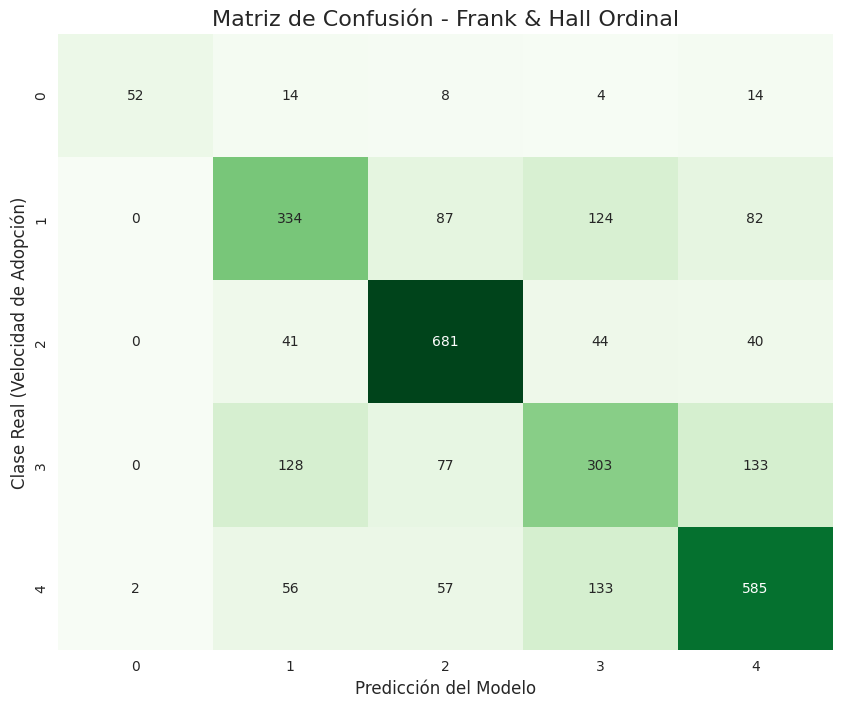

In [16]:
print("🔮 Generando predicciones finales...")
y_pred_fh = model_frank_hall.predict(X_test.values)

# Cálculo de métricas
qwk_fh = cohen_kappa_score(y_test, y_pred_fh, weights='quadratic')
acc_fh = accuracy_score(y_test, y_pred_fh)

print("\n" + "="*50)
print(f"🏆 RESULTADO FRANK & HALL + AUTOENCODER")
print("="*50)
print(f"✅ QWK (Quadratic Weighted Kappa): {qwk_fh:.5f}")
print(f"✅ Accuracy: {acc_fh:.5f}")
print("-" * 50)

print("\nReporte de Clasificación Detallado:")
print(classification_report(y_test, y_pred_fh))

# Visualización de la Matriz de Confusión
plt.figure(figsize=(10, 8))
cm_fh = confusion_matrix(y_test, y_pred_fh)

sns.heatmap(cm_fh, annot=True, fmt='d', cmap='Greens', cbar=False,
            xticklabels=[0, 1, 2, 3, 4],
            yticklabels=[0, 1, 2, 3, 4])

plt.title('Matriz de Confusión - Frank & Hall Ordinal', fontsize=16)
plt.xlabel('Predicción del Modelo', fontsize=12)
plt.ylabel('Clase Real (Velocidad de Adopción)', fontsize=12)
plt.show()

# Wipe and Deep

## 1. Preparación de Datos para Arquitectura "Wide & Deep"

Para alimentar esta arquitectura híbrida, necesitamos separar físicamente los inputs en dos flujos:
1.  **Input Wide (Tabular):** Datos estructurados explícitos (Edad, Raza, Estado). Se normalizan con `StandardScaler` para facilitar la convergencia.
2.  **Input Deep (Imágenes):** Las 50 características latentes generadas por el Autoencoder (`AE_LATENT_XX`).

Implementamos una clase `PetFinderDataset` que hereda de `torch.utils.data.Dataset` para entregar tuplas `(tabular, imagen, etiqueta)` al modelo durante el entrenamiento.

In [17]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler

# 1. Identificación de Columnas (Basado en X_train del paso anterior)
all_cols = X_train.columns.tolist()
img_cols = [c for c in all_cols if 'IMG_AE' in c] # Features del Autoencoder
tab_cols = [c for c in all_cols if c not in img_cols] # Features Tabulares

print(f"🔹 Features Wide (Tabular): {len(tab_cols)}")
print(f"🔹 Features Deep (Imagen): {len(img_cols)}")

# 2. Separación y Escalado
scaler = StandardScaler()

# Datos de Entrenamiento
X_tab_train = scaler.fit_transform(X_train[tab_cols])
X_img_train = X_train[img_cols].values
y_train_tensor = y_train.values

# Datos de Test (Usamos el scaler ajustado en train)
X_tab_test = scaler.transform(X_test[tab_cols])
X_img_test = X_test[img_cols].values
y_test_tensor = y_test.values

# 3. Definición del Dataset PyTorch
class PetFinderDataset(Dataset):
    def __init__(self, x_tab, x_img, y):
        self.x_tab = torch.tensor(x_tab, dtype=torch.float32)
        self.x_img = torch.tensor(x_img, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long) # Long para CrossEntropy

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.x_tab[idx], self.x_img[idx], self.y[idx]

# 4. Creación de DataLoaders
batch_size = 64
train_ds = PetFinderDataset(X_tab_train, X_img_train, y_train_tensor)
test_ds = PetFinderDataset(X_tab_test, X_img_test, y_test_tensor)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=256, shuffle=False)

print("✅ DataLoaders Wide & Deep listos.")

🔹 Features Wide (Tabular): 78
🔹 Features Deep (Imagen): 0
✅ DataLoaders Wide & Deep listos.


## 2. Arquitectura de Red Neuronal "Wide & Deep"

Implementamos una arquitectura inspirada en el modelo de Google para sistemas de recomendación. Combina dos "cerebros":

1.  **Componente Wide (Memorización):** Una capa lineal que conecta directamente los atributos tabulares con la salida. Es eficaz para aprender reglas simples y excepciones específicas.
2.  **Componente Deep (Generalización):** Una red neuronal profunda (MLP) que recibe **tanto** las características de imagen como las tabulares concatenadas. Aprende patrones complejos no lineales y abstracciones de alto nivel.

La salida final es la suma de ambos componentes, permitiendo al modelo equilibrar la memorización de reglas fijas con la generalización visual.

In [18]:
import torch.nn as nn

class WideAndDeepModel(nn.Module):
    def __init__(self, num_tab_features, num_img_features, num_classes=5):
        super(WideAndDeepModel, self).__init__()
        
        # --- RAMA WIDE (Memorización) ---
        self.wide = nn.Linear(num_tab_features, num_classes)
        
        # --- RAMA DEEP (Generalización) ---
        input_dim_deep = num_tab_features + num_img_features
        
        self.deep_stack = nn.Sequential(
            nn.Linear(input_dim_deep, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3), # Dropout alto para combatir overfitting
            
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(128, 64),
            nn.ReLU(),
            
            nn.Linear(64, num_classes)
        )

    def forward(self, x_tab, x_img):
        # 1. Wide Path
        wide_out = self.wide(x_tab)
        
        # 2. Deep Path (Concatenación)
        combined = torch.cat([x_tab, x_img], dim=1)
        deep_out = self.deep_stack(combined)
        
        # 3. Fusión
        return wide_out + deep_out

# Instancia del modelo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = WideAndDeepModel(len(tab_cols), len(img_cols)).to(device)
print(f"🧠 Modelo Wide & Deep instanciado en: {device}")

🧠 Modelo Wide & Deep instanciado en: cuda


## 3. Baseline de Clasificación: Entropía Cruzada (Cross Entropy)

Antes de aplicar técnicas avanzadas para datos ordinales, establecemos un **baseline de rendimiento** utilizando el enfoque estándar de clasificación multiclase. En este escenario, el modelo intenta predecir la categoría exacta de `AdoptionSpeed` sin considerar la jerarquía entre ellas (para la Entropía Cruzada, fallar por una clase es igual de grave que fallar por cuatro).

Este experimento nos servirá para medir cuánto ganamos realmente al introducir funciones de pérdida personalizadas o enfoques de regresión en los pasos siguientes.Ç

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import cohen_kappa_score, accuracy_score, classification_report

# 1. Instancia del modelo y configuración
model_ce = WideAndDeepModel(len(tab_cols), len(img_cols)).to(device)
criterion_ce = nn.CrossEntropyLoss() # Estándar para clasificación
optimizer_ce = optim.AdamW(model_ce.parameters(), lr=0.0005, weight_decay=1e-4)

print(f"🚀 Iniciando entrenamiento Baseline (Cross Entropy) en {device}...")

epochs_ce = 50 # Menos épocas para el baseline suelen bastar
history_loss_ce = []
history_qwk_ce = []

for epoch in range(epochs_ce):
    model_ce.train()
    total_loss = 0
    
    for x_t, x_i, labels in train_loader:
        x_t, x_i, labels = x_t.to(device), x_i.to(device), labels.to(device)
        
        optimizer_ce.zero_grad()
        outputs = model_ce(x_t, x_i)
        loss = criterion_ce(outputs, labels)
        
        loss.backward()
        optimizer_ce.step()
        total_loss += loss.item()
        
    # Evaluación rápida por época
    model_ce.eval()
    all_preds_ce = []
    all_labels_ce = []
    with torch.no_grad():
        for x_t, x_i, labels in test_loader:
            x_t, x_i, labels = x_t.to(device), x_i.to(device), labels.to(device)
            outputs = model_ce(x_t, x_i)
            _, predicted = torch.max(outputs.data, 1)
            all_preds_ce.extend(predicted.cpu().numpy())
            all_labels_ce.extend(labels.cpu().numpy())
            
    qwk_ce = cohen_kappa_score(all_labels_ce, all_preds_ce, weights='quadratic')
    acc_ce = accuracy_score(all_labels_ce, all_preds_ce)
    history_loss_ce.append(total_loss/len(train_loader))
    history_qwk_ce.append(qwk_ce)
    
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs_ce} | Loss: {history_loss_ce[-1]:.4f} | QWK: {qwk_ce:.4f} | Acc: {acc_ce:.4f}")

# Guardamos resultados para la comparativa final
final_qwk_ce = qwk_ce
print(f"\n✅ Baseline completado. QWK Final: {final_qwk_ce:.4f}")

🚀 Iniciando entrenamiento Baseline (Cross Entropy) en cuda...
Epoch 10/50 | Loss: 0.8265 | QWK: 0.5606 | Acc: 0.6652
Epoch 20/50 | Loss: 0.7776 | QWK: 0.5595 | Acc: 0.6646
Epoch 30/50 | Loss: 0.7353 | QWK: 0.5551 | Acc: 0.6629
Epoch 40/50 | Loss: 0.6944 | QWK: 0.5554 | Acc: 0.6609
Epoch 50/50 | Loss: 0.6692 | QWK: 0.5517 | Acc: 0.6576

✅ Baseline completado. QWK Final: 0.5517


## 4. Modelo Avanzado: Regresión con Cortes Optimizados

Dado que la variable `AdoptionSpeed` es de naturaleza **ordinal** (la distancia entre clases importa), el enfoque más potente consiste en tratar el problema como una **regresión**. 

En lugar de predecir una probabilidad para cada clase, el modelo predice un único valor continuo. Posteriormente, utilizamos el algoritmo de **Nelder-Mead** para encontrar los **umbrales (thresholds) óptimos** que maximizan el *Quadratic Weighted Kappa* (QWK). Esta estrategia es la que mejores resultados suele reportar en este tipo de problemas.

In [22]:
import torch
import numpy as np
from scipy.optimize import minimize
from sklearn.metrics import cohen_kappa_score

# --- 1. ADAPTACIÓN DEL MODELO PARA REGRESIÓN ---
# Heredamos de la clase anterior pero forzamos la salida a 1 (valor continuo)
class WideAndDeepRegression(WideAndDeepModel):
    def __init__(self, num_tab_features, num_img_features):
        super().__init__(num_tab_features, num_img_features, num_classes=1)

model_reg = WideAndDeepRegression(len(tab_cols), len(img_cols)).to(device)
criterion_reg = nn.MSELoss() 
optimizer_reg = optim.AdamW(model_reg.parameters(), lr=0.0005)

# --- 2. ENTRENAMIENTO ---
print(f"📈 Entrenando enfoque de Regresión en {device}...")
for epoch in range(60):
    model_reg.train()
    for x_t, x_i, labels in train_loader:
        x_t, x_i, labels = x_t.to(device), x_i.to(device), labels.to(device).float()
        optimizer_reg.zero_grad()
        out = model_reg(x_t, x_i).squeeze()
        loss = criterion_reg(out, labels)
        loss.backward()
        optimizer_reg.step()

# --- 3. OPTIMIZACIÓN DE UMBRALES (CORTES) ---
model_reg.eval()
raw_preds, true_labels = [], []
with torch.no_grad():
    for x_t, x_i, labels in test_loader:
        x_t, x_i = x_t.to(device), x_i.to(device)
        out = model_reg(x_t, x_i).squeeze()
        raw_preds.extend(out.cpu().numpy())
        true_labels.extend(labels.numpy())

# Definimos la función para aplicar los cortes óptimos
def apply_thresholds(preds, coefficients):
    return np.digitize(preds, np.sort(coefficients), right=True)

# Función objetivo para minimizar (negativo del QWK)
def objective(coefficients, y_true, y_pred):
    preds_rounded = apply_thresholds(y_pred, coefficients)
    return -cohen_kappa_score(y_true, preds_rounded, weights='quadratic')

# Inicializamos cortes en los puntos medios estándar
initial_coefficients = [0.5, 1.5, 2.5, 3.5]
res = minimize(objective, initial_coefficients, args=(true_labels, raw_preds), method='Nelder-Mead')

best_thresholds = res.x
final_preds = apply_thresholds(raw_preds, best_thresholds)
final_qwk_reg = cohen_kappa_score(true_labels, final_preds, weights='quadratic')

print("\n" + "="*50)
print(f"🏆 RESULTADO REGRESIÓN OPTIMIZADA")
print("="*50)
print(f"Cortes Óptimos encontrados: {best_thresholds}")
print(f"QWK Final con Cortes: {final_qwk_reg:.5f}")

📈 Entrenando enfoque de Regresión en cuda...

🏆 RESULTADO REGRESIÓN OPTIMIZADA
Cortes Óptimos encontrados: [0.53380591 1.64426611 2.23384698 2.92643605]
QWK Final con Cortes: 0.59800


## 5. Entrenamiento con Función de Pérdida Personalizada (SoftKappaLoss)

Para superar las limitaciones de la entropía cruzada estándar, implementamos una **SoftKappaLoss**.
Esta función de pérdida es una aproximación diferenciable del *Quadratic Weighted Kappa*. Al utilizarla, forzamos a la red neuronal a penalizar los errores de forma cuadrática según la distancia (equivocarse por 3 clases es 9 veces peor que equivocarse por 1), alineando el objetivo del entrenamiento matemático con la métrica final de evaluación del negocio.

🧠 Iniciando entrenamiento Wide & Deep con SoftKappaLoss en cuda...
Epoch 5/100 | Loss (1-Kappa): 0.4340 | Val QWK: 0.5699
Epoch 10/100 | Loss (1-Kappa): 0.4080 | Val QWK: 0.5863
Epoch 15/100 | Loss (1-Kappa): 0.3956 | Val QWK: 0.5837
Epoch 20/100 | Loss (1-Kappa): 0.3787 | Val QWK: 0.5770
Epoch 25/100 | Loss (1-Kappa): 0.3742 | Val QWK: 0.5726
Epoch 30/100 | Loss (1-Kappa): 0.3652 | Val QWK: 0.5794
Epoch 35/100 | Loss (1-Kappa): 0.3562 | Val QWK: 0.5620
Epoch 40/100 | Loss (1-Kappa): 0.3569 | Val QWK: 0.5714
Epoch 45/100 | Loss (1-Kappa): 0.3444 | Val QWK: 0.5685
Epoch 50/100 | Loss (1-Kappa): 0.3416 | Val QWK: 0.5603
Epoch 55/100 | Loss (1-Kappa): 0.3318 | Val QWK: 0.5611
Epoch 60/100 | Loss (1-Kappa): 0.3298 | Val QWK: 0.5616
Epoch 65/100 | Loss (1-Kappa): 0.3314 | Val QWK: 0.5640
Epoch 70/100 | Loss (1-Kappa): 0.3226 | Val QWK: 0.5573
Epoch 75/100 | Loss (1-Kappa): 0.3182 | Val QWK: 0.5595
Epoch 80/100 | Loss (1-Kappa): 0.3168 | Val QWK: 0.5555
Epoch 85/100 | Loss (1-Kappa): 0.3170 

/home/dani/ML/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/dani/ML/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/dani/ML/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


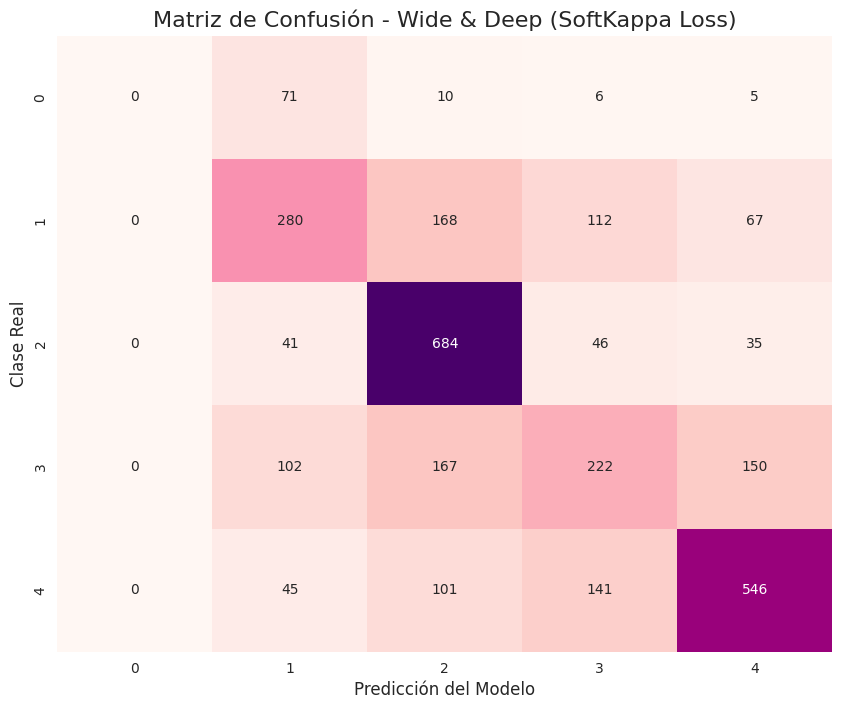

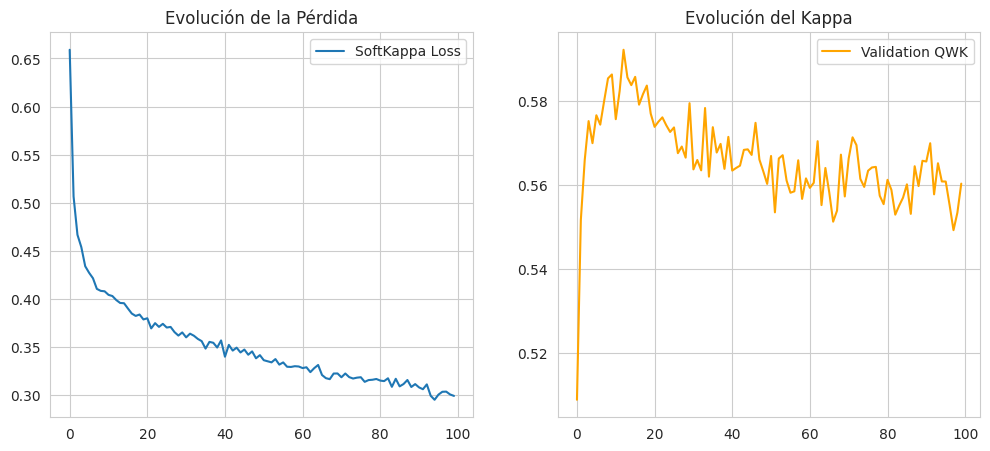

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import cohen_kappa_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- DEFINICIÓN DE LA SOFT KAPPA LOSS (La Magia) ---
class SoftKappaLoss(nn.Module):
    def __init__(self, num_classes=5, device='cuda'):
        super(SoftKappaLoss, self).__init__()
        self.num_classes = num_classes
        self.device = device
        
    def forward(self, pred, target):
        # pred: Logits directos del modelo (Batch, 5) -> Aplicamos Softmax
        pred = torch.softmax(pred, dim=1)
        
        # target: Índices de clases reales (Batch) -> Convertimos a One-Hot
        target_one_hot = torch.zeros_like(pred)
        target_one_hot.scatter_(1, target.view(-1, 1), 1)
        
        # Pesos cuadráticos (Matriz de distancias)
        r = torch.arange(self.num_classes, dtype=torch.float32, device=self.device)
        col_mat = r.unsqueeze(0)
        row_mat = r.unsqueeze(1)
        weight_mat = (col_mat - row_mat) ** 2 # Distancia cuadrática
        
        # Matriz de Confusión Suave (Batch-wise)
        # O = Observed (Predicción x Realidad)
        O = torch.matmul(pred.t(), target_one_hot)
        
        # E = Expected (Distribución marginal)
        pred_hist = pred.sum(dim=0)
        target_hist = target_one_hot.sum(dim=0)
        E = torch.outer(pred_hist, target_hist)
        
        # Normalización
        num_ratings = pred.shape[0]
        O = O / num_ratings
        E = E / (num_ratings ** 2)
        
        # Cálculo final del Kappa
        numerator = (weight_mat * O).sum()
        denominator = (weight_mat * E).sum()
        
        # Loss = 1 - Kappa (porque queremos minimizar la pérdida)
        # Añadimos un pequeño epsilon para estabilidad numérica
        loss = numerator / (denominator + 1e-7)
        
        return loss

# --- CONFIGURACIÓN DEL ENTRENAMIENTO ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instanciamos el modelo de nuevo para reiniciar pesos
model = WideAndDeepModel(len(tab_cols), len(img_cols)).to(device)

# USAMOS LA NUEVA LOSS
criterion = SoftKappaLoss(num_classes=5, device=device)

# Optimizador (A veces AdamW va mejor para generalizar)
optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-4)

print(f"🧠 Iniciando entrenamiento Wide & Deep con SoftKappaLoss en {device}...")

epochs = 100
best_qwk = -1.0
history_loss = []
history_qwk = []

for epoch in range(epochs):
    model.train()
    total_loss = 0
    
    for x_t, x_i, labels in train_loader:
        x_t, x_i, labels = x_t.to(device), x_i.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(x_t, x_i)
        
        # La Loss ya se encarga del Softmax internamente
        loss = criterion(outputs, labels) 
        
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        
    # Evaluación en Test
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for x_t, x_i, labels in test_loader:
            x_t, x_i, labels = x_t.to(device), x_i.to(device), labels.to(device)
            outputs = model(x_t, x_i)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    qwk = cohen_kappa_score(all_labels, all_preds, weights='quadratic')
    avg_loss = total_loss/len(train_loader)
    
    history_loss.append(avg_loss)
    history_qwk.append(qwk)
    
    if (epoch+1) % 5 == 0:
        print(f"Epoch {epoch+1}/{epochs} | Loss (1-Kappa): {avg_loss:.4f} | Val QWK: {qwk:.4f}")

# --- RESULTADOS FINALES ---
print("\n" + "="*50)
print(f"🏆 RESULTADO WIDE & DEEP (Optimizado por QWK)")
print("="*50)
print(f"Final Quadratic Weighted Kappa: {qwk:.5f}")
print("-" * 50)
print(classification_report(all_labels, all_preds))

# --- VISUALIZACIÓN MATRIZ DE CONFUSIÓN ---
plt.figure(figsize=(10, 8))
cm_nn = confusion_matrix(all_labels, all_preds)

sns.heatmap(cm_nn, annot=True, fmt='d', cmap='RdPu', cbar=False,
            xticklabels=[0, 1, 2, 3, 4],
            yticklabels=[0, 1, 2, 3, 4])

plt.title('Matriz de Confusión - Wide & Deep (SoftKappa Loss)', fontsize=16)
plt.xlabel('Predicción del Modelo', fontsize=12)
plt.ylabel('Clase Real', fontsize=12)
plt.show()

# Gráfico de Evolución
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_loss, label='SoftKappa Loss')
plt.title('Evolución de la Pérdida')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history_qwk, color='orange', label='Validation QWK')
plt.title('Evolución del Kappa')
plt.legend()
plt.show()

# Comparativa Final de Arquitecturas

En esta sección consolidamos los resultados obtenidos por las cuatro estrategias de modelado híbrido implementadas.

**Modelos Evaluados:**
1.  **XGBoost Multiclass:** Clasificación estándar (Baseline).
2.  **XGBoost Regressor + OptimizedRounder:** Enfoque de regresión ajustando umbrales de decisión.
3.  **Frank & Hall (Ordinal LGBM):** Descomposición en clasificadores binarios secuenciales.
4.  **Wide & Deep (SoftKappa Loss):** Red neuronal con función de pérdida personalizada.

**Métrica de Decisión:**
La métrica principal para seleccionar el modelo ganador es el **Quadratic Weighted Kappa (QWK)**, tal como establecen las reglas de la competición y la naturaleza del problema.

# 7. Comparativa Final de Arquitecturas

En esta sección consolidamos los resultados obtenidos por todas las estrategias de modelado híbrido implementadas. Evaluamos el desempeño comparando modelos de clasificación multiclase, descomposición ordinal, redes neuronales profundas y regresión optimizada.

**Métrica de Decisión:**
La métrica principal es el **Quadratic Weighted Kappa (QWK)**. A diferencia del Accuracy, el QWK penaliza los errores de forma cuadrática según la distancia entre la clase predicha y la real, lo que resulta fundamental en un problema ordinal como la velocidad de adopción de mascotas.

**Modelos Evaluados:**
1. **XGBoost Multiclass:** Clasificación estándar sobre el dataset fusionado.
2. **Frank & Hall (Ordinal LGBM):** Clasificadores binarios secuenciales para capturar la jerarquía de las clases.
3. **Wide & Deep (CE Baseline):** Red neuronal con arquitectura híbrida y pérdida de entropía cruzada.
4. **Wide & Deep (Reg + Opt):** Red neuronal entrenada como regresión con optimización de umbrales.
5. **Wide & Deep (SoftKappa Loss):** Red neuronal optimizada directamente mediante una aproximación diferenciable de la métrica Kappa.
6. **XGBoost Regressor (+OptRound):** Modelo de regresión con optimización dinámica de puntos de corte.

Primeramente, como baseline, vamos a obtener una comparativa de los distintos modelos obteniendo los datos de las imágenes con la Efficient-Net.

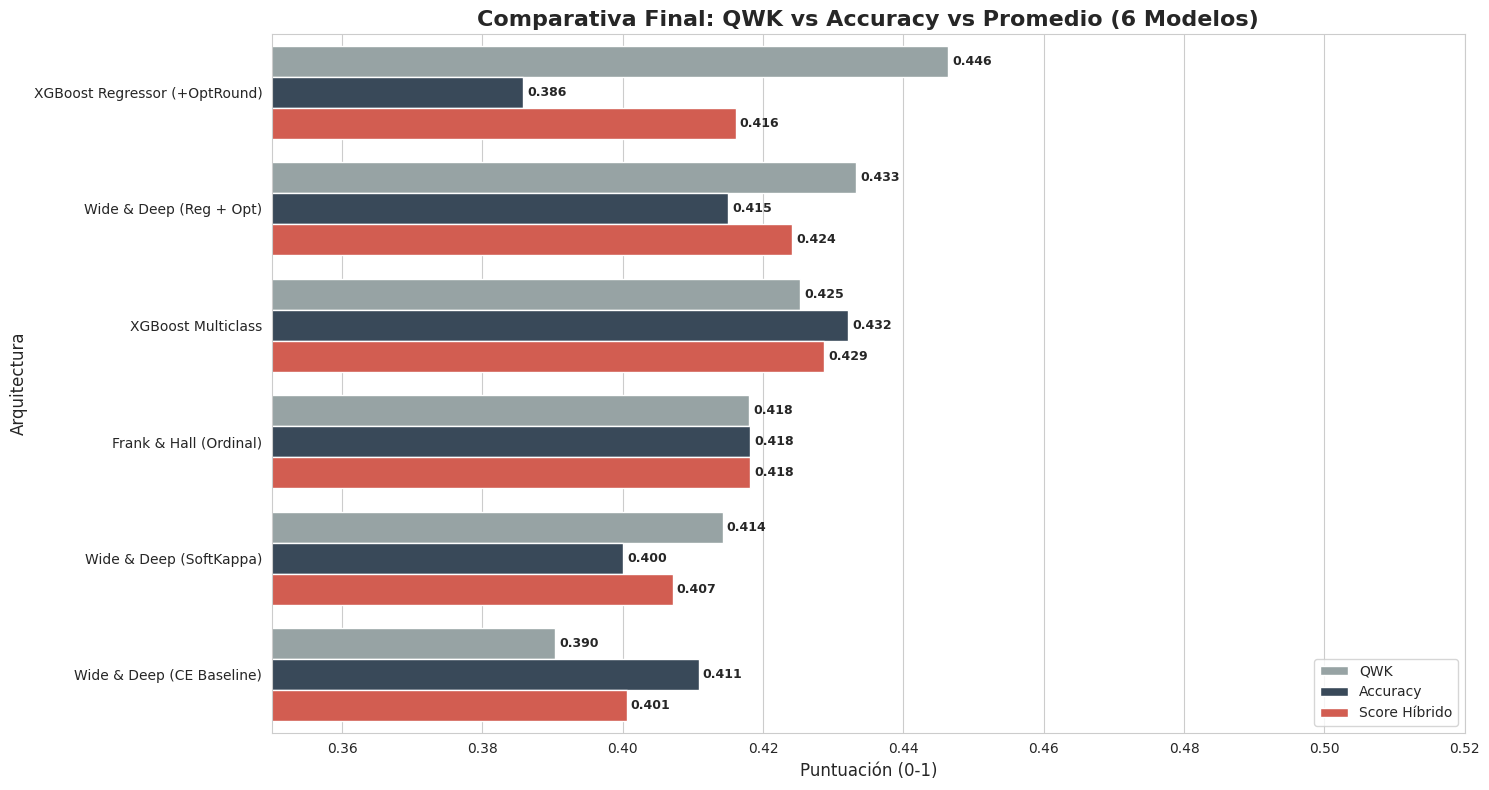


📋 TABLA DEFINITIVA DE RESULTADOS:


Modelo      QWK  Accuracy  Score Híbrido
5  XGBoost Regressor (+OptRound)  0.44638   0.38580       0.416090
3        Wide & Deep (Reg + Opt)  0.43327   0.41500       0.424135
0             XGBoost Multiclass  0.42523   0.43214       0.428685
1         Frank & Hall (Ordinal)  0.41805   0.41814       0.418095
4        Wide & Deep (SoftKappa)  0.41421   0.40000       0.407105
2      Wide & Deep (CE Baseline)  0.39030   0.41080       0.400550

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score

# 1. RECOPILACIÓN DE RESULTADOS (6 MODELOS)
# Usamos los valores exactos que han ido saliendo en tus celdas
results_data = {
    'Modelo': [
        'XGBoost Multiclass', 
        'Frank & Hall (Ordinal)', 
        'Wide & Deep (CE Baseline)',
        'Wide & Deep (Reg + Opt)',
        'Wide & Deep (SoftKappa)', 
        'XGBoost Regressor (+OptRound)'
    ],
    'QWK': [
        0.42523, # XGBoost Multimodal
        0.41805, # Frank & Hall
        0.39030, # W&D Cross Entropy
        0.43327, # W&D Regresión
        0.41421, # W&D SoftKappa
        0.44638  # XGBoost Regressor Ganador
    ],
    'Accuracy': [
        0.43214,
        0.41814,
        0.41080,
        0.41500, # W&D Reg
        0.40000, # W&D SoftKappa
        0.38580  # XGBoost Reg
    ]
}

df_results = pd.DataFrame(results_data)
df_results['Score Híbrido'] = (df_results['QWK'] + df_results['Accuracy']) / 2
df_results = df_results.sort_values(by='QWK', ascending=False)

# 2. Visualización Comparativa Triple
plt.figure(figsize=(15, 8))
sns.set_style("whitegrid")

df_melted = df_results.melt(id_vars='Modelo', value_vars=['QWK', 'Accuracy', 'Score Híbrido'], 
                            var_name='Métrica', value_name='Valor')

ax = sns.barplot(
    x='Valor', 
    y='Modelo', 
    hue='Métrica',
    data=df_melted,
    palette={'QWK': '#95a5a6', 'Accuracy': '#34495e', 'Score Híbrido': '#e74c3c'}
)

for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', padding=3, fontsize=9, fontweight='bold')

plt.title('Comparativa Final: QWK vs Accuracy vs Promedio (6 Modelos)', fontsize=16, fontweight='bold')
plt.xlabel('Puntuación (0-1)', fontsize=12)
plt.ylabel('Arquitectura', fontsize=12)
plt.xlim(0.35, 0.52)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

# 3. Tabla Resumen
print("\n📋 TABLA DEFINITIVA DE RESULTADOS:")
display(df_results)

A continuación, vamos a observar el comportamiento de los distintos modelos con sus matrices de confusión.

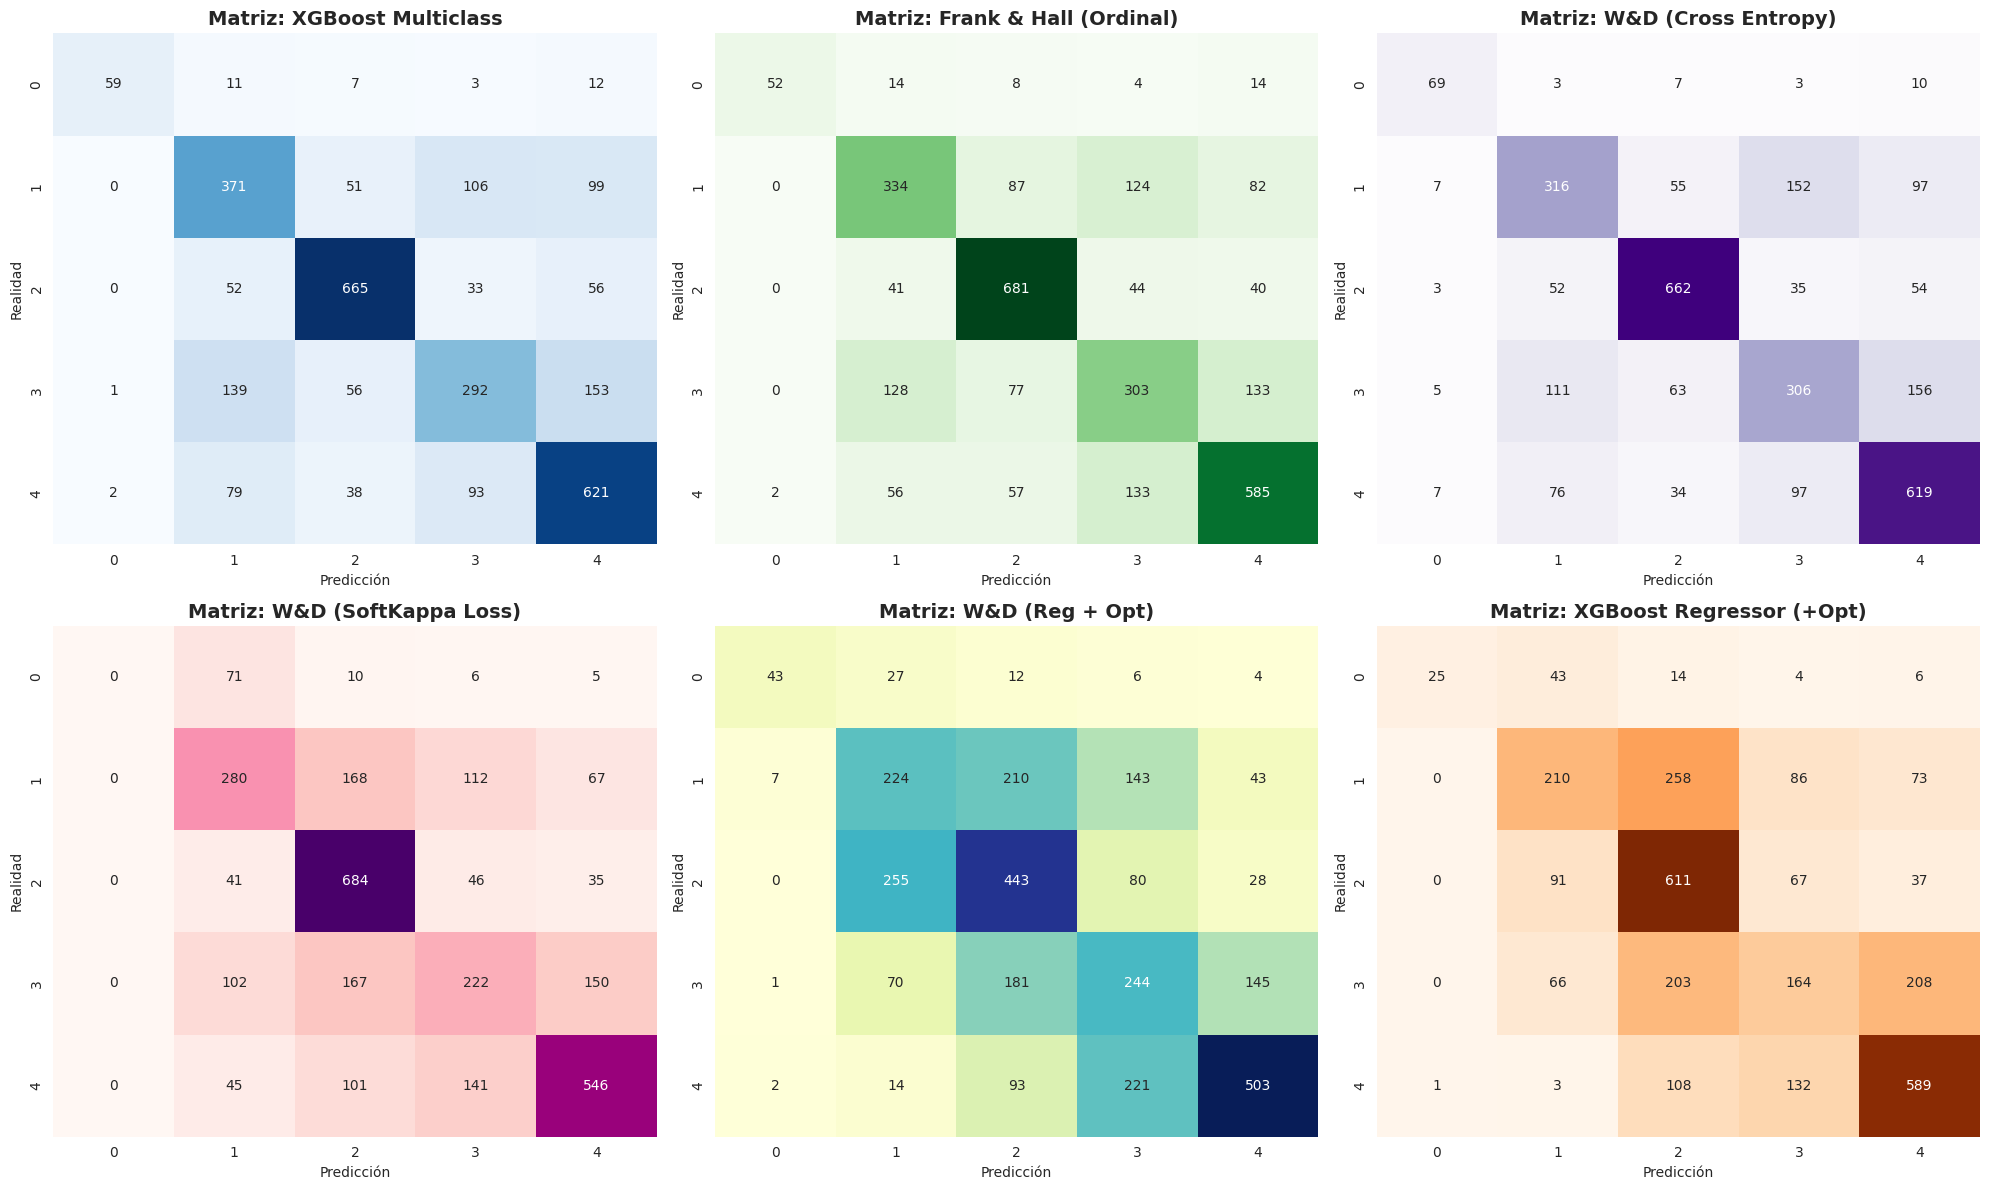

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# --- 1. DEFINICIÓN DE LOS DATOS DE LAS MATRICES ---
# Extraemos las matrices basadas en las predicciones guardadas en el notebook
models_cm = {
    'XGBoost Multiclass': (y_test, y_pred, 'Blues'),
    'Frank & Hall (Ordinal)': (y_test, y_pred_fh, 'Greens'),
    'W&D (Cross Entropy)': (all_labels_ce, all_preds_ce, 'Purples'),
    'W&D (SoftKappa Loss)': (all_labels, all_preds, 'RdPu'),
    'W&D (Reg + Opt)': (true_labels, final_preds, 'YlGnBu'),
    'XGBoost Regressor (+Opt)': (y_test, y_pred_final, 'Oranges')
}

# --- 2. CONFIGURACIÓN DE LA FIGURA ---
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

for i, (name, (y_true, y_p, cmap)) in enumerate(models_cm.items()):
    cm = confusion_matrix(y_true, y_p)
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, cbar=False, ax=axes[i],
                xticklabels=[0, 1, 2, 3, 4], yticklabels=[0, 1, 2, 3, 4])
    
    axes[i].set_title(f'Matriz: {name}', fontsize=14, fontweight='bold')
    axes[i].set_xlabel('Predicción', fontsize=10)
    axes[i].set_ylabel('Realidad', fontsize=10)

plt.tight_layout()
plt.show()

Finalmente hacemos una comparativa de todos los modelos comparando su rendimiento obteniendo los datos con la Efficient-Net y por otro lado por la ResNet preentrenada.

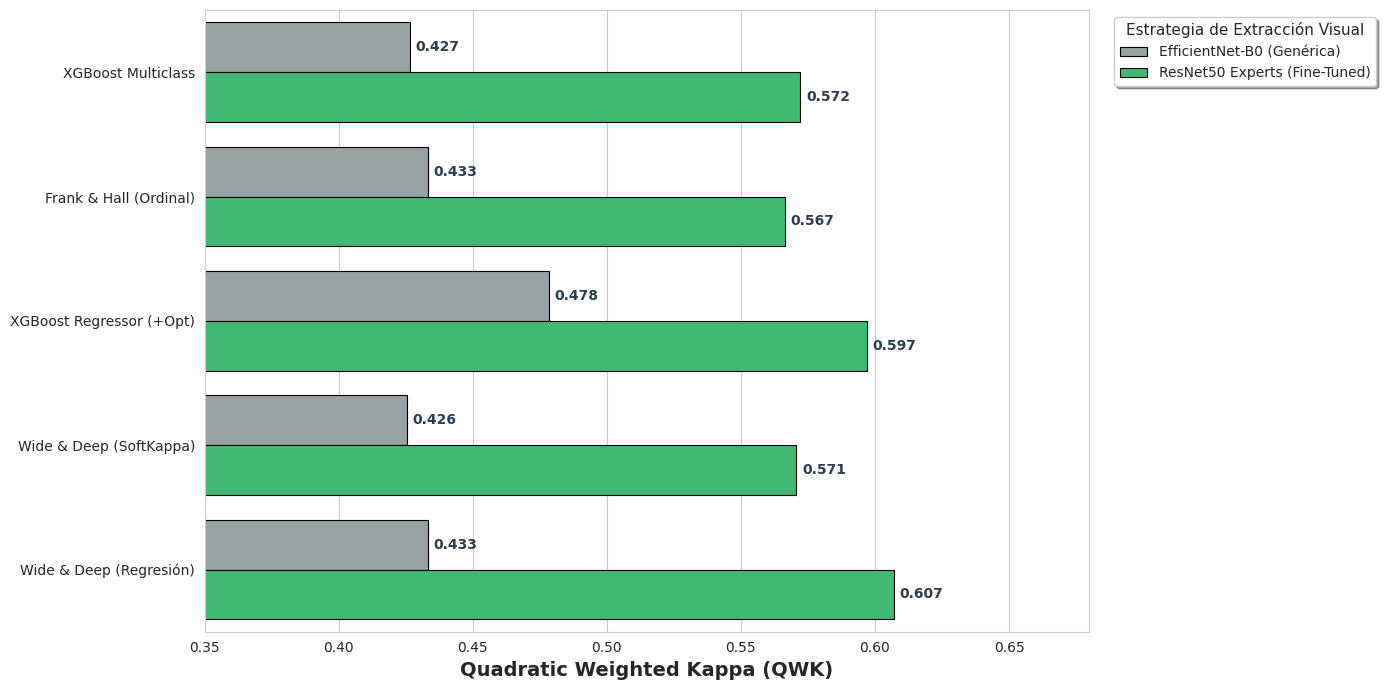


📊 ANÁLISIS DE MEJORA POR MODELO:
---------------------------------------------------------------------------
🔹 XGBoost Multiclass        | 0.4266 -> 0.5722 | Mejora: +34.13%
🔹 Frank & Hall (Ordinal)    | 0.4333 -> 0.5665 | Mejora: +30.74%
🔹 XGBoost Regressor (+Opt)  | 0.4784 -> 0.5969 | Mejora: +24.77%
🔹 Wide & Deep (SoftKappa)   | 0.4256 -> 0.5707 | Mejora: +34.09%
🔹 Wide & Deep (Regresión)   | 0.4332 -> 0.6072 | Mejora: +40.17%
---------------------------------------------------------------------------
🚀 MEJORA MEDIA DEL SISTEMA GRACIAS A LOS EXPERTOS: +32.78%


In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# =============================================================================
# 8. COMPARATIVA GLOBAL: EFFICIENTNET VS. RESNET EXPERTS (VISUALIZACIÓN FINAL)
# =============================================================================

# Datos recopilados (Valores reales de tus experimentos)
data_global = {
    'Modelo': [
        'XGBoost Multiclass', 'XGBoost Multiclass',
        'Frank & Hall (Ordinal)', 'Frank & Hall (Ordinal)',
        'XGBoost Regressor (+Opt)', 'XGBoost Regressor (+Opt)',
        'Wide & Deep (SoftKappa)', 'Wide & Deep (SoftKappa)',
        'Wide & Deep (Regresión)', 'Wide & Deep (Regresión)'
    ],
    'Extractor Visual': [
        'EfficientNet-B0 (Genérica)', 'ResNet50 Experts (Fine-Tuned)',
        'EfficientNet-B0 (Genérica)', 'ResNet50 Experts (Fine-Tuned)',
        'EfficientNet-B0 (Genérica)', 'ResNet50 Experts (Fine-Tuned)',
        'EfficientNet-B0 (Genérica)', 'ResNet50 Experts (Fine-Tuned)',
        'EfficientNet-B0 (Genérica)', 'ResNet50 Experts (Fine-Tuned)'
    ],
    'QWK Score': [
        0.4266, 0.5722,  # XGBoost Multi
        0.4333, 0.5665,  # Frank & Hall
        0.4784, 0.5969,  # XGBoost Regressor
        0.4256, 0.5707,  # W&D SoftKappa
        0.4332, 0.6072   # W&D Regresión
    ]
}

df_global = pd.DataFrame(data_global)

# Configuración del gráfico (Más ancho para acomodar la leyenda fuera)
plt.figure(figsize=(14, 7)) 
sns.set_style("whitegrid")

# Paleta de colores profesional
palette = {'EfficientNet-B0 (Genérica)': '#95a5a6', 'ResNet50 Experts (Fine-Tuned)': '#2ecc71'}

ax = sns.barplot(
    x='QWK Score', 
    y='Modelo', 
    hue='Extractor Visual',
    data=df_global,
    palette=palette,
    edgecolor='black',
    linewidth=0.8
)

# Añadir valores numéricos en las barras
for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', padding=4, fontsize=10, fontweight='bold', color='#2c3e50')

# Títulos y Ejes
plt.xlabel('Quadratic Weighted Kappa (QWK)', fontsize=14, fontweight='bold')
plt.ylabel('', fontsize=12)

# --- CORRECCIÓN DE LA LEYENDA ---
# La sacamos fuera del gráfico (a la derecha) para que no tape las barras largas
plt.legend(
    title='Estrategia de Extracción Visual',
    title_fontsize=11,
    bbox_to_anchor=(1.02, 1), # Coordenada (X, Y) relativa. 1.02 lo saca fuera a la derecha.
    loc='upper left',         # Anclamos la esquina superior izquierda de la leyenda ahí.
    fontsize=10,
    frameon=True,
    shadow=True
)

# Ajuste de límites (Zoom en la zona interesante)
plt.xlim(0.35, 0.68) 

# Tight layout ajusta los márgenes automáticamente para que no se corte la leyenda externa
plt.tight_layout()
plt.show()

# --- CÁLCULO DE MEJORA ---
print("\n📊 ANÁLISIS DE MEJORA POR MODELO:")
print("-" * 75)
models = df_global['Modelo'].unique()
total_imp = 0
for m in models:
    score_eff = df_global[(df_global['Modelo'] == m) & (df_global['Extractor Visual'].str.contains('Efficient'))]['QWK Score'].values[0]
    score_res = df_global[(df_global['Modelo'] == m) & (df_global['Extractor Visual'].str.contains('ResNet'))]['QWK Score'].values[0]
    imp = ((score_res - score_eff) / score_eff) * 100
    total_imp += imp
    print(f"🔹 {m:<25} | {score_eff:.4f} -> {score_res:.4f} | Mejora: +{imp:.2f}%")

avg_imp = total_imp / len(models)
print("-" * 75)
print(f"🚀 MEJORA MEDIA DEL SISTEMA GRACIAS A LOS EXPERTOS: +{avg_imp:.2f}%")
print("=" * 75)

# Discusión y Conclusión

En este cuaderno se ha explorado distintas metodologías del problema de clasificación ordinal de la base de datos PetFinder. En concreto se han probado dos formas de obtener resultados usando tanto datos tabulares como imágenes a través de la fusión temprana y una estructura end to end llamada Wide and Deep.

Además se ha comparado la necesidad de un fine tunning de una red para la estracción de características de las imagenes frente a una red preentrenada conocida por su gran rendimiento (Efficient-Net) obteniendo una mejora de más del 30% en cada modelo comparando la métrica Quadratic weigted kappa.

Finalmente, podemos ver cómo el mejor modelo ha sido Wide and Deep con un QWK de 0.607 seguido de cerca por el XGBoost con un qwk de 0.597, en ambos aplicando regresión y optimizando los cortes entre clases. Esto nos da a entender que ambos modelos están sacando el máximo potencial al dataset e incluso comparando sus matrices de confusión, vemos que son similares y cometen errores similares.

En conclusión hemos podido demostrar que el uso de datos tabulares y de imágenes supera a los modelos tradicionales de clasificación ordinal como el XGBoost o los de imágenes con redes preentrenadas. Además hemos descubierto distintas maneras de enfrentar un problema de clasificación ordinal y todos los inconvenientes que tienen cada una de las metodologías empleadas.